In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import glob
from scipy.stats import pearsonr, spearmanr

## 0. Lecture des résultats

In [72]:
files = glob.glob('../experiments/task_binary_3/res/20250629/*.csv')
files_df = [pd.read_csv(f) for f in files]
results = pd.concat(files_df, ignore_index=True)

results['Q_type'] = results.apply(lambda x: 'Q_pos' if x['expected'] == 'Oui' else 'Q_neg', axis=1)
# results.head()

In [73]:
md_mapping = {
    "meta-llama": "LLaMA",
    "mistralai": "Mistral",
    "Qwen": "Qwen",
}
results['model'] = results['model'].replace(md_mapping)

In [74]:
results["True"] = results["expected"].str.lower() == 'oui'
results["Pred"] = results["response"].str.lower() == 'oui'
results.head(20)

,model,target,question_id,scope_id,kw_context,vl_propform,justify,k-shot,repeat_num,q_kw,q_vl,q_lf,expected,response,Q_type,True,Pred
0,LLaMA,Substitutive,1,1,0,1,0,2,1,pic,outil,Gener,Oui,Non,Q_pos,True,False
1,LLaMA,Substitutive,1,1,0,1,0,2,2,pic,outil,Gener,Oui,Oui,Q_pos,True,True
2,LLaMA,Substitutive,1,1,0,1,0,2,3,pic,outil,Gener,Oui,Non,Q_pos,True,False
3,LLaMA,Substitutive,1,1,0,1,0,2,4,pic,outil,Gener,Oui,Non,Q_pos,True,False
4,LLaMA,Substitutive,1,1,0,1,0,2,5,pic,outil,Gener,Oui,Non,Q_pos,True,False
5,LLaMA,Substitutive,2,1,0,1,0,2,1,terrestre,aérien,Contr,Oui,Non,Q_pos,True,False
6,LLaMA,Substitutive,2,1,0,1,0,2,2,terrestre,aérien,Contr,Oui,Oui,Q_pos,True,True
7,LLaMA,Substitutive,2,1,0,1,0,2,3,terrestre,aérien,Contr,Oui,Non,Q_pos,True,False
8,LLaMA,Substitutive,2,1,0,1,0,2,4,terrestre,aérien,Contr,Oui,Oui,Q_pos,True,True
9,LLaMA,Substitutive,2,1,0,1,0,2,5,terrestre,aérien,Contr,Oui,Non,Q_pos,True,False


In [75]:
results['target'].value_counts()

target
Real1                     18000
Able2                     18000
RealΩ                     18000
Able1                     18000
Fact0                     18000
                          ...  
Modificateur               3600
Collocation_verbale        3600
Dérivation_adjectivale     3600
Dérivation_verbale         3600
Substitutive               3600
Name: count, Length: 82, dtype: int64

## 1. Vue Globale
### la performance globale des modèles, en regardant la différrence entre les q_pos vs q_neg

In [76]:
def evaluate_binary_predictions(df, groupby_cols=None):
    if groupby_cols:
        grouped = df.groupby(groupby_cols)
    else:
        grouped = [("Global", df)]

    for group_key, group_df in grouped:
        print("="*80)
        print(f"🔹 Results for: {group_key}")
        y_true = group_df["expected"]
        y_pred = group_df["response"]
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=["Oui", "Non"], digits=3))

In [77]:
evaluate_binary_predictions(results, groupby_cols=["model"])

🔹 Results for: ('LLaMA',)

Classification Report:
              precision    recall  f1-score   support

         Oui      0.552     0.716     0.623    149400
         Non      0.596     0.419     0.492    149400

    accuracy                          0.567    298800
   macro avg      0.574     0.567     0.558    298800
weighted avg      0.574     0.567     0.558    298800

🔹 Results for: ('Mistral',)

Classification Report:
              precision    recall  f1-score   support

         Oui      0.552     0.716     0.623    149400
         Non      0.596     0.419     0.492    149400

    accuracy                          0.567    298800
   macro avg      0.574     0.567     0.558    298800
weighted avg      0.574     0.567     0.558    298800

🔹 Results for: ('Mistral',)

Classification Report:
              precision    recall  f1-score   support

         Oui      0.656     0.129     0.215    149400
         Non      0.517     0.932     0.665    149400

    accuracy                

#### Biais de réponses pour tous les 3 modèles
Pour cette tâche, Qwen penche clairement vers « Non », tandis que Mistral fait exactement le contraire. LLaMA, quant à lui, a une légère tendance à répondre « Oui », mais ce biais est moins marqué que chez les deux autres modèles.

/var/folders/04/mz2jyny17hz88wzglmzrlwpr0000gn/T/ipykernel_1499/3751969486.py:61: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.88, wspace=0.02)


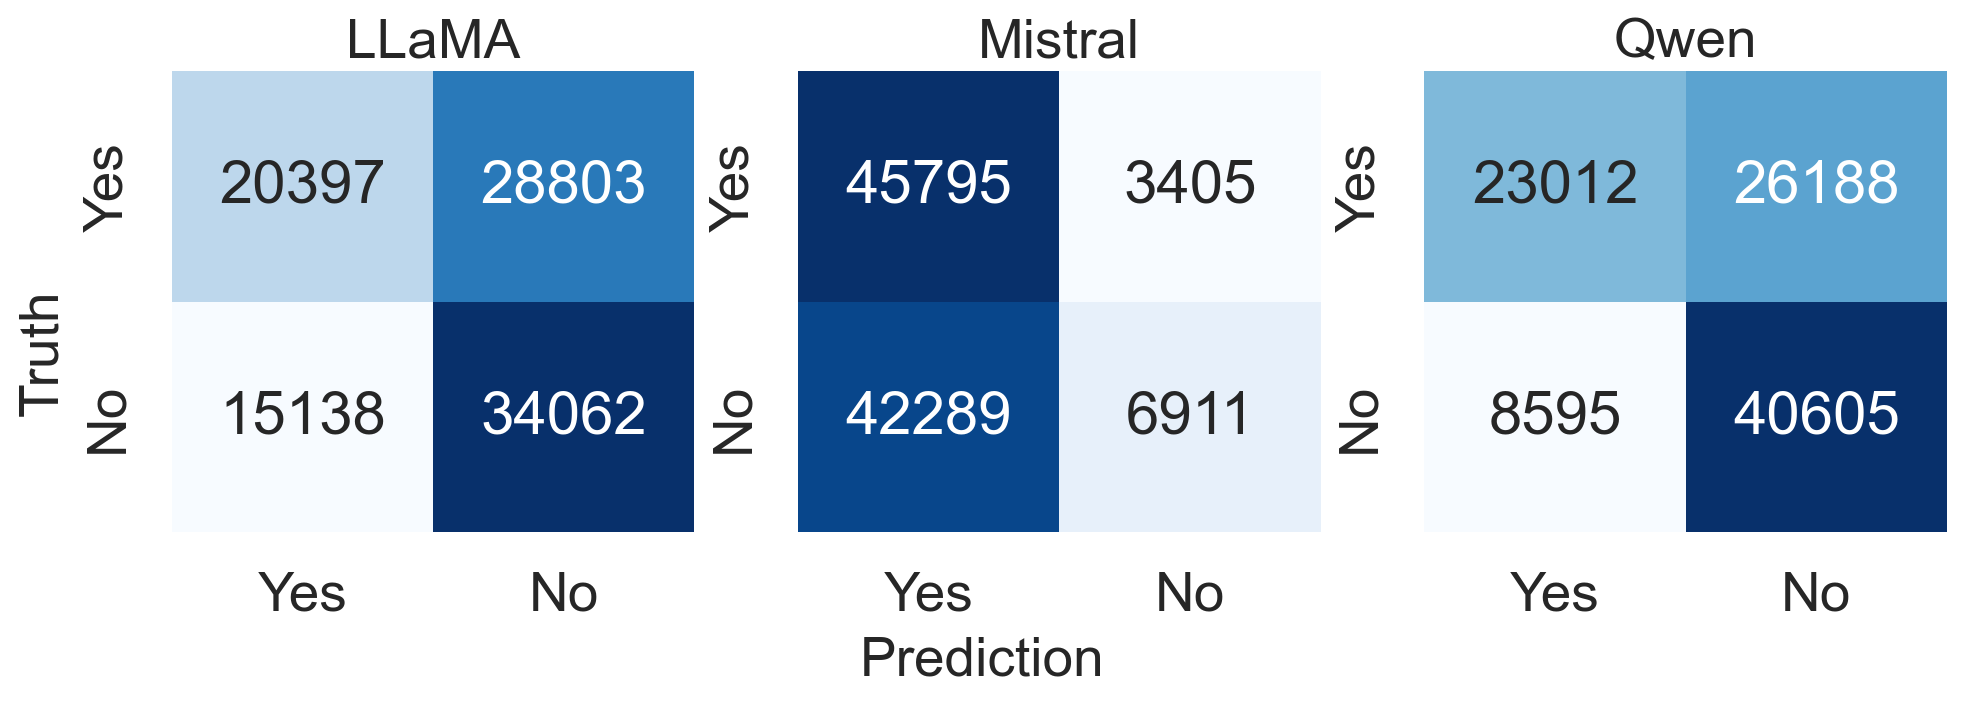

In [78]:
models = results["model"].unique()
n_models = len(models)

# 尺寸按模型数自适应放大；dpi 也适当提高，保证清晰
fig, axes = plt.subplots(
    1, n_models,
    figsize=(3.6 * n_models, 3.8),
    constrained_layout=True,
    dpi=180
)

# 统一风格与字号（可按需微调）
sns.set_context("paper", font_scale=1.6)
title_fs = 22
tick_fs = 22
annot_fs = 24
label_fs = 22

if n_models == 1:
    axes = [axes]  # 保证可迭代

for ax, model_name in zip(axes, models):
    results_confux = results[results["scope_id"] == 1]
    sub_df = results_confux[results_confux["model"] == model_name]

    if sub_df.empty:
        ax.axis("off")
        ax.set_title(f"{model_name}\n(no data)", fontsize=title_fs)
        continue

    # 固定标签顺序以保证不同模型之间的一致性
    cm = confusion_matrix(
        sub_df["expected"],
        sub_df["response"],
        labels=["Oui", "Non"]
    )

    # 仅在热力图中显示数字，去掉每轴的独立标签
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Yes", "No"],
        yticklabels=["Yes", "No"],
        ax=ax,
        annot_kws={"size": annot_fs}
    )

    ax.set_title(f"{model_name}", fontsize=title_fs)
    ax.set_xlabel("")  # 不在子图上写
    ax.set_ylabel("")  # 不在子图上写
    ax.tick_params(axis='both', labelsize=tick_fs)

# 只写一次总标签
fig.supxlabel("Prediction", fontsize=label_fs)
fig.supylabel("Truth", fontsize=label_fs)

# 额外的边距微调（与 constrained_layout 一起用也 OK）
plt.subplots_adjust(top=0.88, wspace=0.02)
plt.savefig(
    "otpt/confusion_matrices_for_different_models.pdf",
    format="pdf",
    bbox_inches="tight"
)
plt.show()

## 2 En considérant les params d'expérience : 
k-shot + keyword_context + value_propform

In [79]:
def calculate_metrics_by_model_kshot(df, 
                                     true_col='expected', pred_col='response',
                                     model_col='model', kshot_col='k-shot',
                                     repeat_col='repeat_num',
                                     decimal_places=3,
                                     context_col='kw_context', propform_col='vl_propform'):
    results_list = []

    # group by model, kshot, kw_context, vl_propform
    group_cols = [model_col, kshot_col, context_col, propform_col]
    for (model, kshot, kw_context, vl_propform), group in df.groupby(group_cols):
        metrics = {
            'model': model,
            'k-shot': kshot,
            'kw_context': kw_context,
            'vl_propform': vl_propform
        }

        # for saving metrics per repeat
        acc_values, prec_values, rec_values, f1_values = [], [], [], []

        for repeat in sorted(group[repeat_col].unique()):
            repeat_group = group[group[repeat_col] == repeat]

            # metrics calculation per repeat
            # ========weighted for bith Non and Oui========
            acc = accuracy_score(repeat_group[true_col], repeat_group[pred_col])
            prec = precision_score(repeat_group[true_col], repeat_group[pred_col], average='weighted', zero_division=0) 
            rec = recall_score(repeat_group[true_col], repeat_group[pred_col], average='weighted', zero_division=0)
            f1 = f1_score(repeat_group[true_col], repeat_group[pred_col], average='weighted', zero_division=0)

            acc_values.append(acc)
            prec_values.append(prec)
            rec_values.append(rec)
            f1_values.append(f1)

        # aggregate metrics across repeats
        metrics.update({
            'acc_mean': round(np.mean(acc_values), decimal_places),
            'prec_mean': round(np.mean(prec_values), decimal_places),
            'rec_mean': round(np.mean(rec_values), decimal_places),
            'f1_mean': round(np.mean(f1_values), decimal_places),
            'var_by_acc': round(np.var(acc_values, ddof=1), 6),
            'var_by_f1': round(np.var(f1_values, ddof=1), 6),
        })

        results_list.append(metrics)

    results_df = pd.DataFrame(results_list)

    columns_order = [
        'model', 'k-shot', 'kw_context', 'vl_propform',
        'acc_mean', 'prec_mean', 'rec_mean', 'f1_mean',
        'var_by_acc', 'var_by_f1'
    ]

    results_df = results_df[columns_order]
    return results_df.sort_values(columns_order[:4])

# Example Call:
metrics_by_model_shot_context = calculate_metrics_by_model_kshot(
    df=results,
    repeat_col='repeat_num',
    kshot_col='k-shot',
    context_col='kw_context',
    propform_col='vl_propform'
)

display(metrics_by_model_shot_context)
# Save the results to a CSV file
metrics_by_model_shot_context.to_csv('otpt/metrics_by_model_shot_context.csv', index=False)

,model,k-shot,kw_context,vl_propform,acc_mean,prec_mean,rec_mean,f1_mean,var_by_acc,var_by_f1
0,LLaMA,2,0,0,0.569,0.627,0.569,0.514,0.000847,0.005662
1,LLaMA,2,0,1,0.559,0.652,0.559,0.484,0.001353,0.009916
2,LLaMA,2,1,0,0.553,0.628,0.553,0.482,0.000834,0.007531
3,LLaMA,2,1,1,0.538,0.655,0.538,0.441,0.001181,0.011083
4,LLaMA,6,0,0,0.587,0.636,0.587,0.547,0.000583,0.003045
5,LLaMA,6,0,1,0.571,0.623,0.571,0.519,0.000789,0.004435
6,LLaMA,6,1,0,0.573,0.613,0.573,0.530,0.000407,0.002824
7,LLaMA,6,1,1,0.555,0.627,0.555,0.485,0.000792,0.006143
8,LLaMA,10,0,0,0.605,0.652,0.605,0.571,0.000831,0.003031
9,LLaMA,10,0,1,0.581,0.638,0.581,0.532,0.000845,0.004119


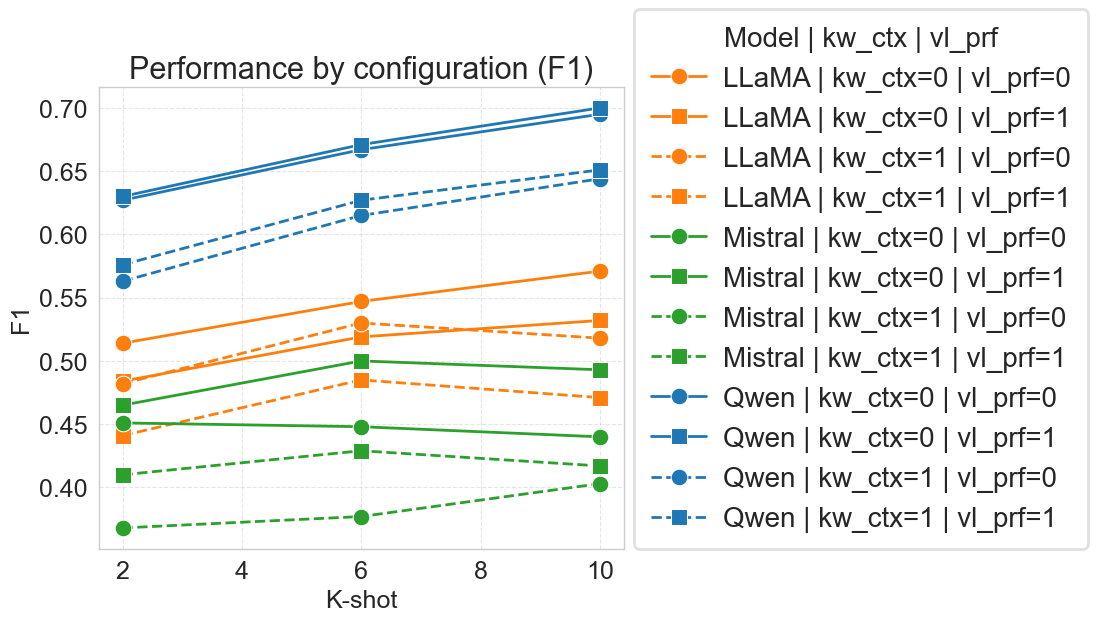

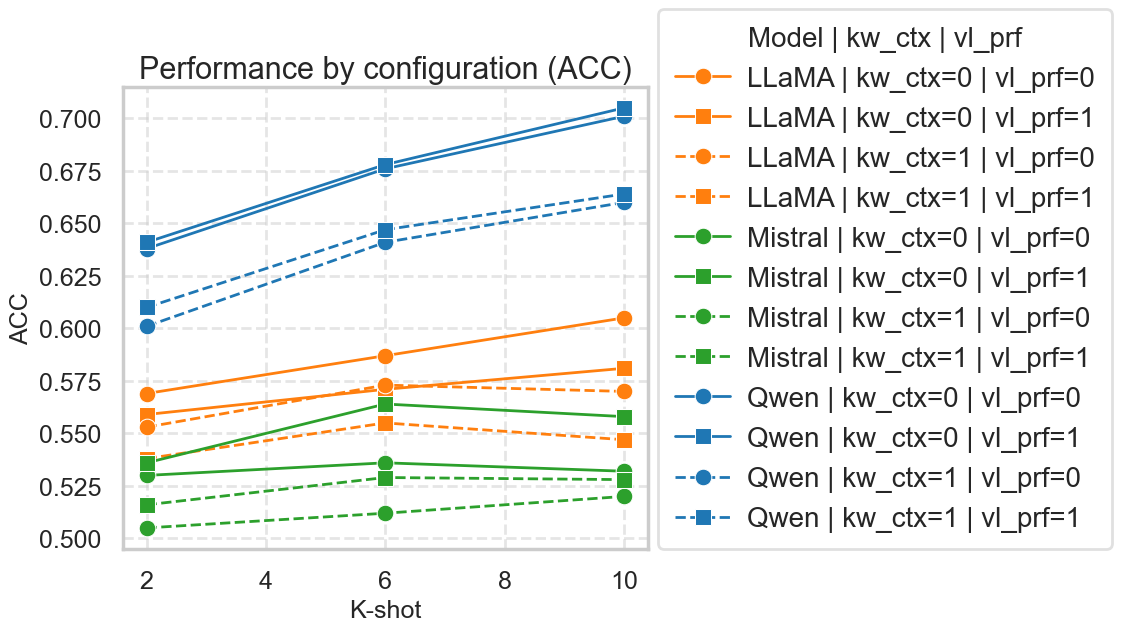

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metrics_trends(df, metric='f1_mean', figsize=(10, 6)):
    assert metric in ['f1_mean', 'acc_mean'], "Metric must be 'f1_mean' or 'acc_mean'"

    models = df['model'].unique()
    kw_contexts = df['kw_context'].unique()  # 0/1
    vl_props = df['vl_propform'].unique()    # 0/1

    tab10 = sns.color_palette("tab10")
    palette = {
        "Qwen":   tab10[0],  # 蓝
        "Mistral":tab10[2],  # 绿
        "LLaMA":  tab10[1],  # 橙
    }
    dashes  = dict(zip(kw_contexts, ['solid', 'dashed', 'dotted', 'dashdot']))
    markers = dict(zip(vl_props,   ['o', 's', '^', 'D', 'P', '*']))

    # 关键：用 fig, ax 并提前给右侧留白
    fig, ax = plt.subplots(figsize=figsize)
    fig.subplots_adjust(right=0.65)  # 挪出右侧 ~22% 空间放 legend

    for model in models:
        for kw_ctx in kw_contexts:
            for vl_prop in vl_props:
                subset = df[(df['model'] == model) &
                            (df['kw_context'] == kw_ctx) &
                            (df['vl_propform'] == vl_prop)]
                if subset.empty:
                    continue
                label = f"{model} | kw_ctx={kw_ctx} | vl_prf={vl_prop}"
                sns.set_style("whitegrid")
                sns.set_context("poster", font_scale=1.2)
                sns.lineplot(
                    data=subset, x='k-shot', y=metric, ax=ax,
                    label=label,
                    color=palette.get(model, 'gray'),
                    linestyle=dashes[kw_ctx],
                    marker=markers[vl_prop],
                    markersize=12, linewidth=2
                )

    ax.set_title(f'Performance by configuration ({metric.replace("_mean", "").upper()})', fontsize=22)
    ax.set_xlabel('K-shot', fontsize=18)
    ax.set_ylabel(metric.replace('_mean', '').upper(), fontsize=18)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(axis='both', labelsize=18)

    # 关键：legend 放轴外右下，并半透明
    leg = ax.legend(
        title='Model | kw_ctx | vl_prf',
        loc='lower left',                 # 以 legend 左下角为锚
        bbox_to_anchor=(1.02, 0.0),       # 轴外右下
        fontsize=20, title_fontsize=20,
        framealpha=0.6, facecolor='white',
        borderaxespad=0.0, handlelength=2.0, handletextpad=0.6, borderpad=0.6
    )

    # 保存时不要让 bbox_inches 把右侧挤回去；保留就行
    fig.savefig(f'otpt/{metric}_trends.pdf', format='pdf', bbox_inches='tight')
    plt.show()
# Call:
plot_metrics_trends(metrics_by_model_shot_context, metric='f1_mean')
plot_metrics_trends(metrics_by_model_shot_context, metric='acc_mean')

<!-- extract all best results for each model -->

In [81]:
qwen_best = results[(results['model'] == 'Qwen') & (results['k-shot'] == 10) & (results['kw_context'] == 0) & (results['vl_propform'] == 1)]
llama_best = results[(results['model'] == 'LLaMA') & (results['k-shot'] == 10) & (results['kw_context'] == 0) & (results['vl_propform'] == 0)]
mistral_best = results[(results['model'] == 'Mistral') & (results['k-shot'] == 10) & (results['kw_context'] == 0) & (results['vl_propform'] == 1)]
results_best = pd.concat([qwen_best, mistral_best, llama_best], axis=0)

## 3. Par les targets (LF ciblées) triés

In [82]:
def calculate_metrics_by_model_kshot_target(df, true_col='expected', pred_col='response', model_col='model', kshot_col='k-shot', target_col='target', repeat_col='repeat_num',context_col='kw_context', propform_col='vl_propform', scope_col='scope_id', decimal_places=3):
    
    results_list = []

    for (model, kshot, target, scope, kw_context, vl_propform), group in df.groupby([model_col, kshot_col, target_col, scope_col, context_col, propform_col]):
        metrics = {
            'model': model,
            'k-shot': kshot,
            'target': target,
            'scope_id': scope,
            'kw_context': kw_context,
            'vl_propform': vl_propform
        }
        
        acc_values, prec_values, rec_values, f1_values = [], [], [], []
        
        for repeat in sorted(group[repeat_col].unique()):
            repeat_group = group[group[repeat_col] == repeat]
            
            if len(repeat_group) < 2 or repeat_group[true_col].nunique() < 2:
                continue
                
            acc = accuracy_score(repeat_group[true_col], repeat_group[pred_col])
            prec = precision_score(repeat_group[true_col], repeat_group[pred_col], average='weighted', zero_division=0)
            rec = recall_score(repeat_group[true_col], repeat_group[pred_col], average='weighted', zero_division=0)
            f1 = f1_score(repeat_group[true_col], repeat_group[pred_col], average='weighted', zero_division=0)
            
            acc_values.append(acc)
            prec_values.append(prec)
            rec_values.append(rec)
            f1_values.append(f1)
        
        if not acc_values:
            continue
        
        # aggregate metrics across repeats
        metrics.update({
            'acc_mean': round(np.mean(acc_values), decimal_places),
            'prec_mean': round(np.mean(prec_values), decimal_places),
            'rec_mean': round(np.mean(rec_values), decimal_places),
            'f1_mean': round(np.mean(f1_values), decimal_places),
            'var_by_acc': round(np.var(acc_values), 6),
            'var_by_f1': round(np.var(f1_values), 6)
        })
        
        results_list.append(metrics)
    
    results_df = pd.DataFrame(results_list)

    column_order = ['model', 'k-shot', 'target', 'scope_id', 'kw_context', 'vl_propform', 'acc_mean', 'prec_mean', 'rec_mean', 'f1_mean', 'var_by_acc', 'var_by_f1']
    results_df = results_df[column_order]
    
    return results_df.sort_values(['model', 'k-shot', 'target', 'acc_mean'], ascending=[True, True, True, False])


# Example call
metrics_by_model_kshot_target = calculate_metrics_by_model_kshot_target(
    df=results_best, 
    repeat_col='repeat_num',  
    kshot_col='k-shot',  
    target_col='target',
    scope_col='scope_id',
    context_col='kw_context',
    propform_col='vl_propform'
)


display(metrics_by_model_kshot_target)

,model,k-shot,target,scope_id,kw_context,vl_propform,acc_mean,prec_mean,rec_mean,f1_mean,var_by_acc,var_by_f1
1,LLaMA,10,A0,2,0,0,0.73,0.752,0.73,0.714,0.0096,0.014730
0,LLaMA,10,A0,1,0,0,0.62,0.645,0.62,0.587,0.0046,0.010011
3,LLaMA,10,A1,2,0,0,0.63,0.659,0.63,0.602,0.0096,0.013931
5,LLaMA,10,A1,4,0,0,0.63,0.680,0.63,0.600,0.0046,0.010920
2,LLaMA,10,A1,1,0,0,0.57,0.617,0.57,0.520,0.0046,0.010633
...,...,...,...,...,...,...,...,...,...,...,...,...
742,Qwen,10,Verbes_de_phase,2,0,1,0.84,0.864,0.84,0.837,0.0004,0.000391
743,Qwen,10,Verbes_de_phase,3,0,1,0.82,0.841,0.82,0.817,0.0006,0.000566
746,Qwen,10,Vreal,3,0,1,0.71,0.817,0.71,0.682,0.0014,0.002416
744,Qwen,10,Vreal,1,0,1,0.62,0.760,0.62,0.562,0.0006,0.001197


In [83]:
from sklearn.metrics import accuracy_score
import pandas as pd

def calculate_group_accuracy(
    df,
    true_col='expected',
    pred_col='response',
    group_cols=['model', 'k-shot', 'target', 'scope_id', 'kw_context', 'vl_propform', 'Q_type'],
    decimal_places=3
):
    results = []

    for keys, group in df.groupby(group_cols):
        acc = accuracy_score(group[true_col], group[pred_col])

        result = dict(zip(group_cols, keys))
        result['acc'] = round(acc, decimal_places)

        results.append(result)

    results_df = pd.DataFrame(results)
    return results_df.sort_values(['model', 'k-shot', 'target', 'acc'], ascending=[True, True, True, False])

# Example call
group_accuracy_df = calculate_group_accuracy(
    df=results_best,
    true_col='expected',
    pred_col='response',
    group_cols=['model', 'k-shot', 'target', 'scope_id', 'kw_context', 'vl_propform', 'Q_type']
)
display(group_accuracy_df)

,model,k-shot,target,scope_id,kw_context,vl_propform,Q_type,acc
3,LLaMA,10,A0,2,0,0,Q_pos,0.80
1,LLaMA,10,A0,1,0,0,Q_pos,0.72
2,LLaMA,10,A0,2,0,0,Q_neg,0.66
0,LLaMA,10,A0,1,0,0,Q_neg,0.52
9,LLaMA,10,A1,3,0,0,Q_pos,0.76
...,...,...,...,...,...,...,...,...
1488,Qwen,10,Vreal,1,0,1,Q_neg,0.98
1490,Qwen,10,Vreal,2,0,1,Q_neg,0.48
1491,Qwen,10,Vreal,2,0,1,Q_pos,0.46
1493,Qwen,10,Vreal,3,0,1,Q_pos,0.42


In [84]:
group_accuracy_df.to_csv('otpt/group_accuracy.csv', index=False)

In [85]:
# Split into separate DataFrames by params
dataframes_by_model_kshot = {}
for (model, kshot, kw_ctx, vlprop), group in metrics_by_model_kshot_target.groupby(['model', 'k-shot', 'kw_context', 'vl_propform']):
    key = f"{model}_k={kshot}_kw_ctx={bool(kw_ctx)}_vlprop={bool(vlprop)}"
    dataframes_by_model_kshot[key] = group

# Example: Access a specific DataFrame
# for key, df in dataframes_by_model_kshot.items():
#     print(f"DataFrame for {key}:")
#     display(df.sort_values('acc_mean', ascending=False))

In [86]:
def plot_model_performance_by_config(df, model_name, k_shot=None, kw_context=None, vl_propform=None,
                                     metric='f1_mean', var_metric='var_by_f1', top_n=15, figsize=(20, 8)):
    """
    Plots the performance of a model for different targets, filtered by configuration.
    Shows top and bottom N targets in a single chart.
    
    Parameters:
    - df: DataFrame from calculate_metrics_by_model_kshot_target
    - model_name: Name of the model to plot
    - k_shot: k-shot value to filter (None for all values)
    - kw_context: kw_context value to filter (None for all values)
    - vl_propform: vl_propform value to filter (None for all values)
    - metric: 'f1_mean' or 'acc_mean'
    - var_metric: 'var_by_f1' or 'var_by_acc'
    - top_n: Number of top and bottom targets to display
    - figsize: Size of the figure
    """
    assert metric in ['f1_mean', 'acc_mean'], "Invalid metric. Choose 'f1_mean' or 'acc_mean'."
    assert var_metric in ['var_by_f1', 'var_by_acc'], "Invalid variance metric."

    # Filter data for the specified model and config
    filtered_df = df[df['model'] == model_name].copy()
    
    if k_shot is not None:
        filtered_df = filtered_df[filtered_df['k-shot'] == k_shot]
    if kw_context is not None:
        filtered_df = filtered_df[filtered_df['kw_context'] == kw_context]
    if vl_propform is not None:
        filtered_df = filtered_df[filtered_df['vl_propform'] == vl_propform]
    
    # Create config title string for plot
    config_str = f"model={model_name}"
    if k_shot is not None:
        config_str += f", k-shot={k_shot}"
    if kw_context is not None:
        config_str += f", kw_ctx={kw_context}"
    if vl_propform is not None:
        config_str += f", vl_pf={vl_propform}"
    
    # Group by target and aggregate
    agg_df = filtered_df.groupby('target')[[metric, var_metric]].mean().reset_index()
    
    # Check if we have enough data
    if len(agg_df) == 0:
        print(f"No data for configuration: {config_str}")
        return
    
    # If we have fewer targets than 2*top_n, adjust top_n
    available_targets = len(agg_df)
    if available_targets < 2 * top_n:
        top_n = available_targets // 2
        if top_n == 0:
            top_n = 1
        print(f"Adjusted top_n to {top_n} due to limited targets ({available_targets} available)")
    
    # Rank and split into top/bottom
    top_targets = agg_df.nlargest(top_n, metric)
    bottom_targets = agg_df.nsmallest(top_n, metric).sort_values(metric, ascending=False)
    
    # Combine top and bottom targets with adjusted x positions
    top_targets['x_pos'] = range(1, top_n + 1)  # Left side
    bottom_targets['x_pos'] = range(top_n + 2, 2 * top_n + 2)  # Right side
    
    # Combine the two datasets
    combined_targets = pd.concat([top_targets, bottom_targets], axis=0)
    # Define colors based on model name
    model_colors = {'Qwen': 'tab:blue', 'meta-llama': 'tab:green', 'mistralai': 'tab:orange'}
    bar_color = model_colors.get(model_name, 'tab:blue') 
    
    # Plot
    plt.figure(figsize=figsize)
    
    # Calculate yerr with a cap to avoid overly large error bars
    yerr = np.sqrt(combined_targets[var_metric])
    yerr = np.minimum(yerr, combined_targets[metric] * 0.5)  # Cap the error bar to 50% of the bar height
    
    # Bar plot
    bars = plt.bar(combined_targets['x_pos'], combined_targets[metric], yerr=yerr, capsize=4, alpha=0.8, 
             color=bar_color)
    
    # Add a dashed line to separate top and bottom
    plt.axvline(x=top_n + 1.5, color='gray', linestyle='--', linewidth=1)
    
    # Add text labels for top and bottom
    plt.text(top_n // 2, max(combined_targets[metric]) * 1.05, "TOP TARGETS", 
             horizontalalignment='center', fontweight='bold', color='tab:blue')
    plt.text(top_n + top_n // 2 + 2, max(combined_targets[metric]) * 1.05, "BOTTOM TARGETS", 
             horizontalalignment='center', fontweight='bold', color='tab:orange')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.03,
                f'{height:.2f}', ha='center', va='bottom', fontsize=10, rotation=0)
    
    # Add labels and title
    plt.xticks(combined_targets['x_pos'], combined_targets['target'], rotation=45, ha='right', fontsize=12)
    plt.ylabel(metric.replace('_mean', '').upper())
    plt.title(f'Target Performance for {config_str}\nMetric: {metric.replace("_mean", "").upper()}:', fontsize=16)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5) # To show the separation between top and bottom
    plt.ylim(0, max(combined_targets[metric]) * 1.15)  # Add some space at the top for labels
    
    # Show the plot
    plt.show()

🔍 Generating plot for: model=Qwen, k=10, kw_context=False, vl_propform=True


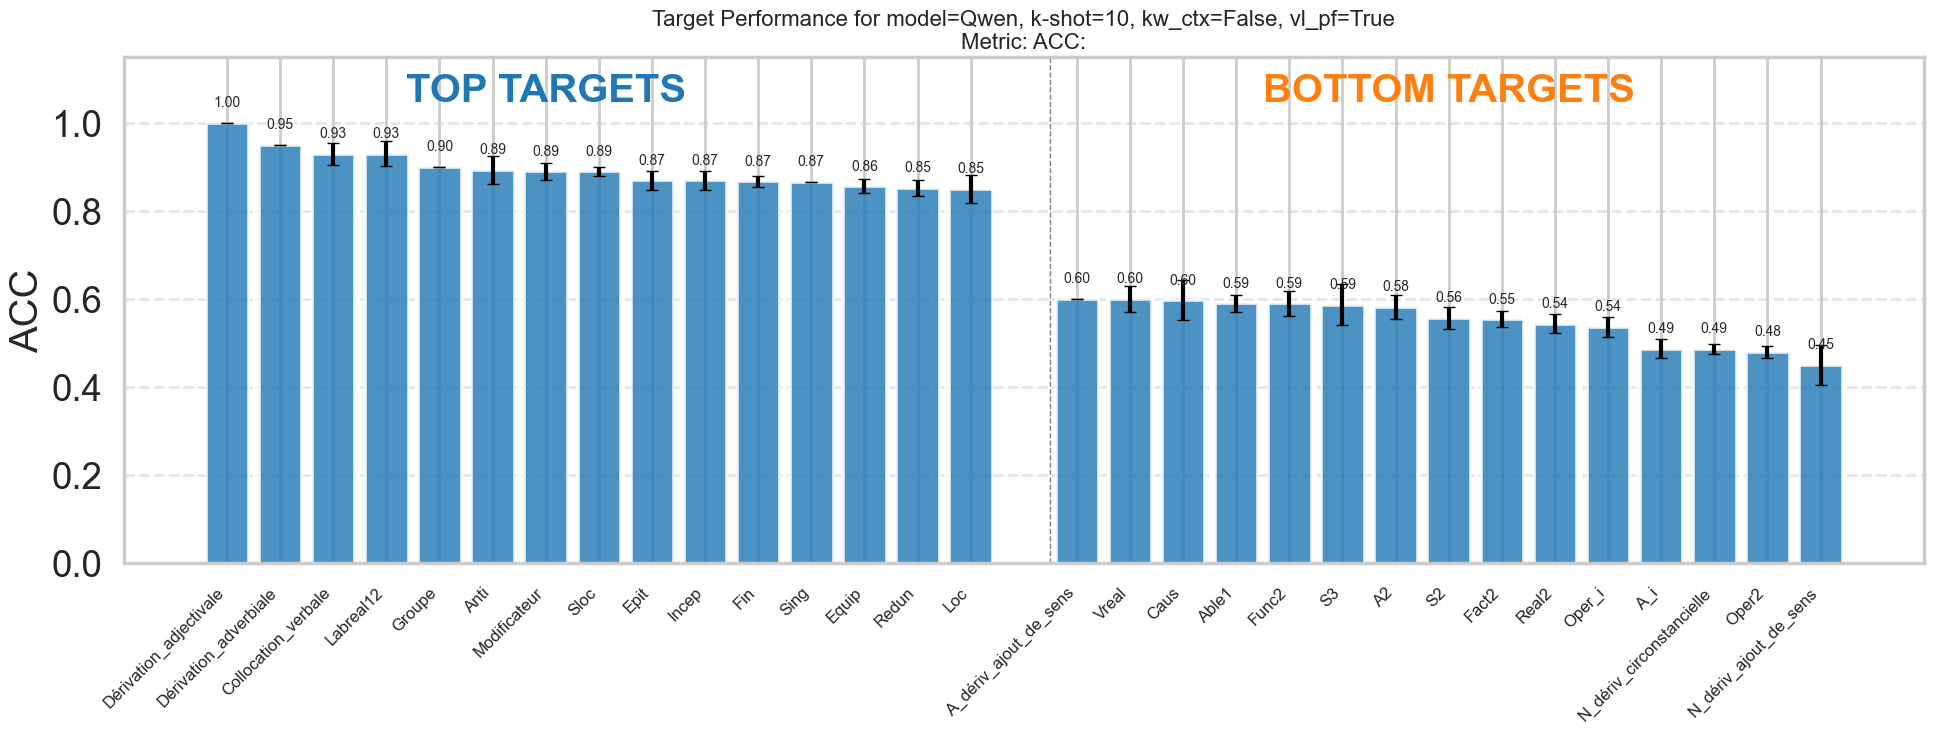

In [87]:
# Generate plot for a specific model and configuration
def generate_performance_plot(df, model, k_shot=2, kw_context=False, vl_propform=False, metric='acc_mean'):
    print(f"🔍 Generating plot for: model={model}, k={k_shot}, kw_context={kw_context}, vl_propform={vl_propform}")
    plot_model_performance_by_config(
        df=df,
        model_name=model,
        k_shot=k_shot,
        kw_context=kw_context,
        vl_propform=vl_propform,
        metric=metric,
        var_metric='var_by_f1' if metric == 'f1_mean' else 'var_by_acc',
        top_n=15
    )


generate_performance_plot(metrics_by_model_kshot_target, model='Qwen', k_shot=10, kw_context=False, vl_propform=True, metric='acc_mean')

Comme nous avons, pour chaque FL ciblé, plusieurs scopes de contrastes échatillonnés, ça vaut la peine de voir leur performance tout au long de différents scopes, en regardant la meilleure configuration de paramètre:

* Qwem : ctx=0, vfp=1, k=10
* mistralai : ctx=0, vfp=1, k=10
* meta-llama : ctx=0, vfp=0, k=10

In [88]:
qwen_best = metrics_by_model_kshot_target[(metrics_by_model_kshot_target['model'] == 'Qwen') & (metrics_by_model_kshot_target['k-shot'] == 10) & (metrics_by_model_kshot_target['kw_context'] == 0) & (metrics_by_model_kshot_target['vl_propform'] == 1)]
llama_best = metrics_by_model_kshot_target[(metrics_by_model_kshot_target['model'] == 'LLaMA') & (metrics_by_model_kshot_target['k-shot'] == 10) & (metrics_by_model_kshot_target['kw_context'] == 0) & (metrics_by_model_kshot_target['vl_propform'] == 0)]
mistral_best = metrics_by_model_kshot_target[(metrics_by_model_kshot_target['model'] == 'Mistral') & (metrics_by_model_kshot_target['k-shot'] == 10) & (metrics_by_model_kshot_target['kw_context'] == 0) & (metrics_by_model_kshot_target['vl_propform'] == 1)]
data_best = pd.concat([qwen_best, mistral_best, llama_best], axis=0)
data_best.value_counts('scope_id').sort_values(ascending=False).head(10)

scope_id
1    246
2    219
3    165
4     90
5     27
Name: count, dtype: int64

## variant perform across targets

In [89]:
subsample_prdgm = ["Dérivation_adverbiale", "Dérivation_adjectivale", "V0",  "S0", "A0", "Sloc", "Adv0", "S_i", "S2", "Qual1"]

subsample_syntgm = ["Colloc_préposition", "Collocation_verbale", "Modificateur", "Ver", "Loc", "Oper2", "Fact_i", "Real2", "Func2"]


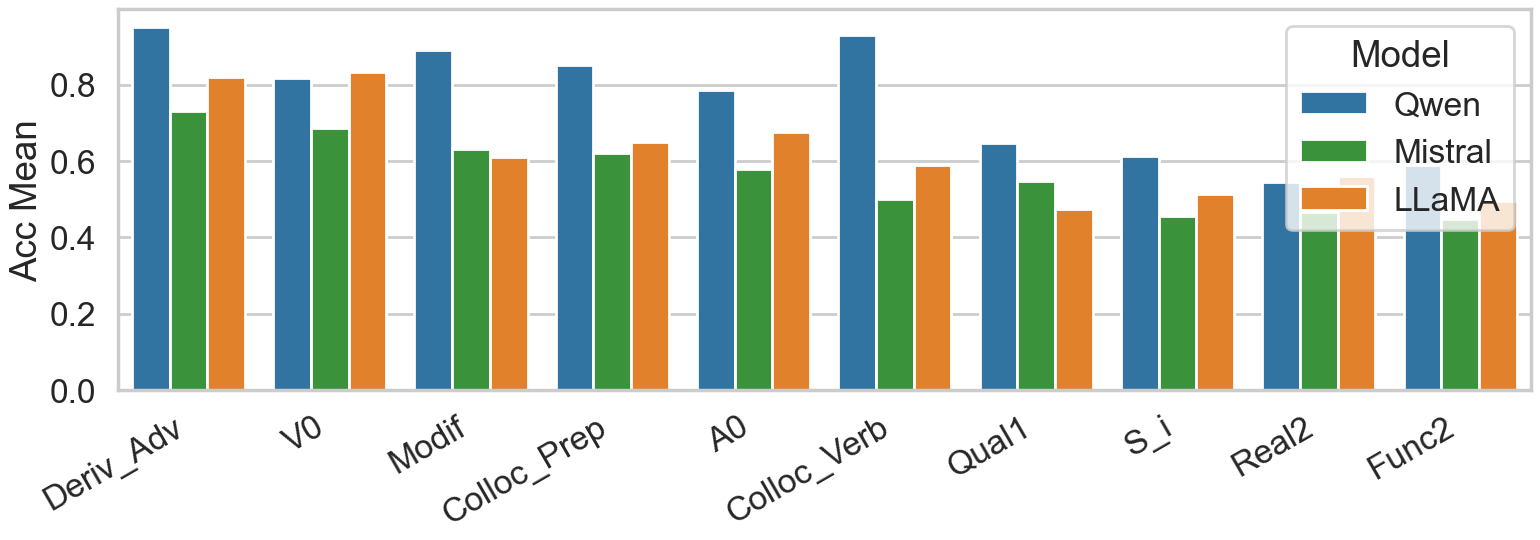

In [100]:
MODEL_PALETTE = {
    "Qwen": "#1f77b4",     # 蓝色
    "LLaMA": "#ff7f0e",    # 橙色
    "Mistral": "#2ca02c"   # 绿色
}

def groupbarplot_by_target(df, model_col="model", target_col="target", metric_col="acc_mean", target_list=None, figsize=(12, 6)):
    """
    绘制分组柱状图：展示不同模型在各 target 上的表现（如 acc_mean）。
    按照所有模型在每个 target 上的平均得分排序 target。
    
    参数：
    - df: 包含模型表现数据的 DataFrame；
    - model_col: 模型名称列名；
    - target_col: 目标类别列名；
    - metric_col: 需要展示的指标列名（如 'acc_mean'）；
    - target_list: 需要展示的目标 target 子集（如为 None 则全部）；
    - figsize: 图像尺寸。
    """
    # 筛选感兴趣的 target
    if target_list:
        df = df[df[target_col].isin(target_list)].copy()
    
    if target_list == subsample_prdgm:
        df[target_col] = df[target_col].replace({
            "Dérivation_adverbiale": "Deriv_Adv",
            "Dérivation_adjectivale": "Deriv_Adj",
            "V0": "V0",
            "Anti": "Anti",
            "S0": "S0",
            "A0": "A0",
            "Able1": "Able1",
            "Sloc": "Sloc",
            "Adv0": "Adv0",
            "S_i": "S_i",
            "S2": "S2",
            "Subst_sens_similaire": "Subst_Sim"
        })
        key = "Paradigmatic"
    elif target_list == subsample_syntgm:
        df[target_col] = df[target_col].replace({
            "Colloc_préposition": "Colloc_Prep",
            "Collocation_verbale": "Colloc_Verb",
            "Modificateur": "Modif",
            "Ver": "Ver",
            "Loc": "Loc",
            "Sing": "Sing",
            "Oper1": "Oper1",
            "Fact_i": "Fact_i",
            "Real2": "Real2",
            "Fin": "Fin",
            "Func2": "Func2",
            "Caus": "Caus",
            "Redun": "Redun"
        })
        key = "Syntagmatic"
    else:
        key = "Sampled LFs"
    df[target_col] = df[target_col].replace({
            "Colloc_préposition": "Colloc_Prep",
            "Collocation_verbale": "Colloc_Verb",
            "Modificateur": "Modif",
            "Ver": "Ver",
            "Loc": "Loc",
            "Sing": "Sing",
            "Oper1": "Oper1",
            "Fact_i": "Fact_i",
            "Real2": "Real2",
            "Fin": "Fin",
            "Func2": "Func2",
            "Caus": "Caus",
            "Redun": "Redun",
            "Dérivation_adverbiale": "Deriv_Adv",
            "Dérivation_adjectivale": "Deriv_Adj",
            "V0": "V0",
            "Anti": "Anti",
            "S0": "S0",
            "A0": "A0",
            "Able1": "Able1",
            "Sloc": "Sloc",
            "Adv0": "Adv0",
            "S_i": "S_i",
            "S2": "S2",
            "Subst_sens_similaire": "Subst_Sim"
        })

    # 计算每个 target 的整体平均值用于排序
    target_order = df.groupby(target_col)[metric_col].mean().sort_values(ascending=False).index.tolist()
    

    sns.set(style="whitegrid")
    sns.set_context("poster", font_scale=1.1)
    plt.figure(figsize=figsize)

    # 绘制分组柱状图
    ax = sns.barplot(
        data=df,
        x=target_col,
        y=metric_col,
        hue=model_col,
        order=target_order,
        palette=MODEL_PALETTE,
        errorbar=None,  # 不显示置信区间
    )

    # 图形微调
    plt.xticks(rotation=30, ha="right")
    plt.xlabel("")
    plt.ylabel(metric_col.replace("_", " ").title())
    plt.legend(title="Model")
    plt.tight_layout()
    plt.savefig(f'otpt/sampled_target_barplot_{key}.pdf', format='pdf')
    plt.show()

# Example usage
# for poster :

poster_list = ["Dérivation_adverbiale", "A0", "V0", "Qual1", "S_i", "Colloc_préposition","Modificateur", "Collocation_verbale", "Real2", "Func2"]
groupbarplot_by_target(
    df=data_best,
    model_col="model",
    target_col="target",
    metric_col="acc_mean",
    target_list=poster_list,
    figsize=(16, 6)
)

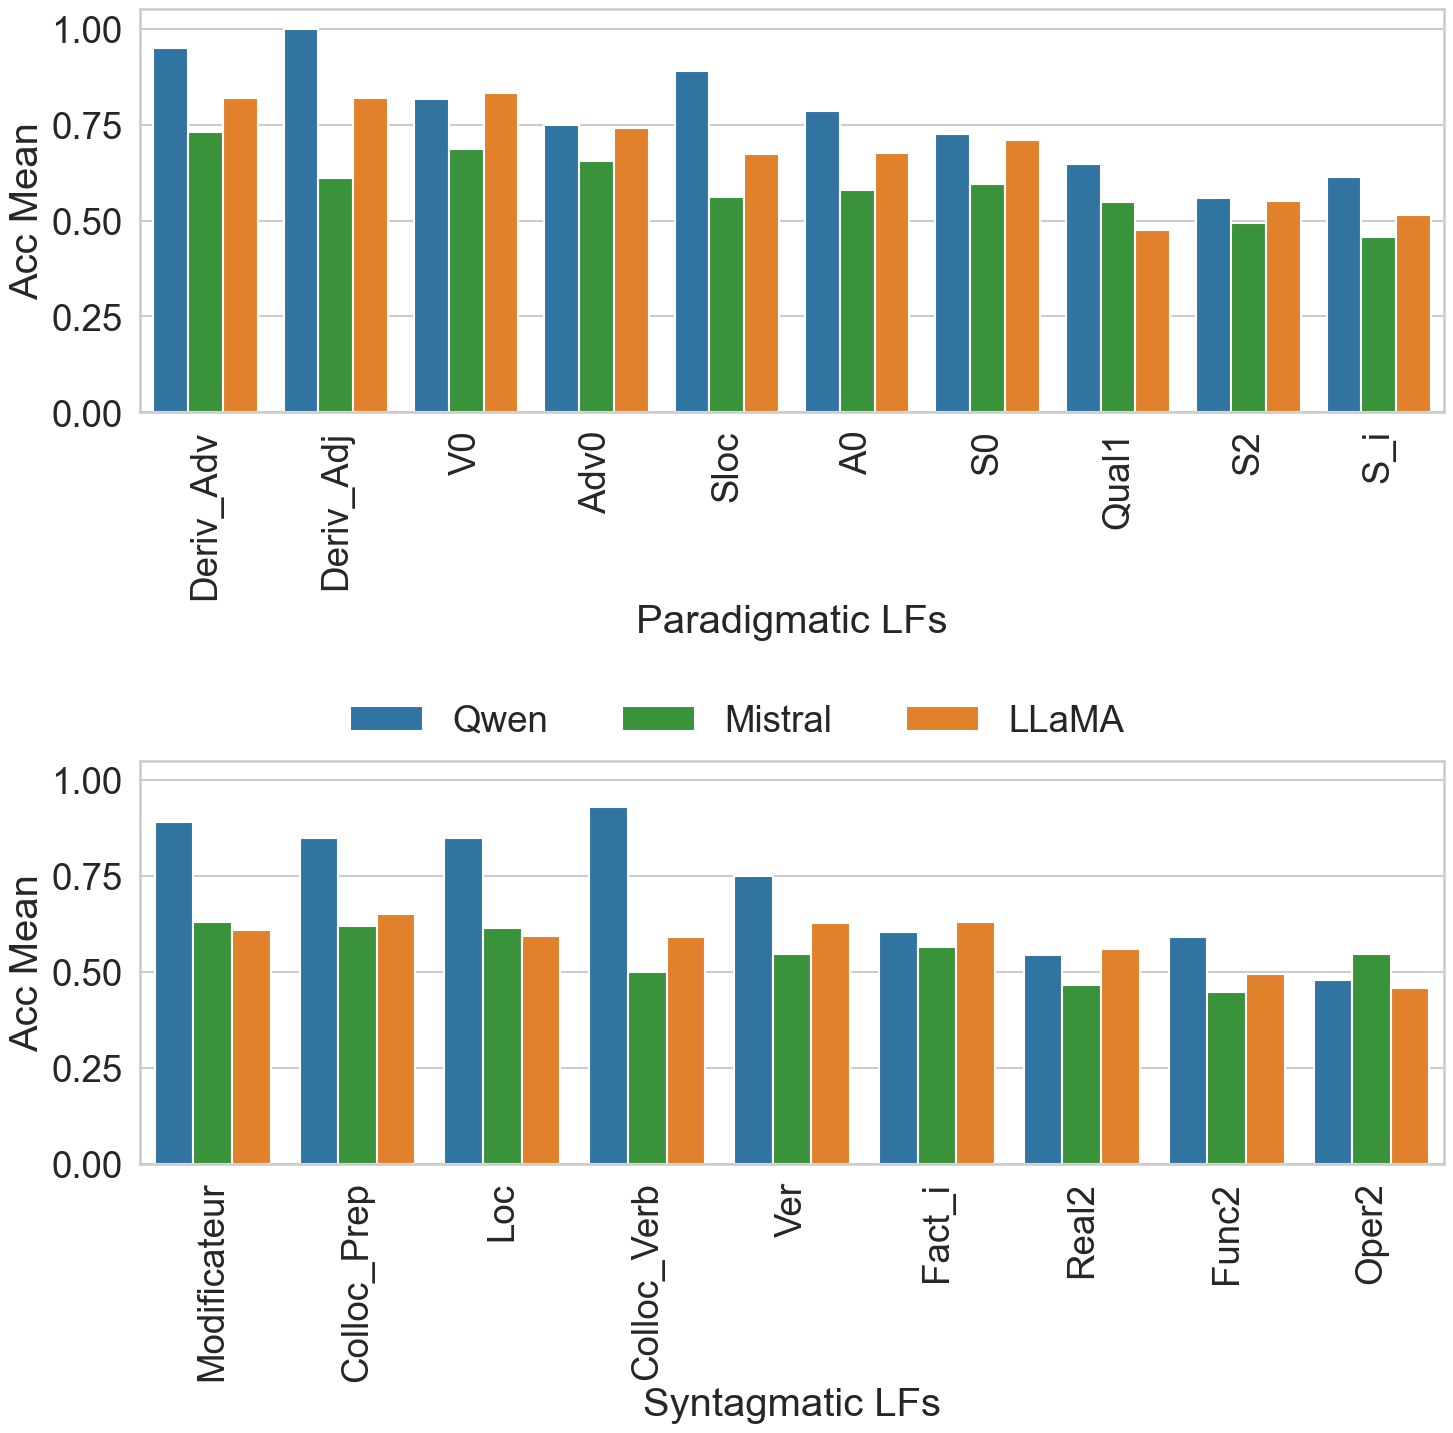

In [101]:
def groupbarplot_stacked(df, model_col="model", target_col="target", metric_col="acc_mean", figsize=(16, 12)):
    sns.set(style="whitegrid")
    sns.set_context("talk", font_scale=1.6)

    fig, axes = plt.subplots(nrows=2, figsize=figsize, sharey=True)

    for ax, target_list, key in zip(axes, [subsample_prdgm, subsample_syntgm], ["Paradigmatic", "Syntagmatic"]):
        df_sub = df[df[target_col].isin(target_list)].copy()

        # 可选替换 target 名称（缩短）
        if key == "Paradigmatic":
            df_sub[target_col] = df_sub[target_col].replace({
                "Dérivation_adverbiale": "Deriv_Adv",
                "Dérivation_adjectivale": "Deriv_Adj",
                "Subst_sens_similaire": "Subst_Sim"
            })
        else:
            df_sub[target_col] = df_sub[target_col].replace({
                "Colloc_préposition": "Colloc_Prep",
                "Collocation_verbale": "Colloc_Verb"
            })

        target_order = df_sub.groupby(target_col)[metric_col].mean().sort_values(ascending=False).index.tolist()

        sns.barplot(
            data=df_sub,
            x=target_col,
            y=metric_col,
            hue=model_col,
            order=target_order,
            palette=MODEL_PALETTE,
            errorbar=None,
            ax=ax
        )
        ax.set_xlabel(f"{key} LFs")
        ax.set_ylabel(metric_col.replace("_", " ").title())
        ax.tick_params(axis='x', rotation=90)
        ax.get_legend().remove()

    fig.legend(
        handles=axes[0].get_legend_handles_labels()[0],
        labels=axes[0].get_legend_handles_labels()[1],
        loc='upper center',
        bbox_to_anchor=(0.5, 0.53),  # y≈0.53 控制上下居中，x=0.5表示水平居中
        ncol=3,  # 横排
        frameon=False,
    )
    plt.tight_layout(h_pad=3)  # 增加子图之间的距离
    plt.savefig(f'otpt/sampled_barplot.pdf', format='pdf', bbox_inches='tight')
    plt.show()

# Example usage
groupbarplot_stacked(
    df=data_best,
    model_col="model",
    target_col="target",
    metric_col="acc_mean",
    figsize=(15, 15)
)

## Effet de scope

In [102]:
def plot_scope_trend_separate(df, metric='acc_mean', scope_counts=[2, 3, 4, 5]):
    """
    为每个指定的 scope 个数画一张独立折线图，横轴为 depth，展示不同模型的均值表现。
    横轴顺序始终按数字从小到大排序。
    """
    target_scope_counts = df.groupby('target')['scope_id'].nunique().reset_index()
    target_scope_counts = target_scope_counts.rename(columns={'scope_id': 'scope_count'})
    df = df.merge(target_scope_counts, on='target', how='left')
    palette = dict(zip(models, sns.color_palette("tab10", len(models))))

    # 转为字符串 & 排序
    df['scope_id'] = pd.to_numeric(df['depth'], errors='coerce')  # 先转数字保证排序正确
    df = df.dropna(subset=['depth'])  # 删除非法scope
    df['depth'] = df['depth'].astype(int).astype(str)  # 再转回字符串
    scope_order = sorted(df['depth'].unique(), key=lambda x: int(x))
    df['depth'] = pd.Categorical(df['depth'], categories=scope_order, ordered=True)

    for count in scope_counts:
        subset = df[df['scope_count'] == count]
        if subset.empty:
            continue

        plt.figure(figsize=(8, 5))
        sns.set_context("paper", font_scale=1.2)

        sns.lineplot(
            data=subset,
            x='depth',
            y=metric,
            palette=palette,
            hue='model',
            errorbar=None,
            marker='o'
        )
        plt.title(f"{metric.replace('_mean', '').upper()} Trend for Targets with {count} Scopes")
        plt.xlabel("Depth (from root to target's sibling)")
        plt.xticks(rotation=45)
        plt.ylabel(metric.replace('_mean', '').upper())
        plt.ylim(0.4, 0.9)
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.savefig(f'otpt/{metric}_trend_{count}_depth.pdf', format='pdf', bbox_inches='tight')
        plt.show()
# Example call
# plot_scope_trend_separate(data_best, metric='acc_mean', scope_counts=[2, 3, 4, 5])

In [103]:
data_best.head()

,model,k-shot,target,scope_id,kw_context,vl_propform,acc_mean,prec_mean,rec_mean,f1_mean,var_by_acc,var_by_f1
499,Qwen,10,A0,2,0,1,0.80,0.812,0.80,0.798,0.0000,0.000000
498,Qwen,10,A0,1,0,1,0.77,0.790,0.77,0.766,0.0006,0.000693
501,Qwen,10,A1,2,0,1,0.85,0.885,0.85,0.847,0.0000,0.000000
500,Qwen,10,A1,1,0,1,0.75,0.775,0.75,0.744,0.0000,0.000000
503,Qwen,10,A1,4,0,1,0.70,0.738,0.70,0.688,0.0000,0.000000


In [104]:
def plot_scope_trend_separate(df, metric='acc_mean', target_name=None, scope_counts=[2, 3, 4, 5]):
    """
    为每个指定的 scope 个数画一张独立折线图，横轴为 scope_id，展示不同模型的均值表现。
    横坐标顺序按 scope 从大到小排序，横坐标标签改为深度。
    """
    target_scope_counts = df.groupby('target')['scope_id'].nunique().reset_index()
    target_scope_counts = target_scope_counts.rename(columns={'scope_id': 'scope_count'})
    df = df.merge(target_scope_counts, on='target', how='left')
    palette = dict(zip(models, sns.color_palette("tab10", len(models))))

    # 转为字符串 & 排序
    df['scope_id'] = pd.to_numeric(df['scope_id'], errors='coerce')  # 先转数字保证排序正确
    df = df.dropna(subset=['scope_id'])  # 删除非法scope
    df['scope_id'] = df['scope_id'].astype(int).astype(str)  # 再转回字符串
    scope_order = sorted(df['scope_id'].unique(), key=lambda x: int(x), reverse=True)  # 从大到小排序
    df['scope_id'] = pd.Categorical(df['scope_id'], categories=scope_order, ordered=True)

    # 将横坐标标签改为深度
    depth_labels = [f"Depth {i}" for i in range(1, len(scope_order) + 1)]

    for count in scope_counts:
        subset = df[df['scope_count'] == count]
        if subset.empty:
            continue

        plt.figure(figsize=(8, 5))

        sns.lineplot(
            data=subset,
            x='scope_id',
            y=metric,
            palette=palette,
            hue='model',
            errorbar=None,
            marker='o'
        )
        plt.title(f"{metric.replace('_mean', '').upper()} Trend for Targets with {count} Scopes")
        plt.xlabel("Depth")
        plt.ylabel(metric.replace('_mean', '').upper())
        plt.xticks(ticks=range(len(scope_order)), labels=depth_labels, rotation=45)
        plt.ylim(0.4, 0.9)
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.savefig(f'otpt/{metric}_trend_{count}_scopes.pdf', format='pdf', bbox_inches='tight')
        plt.show()

# Call 
# plot_scope_trend_separate(data_best, metric='acc_mean', scope_counts=[2, 3, 4, 5])


In [105]:
def plot_depth_trend_by_target(df, target_names, metric='acc_mean'):
    """
    针对每个指定的 target_name，画一张 depth 趋势折线图，横轴为 depth，展示不同模型的均值表现。
    target_names: list[str]，要画图的目标 target 名称列表。
    """
    df = df.copy()
    palette = dict(zip(models, sns.color_palette("tab10", len(models))))

    # 清洗 depth 字段为有序分类
    df = df.dropna(subset=['scope_id'])  # 删除非法 depth
    df['scope_id'] = pd.to_numeric(df['scope_id'], errors='coerce').astype(int)
    scope_order = sorted(df['depth'].unique())
    df['scope_id'] = pd.Categorical(df['scope_id'], categories=scope_order, ordered=True)

    for target in target_names:
        subset = df[df['target'] == target]
        if subset.empty:
            continue

        plt.figure(figsize=(6, 4))  # 更紧凑
        sns.set_context("paper", font_scale=1.2)
        sns.lineplot(
            data=subset,
            x='scope_id',
            y=metric,
            palette=MODEL_PALETTE,
            hue='model',
            errorbar=None,
            marker='o'
        )
        plt.title(f"{metric.replace('_mean', '').upper()} Trend — {target}")
        plt.xlabel("Scope")
        plt.ylabel(metric.replace('_mean', '').upper())
        plt.xticks(rotation=45)
        plt.ylim(-0.1, 1.1)
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.savefig(f'otpt/scope_effect_by_target/{metric}_trend_{target}_scope.pdf', format='pdf', bbox_inches='tight')
        # plt.show()

# Example call
# targets = data_best['target'].unique().tolist()
# plot_depth_trend_by_target(data_best, target_names=targets, metric='acc_mean')

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_model_scope_bars(df, metric='f1_mean', title=None):
    if df.empty:
        print("传入的数据为空")
        return

    base_colors = {
        'Qwen': sns.light_palette("#1f77b4", n_colors=10, reverse=True).as_hex(),
        'mistralai': sns.light_palette("#ff7f0e", n_colors=10, reverse=True).as_hex(),
        'meta-llama': sns.light_palette("#2ca02c", n_colors=10, reverse=True).as_hex()
    }

    df = df.copy()

    # 排序 scope 从大到小
    df['scope_id'] = pd.to_numeric(df['scope_id'], errors='coerce')
    df = df.sort_values(['model', 'scope_id'], ascending=[True, False])

    # 创建 x 轴标签
    df['x'] = df['model'] + '\nscope=' + df['scope_id'].astype(int).astype(str)

    # 为每个 model 分配颜色（越靠前的 scope_id 颜色越深）
    def assign_color(row):
        color_list = base_colors.get(row['model'], ['gray'])
        model_df = df[df['model'] == row['model']]
        scope_list = sorted(model_df['scope_id'].unique(), reverse=True)
        idx = scope_list.index(row['scope_id'])
        return color_list[min(idx, len(color_list)-1)]

    df['color'] = df.apply(assign_color, axis=1)

    # 绘图
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df, x='x', y=metric, color=None, palette=None)
    bars = plt.gca().patches
    for bar, color in zip(bars, df['color']):
        bar.set_facecolor(color)

    if not title:
        title = f"{metric.replace('_mean', '').upper()} by Model & Scope"
    plt.title(title)
    plt.ylabel(metric.replace('_mean', '').upper())
    plt.xlabel("")
    plt.ylim(0, min(1.0, df[metric].max() * 1.1))
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
# grouped = differ_targets_by_scopes_max(data_best)  # 返回的是 {scope_count: df_subset}

# for scope_count, subdf in grouped.items():
#     plot_model_scope_bars(subdf, metric='acc_mean', title=f"{scope_count} scopes per target")

#### Remarques : 

Ce plot ci-dessus donne seulement un aperçu général de la variation des performances entre les différents targets pour une configuration donnée du modèle. Or, notre tâche consiste à analyser les performances sous l’angle de la granularité, c’est-à-dire à examiner la performance d’un target par rapport à ses contrastes.

## 4. De Superclass à subclass, en comparant les modèles
### Mapping 
Superclass : [les subclass]

In [107]:
import json
lfs_structure_file = '../data/raw/lfs-structure-v3.json'
with open(lfs_structure_file, 'r') as f:
    lfs_structure = json.load(f)

# get subnodes by node
def get_subnodes(jn: dict, current_key='root') -> dict:
    mapping = {}
    if isinstance(jn, dict):
        for k, v in jn.items():
            if isinstance(v, dict):
                # If this node has "éléments", add it to mapping
                if "éléments" in v:
                    mapping[k] = list(v["éléments"].keys())
                
                # Recursively explore deeper levels
                sub_mapping = get_subnodes(v, k)
                mapping.update(sub_mapping)
    return mapping

# get subnodes by node
node_subnodes = get_subnodes(lfs_structure)
node_mapping_file = "../data/processed/lfs-structure-5_nodes_filtrated.json"
with open(node_mapping_file, 'r') as f:
    lfs_contents=json.load(f)
    
filtered_node_subnodes = {}
for k, v in node_subnodes.items():
    # Check if there's at least one target in v that exists in lfs_contents
    valid_targets = [target for target in v if target in lfs_contents]
    if valid_targets:  # If there are valid targets, keep this node
        filtered_node_subnodes[k] = valid_targets

# Replace original node_subnodes with filtered version
node_subnodes = filtered_node_subnodes

print(f"Number of nodes after filtering: {len(node_subnodes)}")
print("Nodes with valid targets:", list(node_subnodes.keys()))


Number of nodes after filtering: 35
Nodes with valid targets: ['FL_paradigmatiques', 'Substitutive', 'Subst_sens_similaire', 'Subst_sens_opposé', 'Dérivation_nominale', 'N_dériv_ajout_de_sens', 'S_i', 'N_dériv_circonstancielle', 'Dérivation_adjectivale', 'A_dériv_ajout_de_sens', 'A_i', 'A_dériv_qualificative', 'Able_i', 'Dérivation_adverbiale', 'Dérivation_verbale', 'V_dériv_sens_vide', 'Result_i', 'FL_syntagmatiques', 'Modificateur', 'Modif_sens_vide', 'Modif_ajout_de_sens', 'Colloc_préposition', 'Nom_gouverneur', 'Unité', 'Groupe', 'Collocation_verbale', 'Verbe_support', 'Func_i', 'Oper_i', 'V_collocation_ajout_de_sens', 'Vreal', 'Real_i', 'Fact_i', 'Verbes_de_phase', 'Verbes_causatifs']


### Remarques
Ces graph nous montre la performance des subclass dans leurs superclass, en regardant la différence parmi les modèles avec les k-shots distincts

## 5. Granularité : de la racine aux feuilles

In [108]:
def get_paths_by_terminal_node(structure: dict, current_path: str = "root") -> dict:
    """
    This function recursively traverses the JSON structure and collects paths to each terminal node.
    """
    paths = {}
    if isinstance(structure, dict):
        for k, v in structure.items():
            if v == {}:
                paths[k] = current_path + '.' + k
            else:
                # Create a new path for the recursive call to avoid modifying the current path in place
                new_path = current_path + '.' + k
                # Merge the results of the recursive call into the paths dictionary
                paths.update(get_paths_by_terminal_node(v, current_path=new_path))
    return paths

def dedup_ordered(ls: list):
    """Delete duplicated elements from a list without changing their order."""
    seen = set()
    return [x for x in ls if not (x in seen or seen.add(x))] # Genius

def parse_path(path, node_subnodes):
    return [node for node in path.split('.')[:-1] if ((path.split('.')[-1] not in node_subnodes.keys()) and (node not in {'root', 'éléments'}))]

In [109]:
import json
with open('../data/raw/lfs-structure-v3-simplified.json', 'r') as f:
    lfs_structure = json.load(f)
paths_mapping = get_paths_by_terminal_node(lfs_structure)
path_list = [tuple(parse_path(path, node_subnodes)) for path in paths_mapping.values()]  # Convert inner lists to tuples
path_list = dedup_ordered(path_list)  # Deduplicate
path_list = [list(path) for path in path_list]  # Convert back to lists if needed
len(path_list)
path_list

[['FL_paradigmatiques', 'Substitutive', 'Subst_sens_similaire'],
 ['FL_paradigmatiques', 'Substitutive', 'Subst_sens_opposé'],
 ['FL_paradigmatiques', 'Dérivation_nominale'],
 ['FL_paradigmatiques', 'Dérivation_nominale', 'N_dériv_ajout_de_sens', 'S_i'],
 ['FL_paradigmatiques',
  'Dérivation_nominale',
  'N_dériv_ajout_de_sens',
  'N_dériv_circonstancielle'],
 ['FL_paradigmatiques', 'Dérivation_adjectivale'],
 ['FL_paradigmatiques',
  'Dérivation_adjectivale',
  'A_dériv_ajout_de_sens',
  'A_i'],
 ['FL_paradigmatiques',
  'Dérivation_adjectivale',
  'A_dériv_ajout_de_sens',
  'A_dériv_qualificative',
  'Able_i'],
 ['FL_paradigmatiques',
  'Dérivation_adjectivale',
  'A_dériv_ajout_de_sens',
  'A_dériv_qualificative'],
 ['FL_paradigmatiques', 'Dérivation_adverbiale'],
 ['FL_paradigmatiques', 'Dérivation_verbale', 'V_dériv_sens_vide'],
 ['FL_paradigmatiques', 'Dérivation_verbale'],
 ['FL_syntagmatiques', 'Modificateur', 'Modif_sens_vide'],
 ['FL_syntagmatiques', 'Modificateur', 'Modif_aj

FileNotFoundError: [Errno 2] No such file or directory: 'otpt/Branch/LLaMA/f1_mean_branch_"Subst_sens_similaire".pdf'

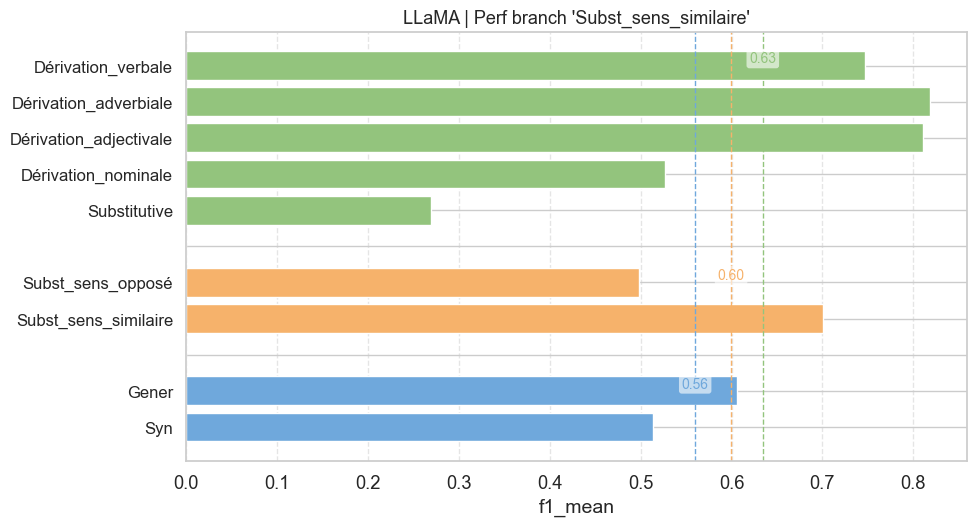

In [110]:
def barplot_path(path_nodes: list, node_sub: dict, data: pd.DataFrame, metric: str = "acc_mean"):
    """
    Path is connected by nodes with '.', now we need to get the metrics for every node's subs.
    Specifically, we extract the score of all subnodes for each node in the path as a group of bars,
    by the order from left to the right. Then we put them into the plot, normally we put all nodes'
    subnodes' scores together and merge them by vertical "--" style.
    """

    bars_labels = []
    bars_scores = []
    group_colors = []
    group_means = []
    group_positions = []

    # Colors (fixed by node level)
    colors = [
        '#6FA8DC',  # soft blue
        '#F6B26B',  # soft orange
        '#93C47D',  # soft green
        '#FFD966',  # soft yellow
        '#8E7CC3',  # soft purple
        '#76A5AF',  # soft teal
        '#C27BA0',  # soft pink
    ]

    current_pos = 0  # Record current cumulative y-axis position
    for i, node in enumerate(path_nodes[::-1]):
        subnodes = node_sub.get(node, [])
        group_scores = []
        group_indices = []

        for sub in subnodes:
            match = data[data['target'] == sub]
            if not match.empty:
                bars_labels.append(sub)
                score = match[metric].values[0]
                bars_scores.append(score)
                group_scores.append(score)
                group_colors.append(colors[i % len(colors)])  # Fixed color by node level
                group_indices.append(current_pos)
                current_pos += 1

        if group_scores:
            group_mean = np.mean(group_scores)
            group_means.append((group_mean, group_indices, colors[i % len(colors)]))

        # Insert empty line
        bars_labels.append("")
        bars_scores.append(0)
        group_colors.append((1, 1, 1, 0))  # Transparent color
        current_pos += 1

    # Remove the last empty separator
    if bars_labels and bars_labels[-1] == "":
        bars_labels.pop()
        bars_scores.pop()
        group_colors.pop()

    # Plotting
    sns.set_theme(style="whitegrid", font_scale=1.2)  # Set theme and font scale
    fig, ax = plt.subplots(figsize=(10, 0.5 * len(bars_labels)))  # Adjust figure size
    y_pos = np.arange(len(bars_labels))
    ax.barh(y_pos, bars_scores, color=group_colors)

    # Adding labels
    ax.set_yticks(y_pos)  # Set y-ticks to match the number of bars
    ax.set_yticklabels(bars_labels, fontsize=12)  # Set font size for labels
    ax.set_xlabel(metric, fontsize=14)
    ax.set_title(f"{data['model'].unique()[0]} | Perf branch '{path_nodes[-1]}'", fontsize=13)

    # Adding mean lines for each group
    for mean_val, indices, color in group_means:
        ax.axvline(mean_val, color=color, linestyle='--', linewidth=1)
        label_y = max(indices)
        ax.text(mean_val, label_y, f"{mean_val:.2f}", color=color, fontsize=10,
                va='bottom', ha='center',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, boxstyle='round,pad=0.2'))

    ax.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f'otpt/Branch/{data["model"].unique()[0]}/{metric}_branch_"{path_nodes[-1]}".pdf', format='pdf', bbox_inches='tight')
    # plt.show()
    plt.close(fig)
# Example usage:
# df_to_display = dataframes_by_model_kshot['Qwen_k=10_kw_ctx=False_vlprop=True']
# df_to_display = df_to_display[df_to_display['scope_id'] == 1].copy()  # Filter for scope_id = 1
paths_mapping = get_paths_by_terminal_node(lfs_structure)
path_list = [tuple(parse_path(path, node_subnodes)) for path in paths_mapping.values()]
path_list = dedup_ordered(path_list)
path_list = [list(path) for path in path_list]
for df in dataframes_by_model_kshot.values():
    df_to_display = df[df['scope_id'] == 1].copy()  # Filter for scope_id = 1
    for path in path_list:
        for mtx in ['f1_mean', 'acc_mean', 'rec_mean', 'prec_mean']:
            barplot_path(path, node_subnodes, df_to_display, metric=mtx)

In [ ]:
print(node_subnodes)

{'FL_paradigmatiques': ['Substitutive', 'Dérivation_nominale', 'Dérivation_adjectivale', 'Dérivation_adverbiale', 'Dérivation_verbale'], 'Substitutive': ['Subst_sens_similaire', 'Subst_sens_opposé'], 'Subst_sens_similaire': ['Syn', 'Gener'], 'Subst_sens_opposé': ['Anti', 'Contr', 'Conv-ij'], 'Dérivation_nominale': ['S0', 'N_dériv_ajout_de_sens'], 'N_dériv_ajout_de_sens': ['S_i', 'N_dériv_circonstancielle'], 'S_i': ['S1', 'S2', 'S3'], 'N_dériv_circonstancielle': ['Sinstr', 'Sloc', 'Sres'], 'Dérivation_adjectivale': ['A0', 'A_dériv_ajout_de_sens'], 'A_dériv_ajout_de_sens': ['A_i', 'A_dériv_qualificative'], 'A_i': ['A1', 'A2'], 'A_dériv_qualificative': ['Able_i', 'Qual1'], 'Able_i': ['Able1', 'Able2'], 'Dérivation_adverbiale': ['Adv0', 'Adv1'], 'Dérivation_verbale': ['V_dériv_sens_vide'], 'V_dériv_sens_vide': ['V0', 'Pred'], 'Result_i': ['Result2'], 'FL_syntagmatiques': ['Modificateur', 'Colloc_préposition', 'Nom_gouverneur', 'Collocation_verbale'], 'Modificateur': ['Modif_sens_vide', 'Mo

In [111]:
dataframes_by_model_kshot['LLaMA_k=10_kw_ctx=False_vlprop=False']

,model,k-shot,target,scope_id,kw_context,vl_propform,acc_mean,prec_mean,rec_mean,f1_mean,var_by_acc,var_by_f1
1,LLaMA,10,A0,2,0,0,0.73,0.752,0.73,0.714,0.0096,0.014730
0,LLaMA,10,A0,1,0,0,0.62,0.645,0.62,0.587,0.0046,0.010011
3,LLaMA,10,A1,2,0,0,0.63,0.659,0.63,0.602,0.0096,0.013931
5,LLaMA,10,A1,4,0,0,0.63,0.680,0.63,0.600,0.0046,0.010920
2,LLaMA,10,A1,1,0,0,0.57,0.617,0.57,0.520,0.0046,0.010633
...,...,...,...,...,...,...,...,...,...,...,...,...
243,LLaMA,10,Verbes_de_phase,1,0,0,0.59,0.682,0.59,0.538,0.0024,0.004978
244,LLaMA,10,Verbes_de_phase,2,0,0,0.57,0.727,0.57,0.491,0.0016,0.004928
248,LLaMA,10,Vreal,3,0,0,0.71,0.816,0.71,0.670,0.0114,0.021338
246,LLaMA,10,Vreal,1,0,0,0.57,0.603,0.57,0.537,0.0046,0.006016


### Remarque:
Prenons le regroupement : qwen, k=10, kw_ctx=0, vl_pf=1:

Le modèle manifeste une échelle de performance dégressive en terme de la rafinement de la granularité, au moins le cas global, 

Typiquement:

`Dérivation_nominale` -> `N_dériv_sens_vide/ajout_de_sens` -> `S_i` ;

`Collocation_verbale` -> `V_colloc_sens_vide/ajout_de_sens`-> `VSupport` (`VReal`) -> `Oper_i`(`Real_i`)

D'ailleurd, on a une observation remarquable de Qwen sur l'identification de LF de perspective ***sémantique*** : il est plus fort à distinguer le `*sens_vide` de ses contrastes `*ajout de sens`, que la même opération à l'envers, cette asymétrie est générale dans plusieurs classes. 

## Dégradation avec l'ordre des question ?

In [112]:
import json
questions_file = '../experiments/task_binary_3/data/questions.json'
with open(questions_file, 'r') as f:
    questions = json.load(f)
lf_ordered = list(questions.keys())
# lf_ordered

In [113]:
def plot_by_order(order_list: list, data: pd.DataFrame, figsize=(20, 8), ylim=(0, 1)):
    """
    dessiner les performance dans une ordre donnée
    """
    # Filtrer les données pour ne garder que celles dans order_list
    plot_data = data[data["target"].isin(order_list)].copy()
    plot_data["order"] = plot_data["target"].apply(lambda x: order_list.index(x))
    plot_data = plot_data.sort_values("order")

    # Extraire les valeurs 
    targets = plot_data["target"].tolist()
    acc_values = plot_data["acc_mean"].tolist()
    f1_values = plot_data["f1_mean"].tolist()

    # Dessiner le graphique
    plt.figure(figsize=figsize)
    plt.plot(targets, acc_values, marker='o', label='Accuracy')
    plt.plot(targets, f1_values, marker='s', label='F1 Score')

    plt.xticks(rotation=45, ha='right')
    plt.ylim(ylim)
    plt.xlabel("Target")
    plt.ylabel("Score")
    plt.title("Accuracy and F1 Score by Target")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [114]:
# for key, df in dataframes_by_model_kshot.items():
#     print(f"DataFrame for {key}:")
#     plot_by_order(lf_ordered, df, figsize=(20, 8), ylim=(0, 1))
df_to_display_2 = dataframes_by_model_kshot['Qwen_k=10_kw_ctx=False_vlprop=True']
# plot_by_order(lf_ordered, df_to_display_2, figsize=(20, 8), ylim=(0, 1))

il n'y a pas de dégradation, pas la peine de redémarrer le modèle à chaque FL ???

## 7. Ratio levenshtein

### 7.1 Regarder la distribution de lev_ratio parmi les exemples dans les prompt

In [115]:
import Levenshtein
def get_levenshtein_distance(s1, s2):
    """
    Calculate the Levenshtein distance between two strings.
    """
    return Levenshtein.distance(s1, s2)
def get_levenshtein_ratio(s1, s2):
    """
    Calculate the Levenshtein ratio between two strings.
    """
    return Levenshtein.ratio(s1, s2)

In [116]:
get_levenshtein_ratio("aab", "aaa")

0.6666666666666667

In [117]:
perform_best = pd.read_csv('otpt/group_accuracy.csv')
perform_best.head()

targets = list(questions.keys())
stop = 'FL_syntagmatiques'
i = targets.index(stop)
TGT_PARA = targets[:i]
TGT_SYNT = targets[i:]
# tgt_param, tgt_syntag

perform_best['lf-root'] = perform_best['target'].apply(lambda x: 'paradigmatique' if x in TGT_PARA else 'syntagmatique')
perform_best

,model,k-shot,target,scope_id,kw_context,vl_propform,Q_type,acc,lf-root
0,LLaMA,10,A0,2,0,0,Q_pos,0.80,paradigmatique
1,LLaMA,10,A0,1,0,0,Q_pos,0.72,paradigmatique
2,LLaMA,10,A0,2,0,0,Q_neg,0.66,paradigmatique
3,LLaMA,10,A0,1,0,0,Q_neg,0.52,paradigmatique
4,LLaMA,10,A1,3,0,0,Q_pos,0.76,paradigmatique
...,...,...,...,...,...,...,...,...,...
1489,Qwen,10,Vreal,1,0,1,Q_neg,0.98,syntagmatique
1490,Qwen,10,Vreal,2,0,1,Q_neg,0.48,syntagmatique
1491,Qwen,10,Vreal,2,0,1,Q_pos,0.46,syntagmatique
1492,Qwen,10,Vreal,3,0,1,Q_pos,0.42,syntagmatique


In [118]:
def aggregate_levratios_by_group(df: pd.DataFrame) -> pd.DataFrame:
    """
    按照 target, scope, expected 分组，
    分别对 q_lev_ratio, avg_pos_prompt_levratio, avg_neg_prompt_levratio 求平均
    """
    grouped = df.groupby(['target', 'scope_id', 'Q_type'], as_index=False).agg({
        'quest-levratio': 'mean',
        'pmptpos-levratio': 'mean',
        'pmptneg-levratio': 'mean'
    })

    # 可选：保留小数点后三位
    for col in ['quest-levratio', 'pmptpos-levratio', 'pmptneg-levratio']:
        grouped[col] = grouped[col].round(3)

    return grouped

def get_levratio(questions: dict) -> pd.DataFrame:
    """
    每个问题为一行：
    - 主问题 lev_ratio
    - 平均正例 prompt 的 lev_ratio
    - 平均负例 prompt 的 lev_ratio
    返回：
    target | scope | expected | q_lev_ratio | avg_pos_prompt_levratio | avg_neg_prompt_levratio
    """
    rows = []

    for target, questions_tg in questions.items():
        for q in questions_tg:
            scope = q.get("scope")
            q_id = q.get("Q_ID")
            expected = q.get("expected")
            q_lev = q.get("ex_question", {}).get("lev_ratio")

            # 正负 prompt 都计算（无论 expected 是什么）
            pos_prompts = q.get("ex_pos_prompt", [])
            neg_prompts = q.get("ex_neg_prompt", [])

            pos_ratios = [ex.get("lev_ratio") for ex in pos_prompts if ex.get("lev_ratio") is not None]
            neg_ratios = [ex.get("lev_ratio") for ex in neg_prompts if ex.get("lev_ratio") is not None]

            avg_pos = round(np.mean(pos_ratios), 3) if pos_ratios else None
            avg_neg = round(np.mean(neg_ratios), 3) if neg_ratios else None

            rows.append({
                "target": target,
                "scope_id": scope,
                "Q_ID": q_id,
                "expected": expected,
                "quest-levratio": q_lev,
                "pmptpos-levratio": avg_pos,
                "pmptneg-levratio": avg_neg
            })
    # Create DataFrame
    lev_ratio_df = pd.DataFrame(rows)
    lev_ratio_df["Q_type"] = lev_ratio_df["expected"].apply(lambda x: "Q_pos" if x == 'Oui' else "Q_neg")
    lev_ratio_df = lev_ratio_df.drop(columns=["expected"])
    # return aggregate_levratios_by_group(lev_ratio_df)
    return lev_ratio_df

        
lev_ratio_df = get_levratio(questions)
lev_ratio_df.to_csv('../experiments/task_binary_3/data/lev_ratio_by_question.csv', index=False)
lev_ratio_df

,target,scope_id,Q_ID,quest-levratio,pmptpos-levratio,pmptneg-levratio,Q_type
0,Substitutive,1,1,0.250,0.614,0.692,Q_pos
1,Substitutive,1,2,0.267,0.388,0.713,Q_pos
2,Substitutive,1,3,0.900,0.521,0.737,Q_pos
3,Substitutive,1,4,1.000,0.648,0.671,Q_pos
4,Substitutive,1,5,0.571,0.463,0.577,Q_pos
...,...,...,...,...,...,...,...
4915,Liqu,4,76,0.824,0.190,0.107,Q_neg
4916,Liqu,4,77,0.133,0.356,0.389,Q_neg
4917,Liqu,4,78,0.125,0.432,0.197,Q_neg
4918,Liqu,4,79,0.167,0.375,0.202,Q_neg


In [119]:
# merging lev_ratio_df with perform_best
def merge_lev_ratio_with_perform(lev_df: pd.DataFrame, perform_df: pd.DataFrame) -> pd.DataFrame:
    """
    Merge lev_ratio_df with perform_best DataFrame on 'target' and 'scope_id'.
    """
    merged_df = pd.merge(perform_df, lev_df, on=['target', 'scope_id', "Q_type"], how='left')
    return merged_df
perfm_best = merge_lev_ratio_with_perform(lev_ratio_df, perform_best)

In [120]:
perfm_best_gpd = perfm_best.copy().drop(columns=['scope_id', 'k-shot', 'kw_context', 'vl_propform'])
perfm_best_gpd = perfm_best_gpd.groupby(['model', 'target', 'Q_type']).agg({
    'acc': 'mean',
    'quest-levratio': 'mean',
    'pmptpos-levratio': 'mean',
    'pmptneg-levratio': 'mean'
}).reset_index()
perfm_best_gpd

,model,target,Q_type,acc,quest-levratio,pmptpos-levratio,pmptneg-levratio
0,LLaMA,A0,Q_neg,0.590000,0.531300,0.7208,0.567900
1,LLaMA,A0,Q_pos,0.760000,0.643700,0.6952,0.522650
2,LLaMA,A1,Q_neg,0.480000,0.531975,0.6321,0.606675
3,LLaMA,A1,Q_pos,0.720000,0.550200,0.6544,0.589250
4,LLaMA,A2,Q_neg,0.465000,0.649950,0.6260,0.619350
...,...,...,...,...,...,...,...
487,Qwen,Verbes_causatifs,Q_pos,0.553333,0.293600,0.2940,0.329067
488,Qwen,Verbes_de_phase,Q_neg,0.933333,0.237433,0.3031,0.320500
489,Qwen,Verbes_de_phase,Q_pos,0.766667,0.216300,0.2655,0.298567
490,Qwen,Vreal,Q_neg,0.820000,0.280800,0.3801,0.285967


In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_model_levratios(df, model_name, nodes_list:list):
    """
    每个子图分别绘制一个相似度变量 vs acc
    同时在图内区分 Q_type（Q-pos / Q-neg）为不同颜色曲线
    """
    # 筛选出模型子集
    if nodes_list:
        df = df[df['target'].isin(nodes_list)]
    df_model = df[df['model'] == model_name].copy()

    # 设置图形风格
    sns.set(style="whitegrid")

    # 子图准备
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    lev_cols = ['quest-levratio', 'pmptpos-levratio', 'pmptneg-levratio']
    titles = ['Test Pair Similarity', 'Prompt Positive Similarity', 'Prompt Negative Similarity']
    palette = {'Q_pos': '#4C72B0', 'Q_neg': '#DD8452'}  # 蓝橙配色

    for i, lev_col in enumerate(lev_cols):
        ax = axes[i]
        for q_type in ['Q_pos', 'Q_neg']:
            df_subset = df_model[df_model['Q_type'] == q_type]
            sns.regplot(
                data=df_subset,
                x=lev_col,
                y='acc',
                scatter=True,
                scatter_kws={"alpha": 0.8, "s": 40},
                line_kws={"lw": 2},
                ax=ax,
                color=palette[q_type],
                label=q_type
            )
        ax.set_title(titles[i])
        ax.set_xlabel(lev_col)
        if i == 0:
            ax.set_ylabel("Accuracy")
        else:
            ax.set_ylabel("")

        ax.legend(title="Q_type")

    fig.suptitle(f"Levenshtein Similarity vs Accuracy for Model: {model_name} | {nodes_list[0]}", fontsize=16)
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.savefig(f'otpt/levratios_rel_{model_name}_{nodes_list[0]}.pdf', format='pdf', bbox_inches='tight')
    plt.show()

## Si on ne regarde que la similarité des paire
### FL paradigmatiques:
pour questions positives : ligne regressif s'élève légèrement, le modèle s'appuie légèrement sur la similarité morphologique, 
pour questions negatives : Une tendance négative pour les contre-exemples suggère que le modèle est susceptible d’être induit en erreur par une forte similarité morphologique (des paires de mots comme contre-ex), en interprétant à tort les paires comme appartenant à la même fonction lexicale.

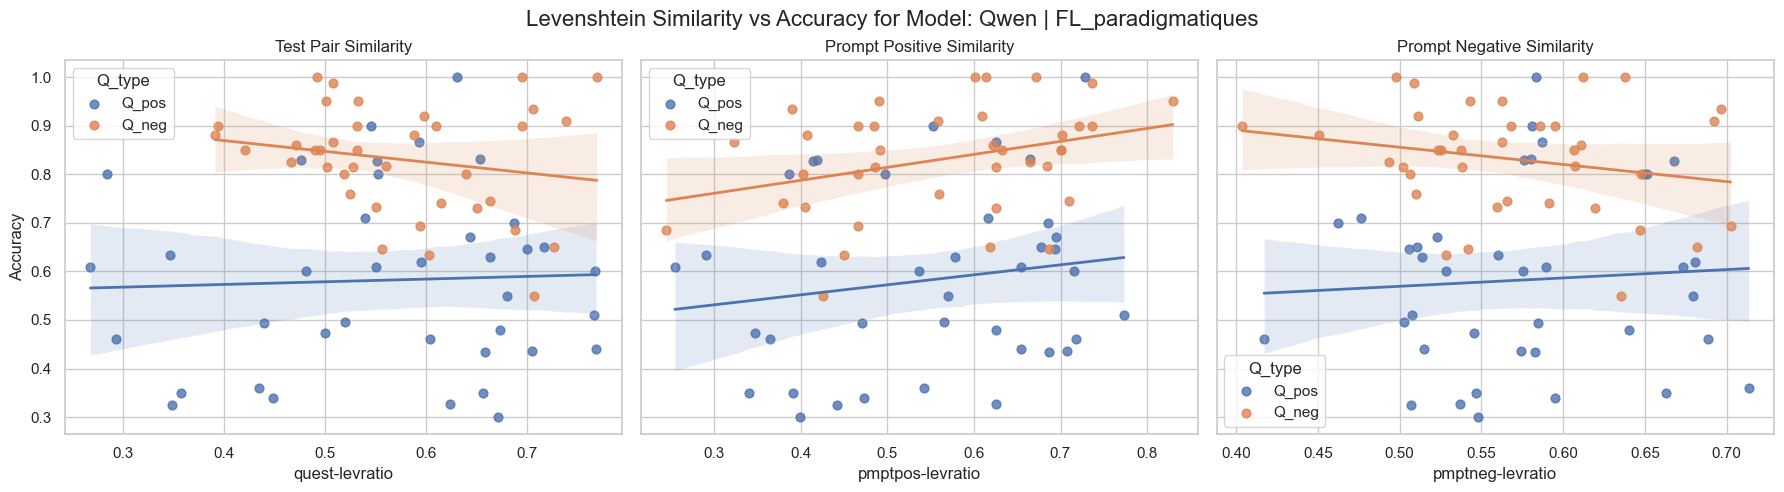

In [122]:
plot_model_levratios(perfm_best_gpd, model_name='Qwen', nodes_list=TGT_PARA)


### FL syntagmatique
les paires de mots ne sont pas similaire (levenstein-ratio < 0.5)
tendance neg pour les questions positives et plat pour les questions négative, ça veut dire le modèle ne tient pas compte de similarité morphologique

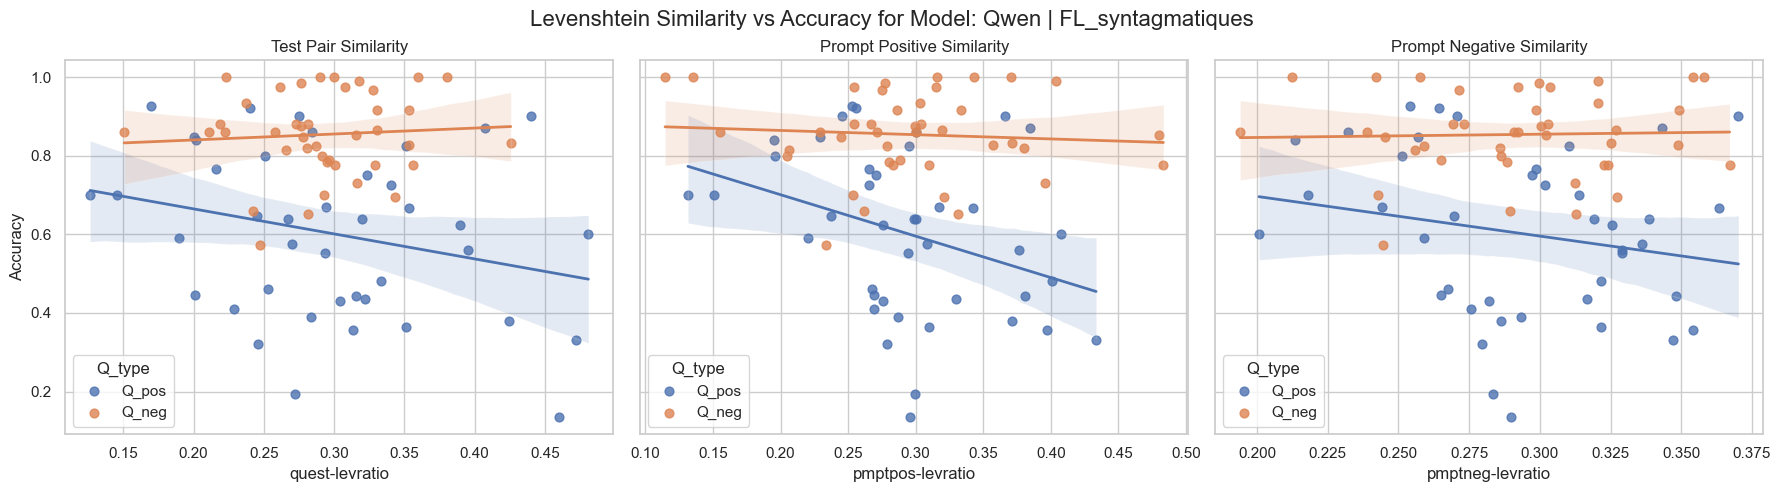

In [123]:
plot_model_levratios(perfm_best_gpd, model_name='Qwen', nodes_list=TGT_SYNT)


## Si on prend les nodes plus fins mais moins généraux que paradig/syntag


In [124]:
def find_node_subtree(tree, target):
    """
    在嵌套字典中查找指定key的子树（包括该key本身）。
    一旦找到目标key，返回该key及其内容。
    """
    if not isinstance(tree, dict):
        return None

    for key, value in tree.items():
        if key == target:
            return {key: value}
        result = find_node_subtree(value, target)
        if result:
            return result
    return None

def collect_all_keys(tree):
    """
    从一个嵌套字典中收集所有的key（递归，包括中间节点和叶节点）
    """
    keys = []
    for key, value in tree.items():
        keys.append(key)
        if isinstance(value, dict):
            keys.extend(collect_all_keys(value))
    return keys

In [125]:
lfs_structure_file = '../data/raw/lfs-structure-v3-simplified.json'
with open(lfs_structure_file, 'r') as f:
    lfs_structure = json.load(f)

# get subnodes by node
# 找到子树
subtree = find_node_subtree(lfs_structure, "Substitutive")
# 然后提取所有 key
if subtree:
    all_keys = collect_all_keys(subtree)
    print(all_keys)
else:
    print("Target not found.")

['Substitutive', 'Subst_sens_similaire', 'Syn', 'Gener', 'Subst_sens_opposé', 'Anti', 'Contr', 'Conv-ij']


In [126]:
param_subnodes = ['Substitutive', 'Dérivation_nominale', 'Dérivation_adjectival', 'Dérivation_verbale', 'Dérivation_adverbiale']
syntag_subnodes = ['Modificatwur', 'Nom_gouverneur', 'Collocation_prépositionnelle', 'Collocation_verbale']
def get_subnodes_mapping(tree, nodes):
    mapping = {}
    for node in nodes:
        subtree = find_node_subtree(tree, node)
        if subtree:
            all_keys = collect_all_keys(subtree)
            mapping[node] = all_keys
    return mapping

param_mapping = get_subnodes_mapping(lfs_structure, param_subnodes)
syntag_mapping = get_subnodes_mapping(lfs_structure, syntag_subnodes)
    

In [127]:
# for key, value in param_mapping.items():
#     print(f"{key}: {value}")
#     plot_model_levratios(perfm_best_gpd, model_name='Qwen', nodes_list=value)

In [128]:
results['quest_levratio'] = results.apply(lambda x: get_levenshtein_ratio(x['q_kw'], x['q_vl']), axis=1)

In [129]:
result_copy = results.copy()
result_copy['correct'] = result_copy['expected'] == result_copy['response']
result_copy['quest_levratio'] = result_copy.apply(lambda x: get_levenshtein_ratio(x['q_kw'], x['q_vl']), axis=1)
result_copy.value_counts('correct')
result_copy

,model,target,question_id,scope_id,kw_context,vl_propform,justify,k-shot,repeat_num,q_kw,q_vl,q_lf,expected,response,Q_type,True,Pred,quest_levratio,correct
0,LLaMA,Substitutive,1,1,0,1,0,2,1,pic,outil,Gener,Oui,Non,Q_pos,True,False,0.25,False
1,LLaMA,Substitutive,1,1,0,1,0,2,2,pic,outil,Gener,Oui,Oui,Q_pos,True,True,0.25,True
2,LLaMA,Substitutive,1,1,0,1,0,2,3,pic,outil,Gener,Oui,Non,Q_pos,True,False,0.25,False
3,LLaMA,Substitutive,1,1,0,1,0,2,4,pic,outil,Gener,Oui,Non,Q_pos,True,False,0.25,False
4,LLaMA,Substitutive,1,1,0,1,0,2,5,pic,outil,Gener,Oui,Non,Q_pos,True,False,0.25,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896395,Qwen,Liqu,80,4,0,0,0,10,1,médecin,examiner,Fact_2,Non,Non,Q_neg,False,False,0.40,True
896396,Qwen,Liqu,80,4,0,0,0,10,2,médecin,examiner,Fact_2,Non,Non,Q_neg,False,False,0.40,True
896397,Qwen,Liqu,80,4,0,0,0,10,3,médecin,examiner,Fact_2,Non,Non,Q_neg,False,False,0.40,True
896398,Qwen,Liqu,80,4,0,0,0,10,4,médecin,examiner,Fact_2,Non,Non,Q_neg,False,False,0.40,True


In [130]:
def plot_model_levratios_by_question(data:pd.DataFrame, model_name:str, lev_col:str = 'quest_levratio', nodes_list:list = None, fine:int = 10):
    """
    按照模型名和nodes_list筛选数据
    横坐标代表该问题的相似度，纵坐标代表该问题的正确与否：每个问题回答对了就是1，错了就是0，画出所有问题的分布点。
    然后把横坐标分成fine个区间，计算每个区间的平均值，作为一个点，再做一个散点图，进行线性回归。
    """
    # 筛选出模型子集
    if nodes_list:
        data = data[data['target'].isin(nodes_list)]
    data_model = data[data['model'] == model_name].copy()

    # 设置图形风格
    sns.set(style="whitegrid")

    # 计算每个问题的正确与否

    print(data_model['correct'].value_counts())

    # 画出散点图
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data_model, x=lev_col, hue='Q_type', y='correct', alpha=0.8)
    plt.title(f"Levenshtein Similarity vs Correctness for Model: {model_name} | {nodes_list[0]}")
    plt.xlabel(lev_col)
    plt.ylabel("Correctness")
    plt.xlim(0, 1)
    plt.ylim(-0.1, 1.1)
    plt.legend()
    # plt.show()

    # 计算每个区间的平均值，分别对 Q_pos 和 Q_neg 统计
    data_model['lev_bin'] = pd.cut(data_model[lev_col], bins=fine, labels=False)
    for q_type, color, label in zip(['Q_pos', 'Q_neg'], ['red', 'blue'], ['Q_pos', 'Q_neg']):
        subset = data_model[data_model['Q_type'] == q_type]
        if subset.empty:
            continue
        bin_means = subset.groupby('lev_bin')['correct'].mean().reset_index()
        bin_means['lev_bin'] = bin_means['lev_bin'].apply(lambda x: (x + 0.5) / fine)
        bin_means['lev_bin'] = bin_means['lev_bin'].round(2)
        print(f"{label} bin means:")
        print(bin_means)
        # 画出平均值的散点图和回归线
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=bin_means, x='lev_bin', y='correct', color=color, label=label)
        sns.regplot(data=bin_means, x='lev_bin', y='correct', scatter=False, color=color)
        plt.title(f"Levenshtein Similarity vs Correctness for Model: {model_name} | {nodes_list[0]} | {label}")
        plt.xlabel(lev_col)
        plt.ylabel("Accuracy")
        plt.xlim(-0.1, 1.1)
        plt.ylim(-0.1, 1.1)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [131]:
# plot_model_levratios_by_question(result_copy, model_name='Qwen', lev_col='quest_levratio', nodes_list=TGT_PARA, fine=50)

### levenshtein可视化需要考虑的问题：
1. 首先看看对于目标的target，我们的levenshtein ratio算不算是一个考虑的指标
这个指标有什么标准吗？？？
正例levratio明显高于负例？？？
2. 如果是考虑的指标，再去看模型是否利用了这一信息


In [132]:
# results_best = results_best.merge(lev_ratio_df, on=['target', 'Q_ID', "scope_id", "Q_type"], how='left')
# results_best.head()

## 使用boxplot
思路1：
查看target的正例和反例在数据集中的Levenshtein分布情况，
再看target在问题中的占比情况，正反问题分开看？
思路2:
查看target的正反例在prompt（k-shot）的Levenratio分布情况
再看target在问题里的levenshtein

In [133]:
levdata = pd.read_csv('../data/interim/instances_extracted.csv')

In [134]:
def boxplot_data_levratio(df: pd.DataFrame, lev_col: str = 'lev_ratio', group_col: str = "usage", target: str = "Substitutive"):
    """
    绘制 boxplot 数据，展示不同使用方式下的 Levenshtein 相似度分布。
    """
    # 筛选出目标节点的数据
    df_target = df[df['target'] == target].copy()
    
    # 确保 group_col 和 lev_col 存在于 DataFrame 中
    if group_col not in df_target.columns or lev_col not in df_target.columns:
        raise ValueError(f"DataFrame must contain columns '{group_col}' and '{lev_col}'")
    
    # 准备数据
    boxplot_data = df_target[[group_col, lev_col]].dropna()
    # 顺序
    myorder = ["prmpt_pos", "prmpt_neg", "question_pos", "question_neg"]
    # 颜色
    colors = {
        "prmpt_pos": "#1f77b4",  # 蓝色
        "prmpt_neg": "#ff7f0e",  # 橙色
        "question_pos": "#1f77b4",  # 蓝色
        "question_neg": "#ff7f0e"   # 橙色
    }
    
    # 画图
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(y=lev_col, hue=group_col, data=boxplot_data, order=myorder, palette=colors)
    plt.title(f"Levenshtein Similarity Distribution by {group_col} for Target: {target}")
    plt.xlabel(group_col)
    plt.ylabel(lev_col.replace('_', ' ').title())
    plt.xticks(rotation=45)
    plt.tight_layout()
    # 移除图例（如果不需要）
    plt.legend().remove()
    plt.show()
# Example usage
# boxplot_data_levratio(levdata, lev_col='lev_ratio', group_col='usage', target='S1')


In [135]:
def boxplot_levenratio_prompt_quest(data: pd.DataFrame,
                              pmppos_levratio_col: str = 'pmptpos-levratio',
                              pmpneg_levratio_col: str = 'pmptneg-levratio',
                              quest_levratio_col: str = 'quest-levratio',
                              model_name: str = 'Qwen',
                              nodes_list: list = None,
                              target_name: str = None):
    """
    查看target的正反例在prompt（k-shot）的Levenratio分布情况:
    利用boxplot展示每个target的正例和负例的Levenshtein相似度分布。
    Prompt分布不区分问题类型，只有问题分布才区分Q_pos/Q_neg。
    保持颜色一致：prompt正例和Q_pos使用相同颜色，prompt反例和Q_neg使用相同颜色。
    """
    # 筛选模型子集
    if target_name:
        data = data[data['target'] == target_name]
    if nodes_list:
        data = data[data['target'].isin(nodes_list)]
    data_model = data[data['model'] == model_name].copy()
    
    # 设置图形风格
    sns.set_theme(style="whitegrid")
    
    # 定义一致的颜色 - 柔和现代配色
    colors = {"PrmptPos": "#4e79a7",  # 深蓝色
          "PrmptNeg": "#eb7b0b",  # 橙色
          "Q_pos": "#4e79a7", 
          "Q_neg": "#eb7b0b"}
    
    # 准备数据 - 为prompt创建单独的DataFrame（不区分Q_type）
    prompt_data = []
    # 收集所有prompt正例数据，不区分问题类型
    for val in data_model[pmppos_levratio_col].dropna():
        prompt_data.append({"Metric": "PrmptPos", "LevenshteinRatio": val})
    # 收集所有prompt反例数据，不区分问题类型
    for val in data_model[pmpneg_levratio_col].dropna():
        prompt_data.append({"Metric": "PrmptNeg", "LevenshteinRatio": val})
    
    # 为问题创建DataFrame（区分Q_type）
    question_data = []
    for _, row in data_model.iterrows():
        if pd.notna(row[quest_levratio_col]):
            question_data.append({
                "Metric": "Question", 
                "Q_type": row["Q_type"],
                "LevenshteinRatio": row[quest_levratio_col]
            })
    
    # 转换为DataFrame
    prompt_df = pd.DataFrame(prompt_data)
    question_df = pd.DataFrame(question_data)
    
    # 创建图形
    plt.figure(figsize=(5, 3))
    
    # 绘制prompt箱线图（不区分Q_type）
    positions = [0, 1]  # Prompt Positive, Prompt Negative的位置
    for i, metric in enumerate(["PrmptPos", "PrmptNeg"]):
        subset = prompt_df[prompt_df["Metric"] == metric]
        if not subset.empty:
            box = plt.boxplot(
                subset["LevenshteinRatio"], 
                positions=[positions[i]], 
                widths=0.6,
                patch_artist=True,
                boxprops=dict(facecolor=colors[metric]),
                medianprops=dict(color='black')
            )
    
    # 绘制question箱线图（区分Q_type）
    positions = [3, 4]  # Question(Q_pos), Question(Q_neg)的位置
    for i, q_type in enumerate(["Q_pos", "Q_neg"]):
        subset = question_df[question_df["Q_type"] == q_type]
        if not subset.empty:
            box = plt.boxplot(
                subset["LevenshteinRatio"], 
                positions=[positions[i]], 
                widths=0.6,
                patch_artist=True,
                boxprops=dict(facecolor=colors[q_type]),
                medianprops=dict(color='black')
            )
    
    # 设置x轴标签
    plt.xticks([0, 1, 3, 4], ["PrmptPos", "PrmptNeg", "Q_pos", "Q_neg"])
    
    # 添加标题和标签
    plt.title(f"Levenshtein Similarity Distribution\nModel: {model_name} | Target: {target_name if target_name else (nodes_list[0] if nodes_list else '')}")
    plt.ylabel("Levenshtein Similarity")
    plt.ylim(-0.1, 1.1)
    
    # 添加图例（手动创建）
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=colors["PrmptPos"], label="Positive"),
        Patch(facecolor=colors["PrmptNeg"], label="Negative")
    ]
    plt.legend(handles=legend_elements)
    
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
# boxplot_levenratio_prompt_quest(results_best, quest_levratio_col='quest-levratio', model_name='Qwen2.5', target_name="Syn")

首先我们应该找出那些prompt里面正反例差别比较大的例子，看看在正反问题里所占的比例是否一致？再看看是不是prompt正例相似度高的正例问题acc更高，prompt反例相似度高的反例问题acc明显更低

## A.1. coefficient entre la polarité de réponse et la similarité de Levenshtein de la question

### A.1.1 Polarity de réponse VS Levenshtein ratio

In [136]:
results_best['quest_levratio'] = results_best.apply(lambda x: get_levenshtein_ratio(x['q_kw'], x['q_vl']), axis=1)
results_best

,model,target,question_id,scope_id,kw_context,vl_propform,justify,k-shot,repeat_num,q_kw,q_vl,q_lf,expected,response,Q_type,True,Pred,quest_levratio
846600,Qwen,Substitutive,1,1,0,1,0,10,1,pic,outil,Gener,Oui,Non,Q_pos,True,False,0.25
846601,Qwen,Substitutive,1,1,0,1,0,10,2,pic,outil,Gener,Oui,Non,Q_pos,True,False,0.25
846602,Qwen,Substitutive,1,1,0,1,0,10,3,pic,outil,Gener,Oui,Non,Q_pos,True,False,0.25
846603,Qwen,Substitutive,1,1,0,1,0,10,4,pic,outil,Gener,Oui,Non,Q_pos,True,False,0.25
846604,Qwen,Substitutive,1,1,0,1,0,10,5,pic,outil,Gener,Oui,Non,Q_pos,True,False,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149395,LLaMA,Liqu,80,4,0,0,0,10,1,médecin,examiner,Fact_2,Non,Non,Q_neg,False,False,0.40
149396,LLaMA,Liqu,80,4,0,0,0,10,2,médecin,examiner,Fact_2,Non,Oui,Q_neg,False,True,0.40
149397,LLaMA,Liqu,80,4,0,0,0,10,3,médecin,examiner,Fact_2,Non,Non,Q_neg,False,False,0.40
149398,LLaMA,Liqu,80,4,0,0,0,10,4,médecin,examiner,Fact_2,Non,Oui,Q_neg,False,True,0.40


In [137]:
from scipy.stats import pearsonr

def corl_levratio_polarity(data: pd.DataFrame, lev_col: str = 'quest_levratio', target_col='target', model_name='Qwen', perspective='pred'):
    """
    以模型分组，以target为单位计算 Levenshtein 相似度与 polarity 的相关性。
    如果perspective='p'，就是看response（Oui/Non）与 Levenshtein 相似度的相关性；
    如果perspective='t'，就是看expected （Oui/Non）与 Levenshtein 相似度的相关性。
    """
    if model_name:
        data = data[data['model'] == model_name].copy()
    if perspective == 'true':
        data['polarity'] = data['expected'].copy().map({'Oui': 1, 'Non': -1})
    if perspective == 'pred':
        data['polarity'] = data['response'].copy().map({'Oui': 1, 'Non': -1})
    results = []
    for model, group in data.groupby('model'):
        for target, sub_group in group.groupby(target_col):
            if sub_group.empty:
                continue
            # 计算相关系数
            corr, p_value = pearsonr(sub_group[lev_col], sub_group['polarity'])
            results.append({
                'model': model,
                'target': target,
                f'correlation_{perspective}': round(corr,3),
                f'p_value_{perspective}': round(p_value,3)
            })
    return pd.DataFrame(results)
lev_corr_df = corl_levratio_polarity(results_best, lev_col='quest_levratio', target_col='target', model_name=None, perspective='true')
lev_corr_df[lev_corr_df['target'] == "Dérivation_adverbiale"]

,model,target,correlation_true,p_value_true
20,LLaMA,Dérivation_adverbiale,0.109,0.28
102,Mistral,Dérivation_adverbiale,0.109,0.28
184,Qwen,Dérivation_adverbiale,0.109,0.28


In [138]:
results_best['quest_levratio'] = results_best.apply(lambda x: get_levenshtein_ratio(x['q_kw'], x['q_vl']), axis=1)

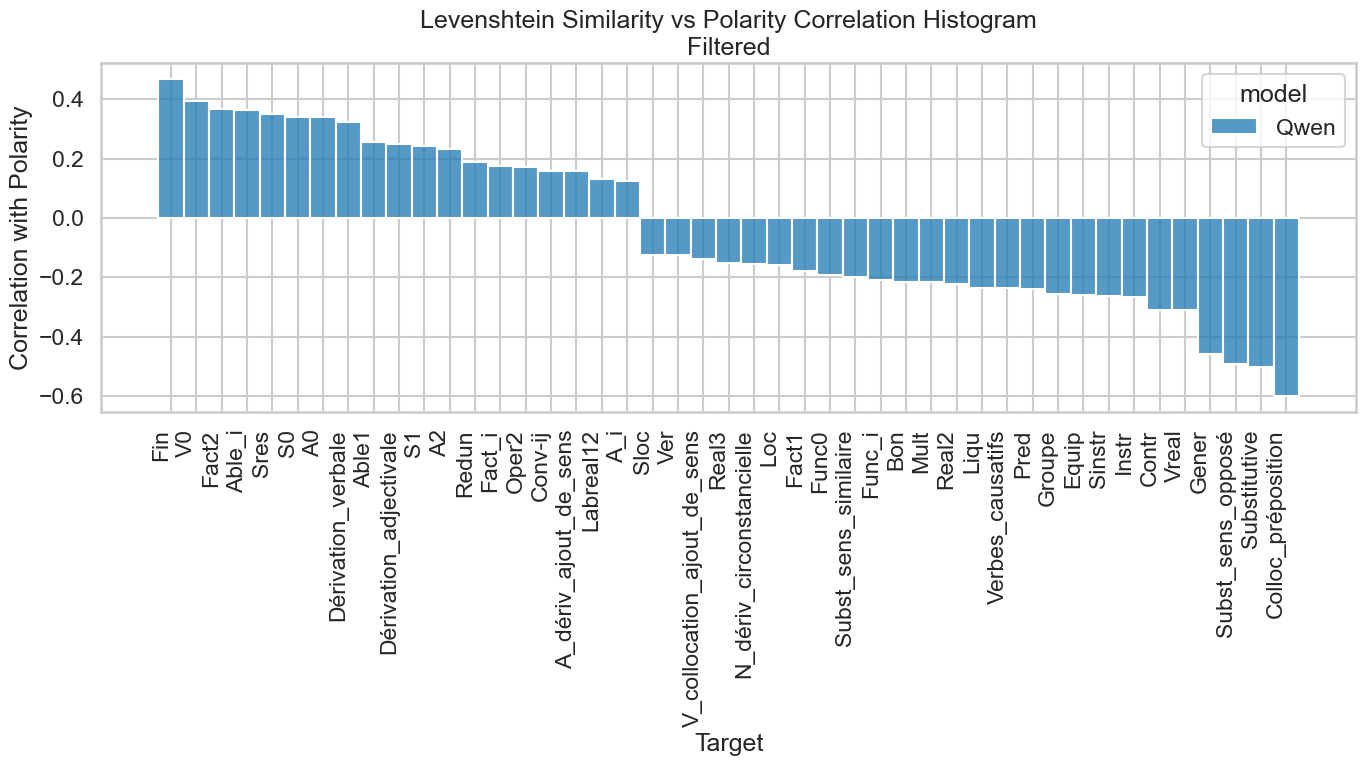

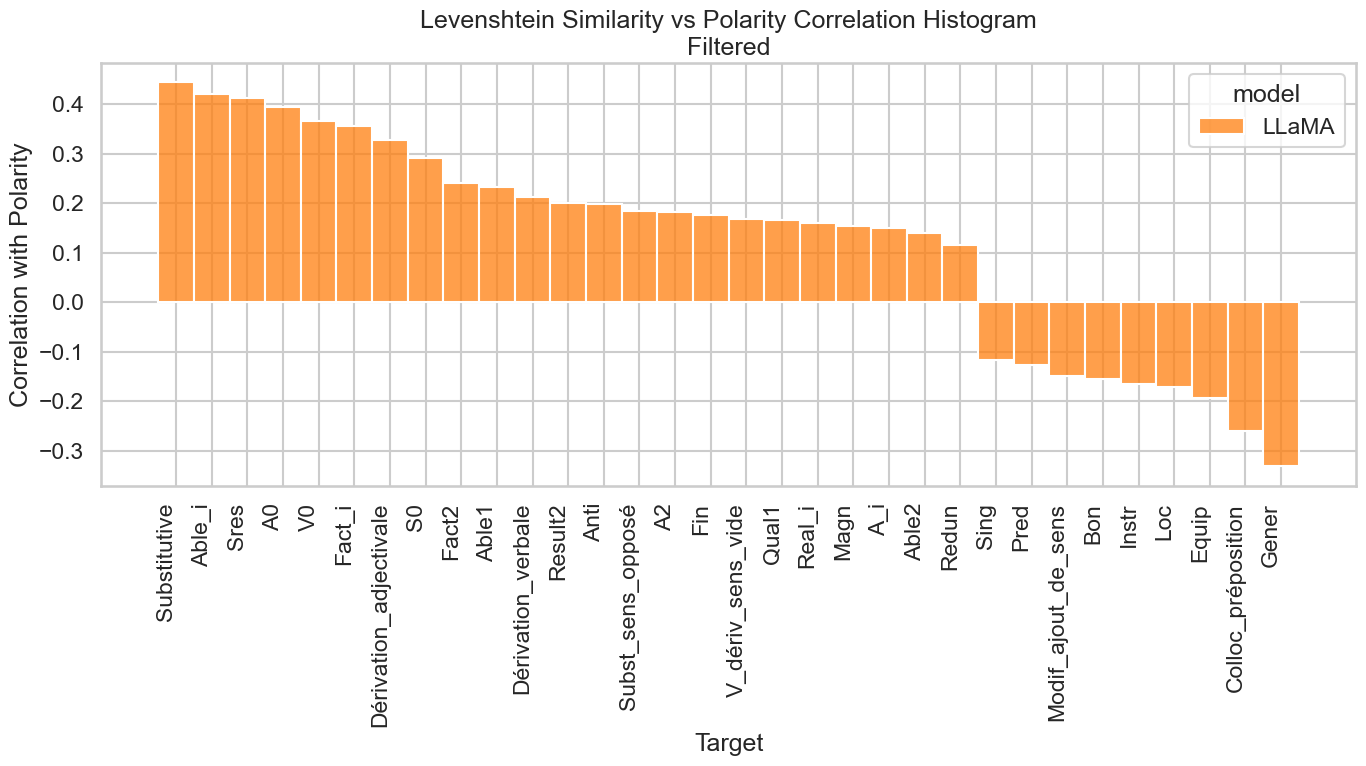

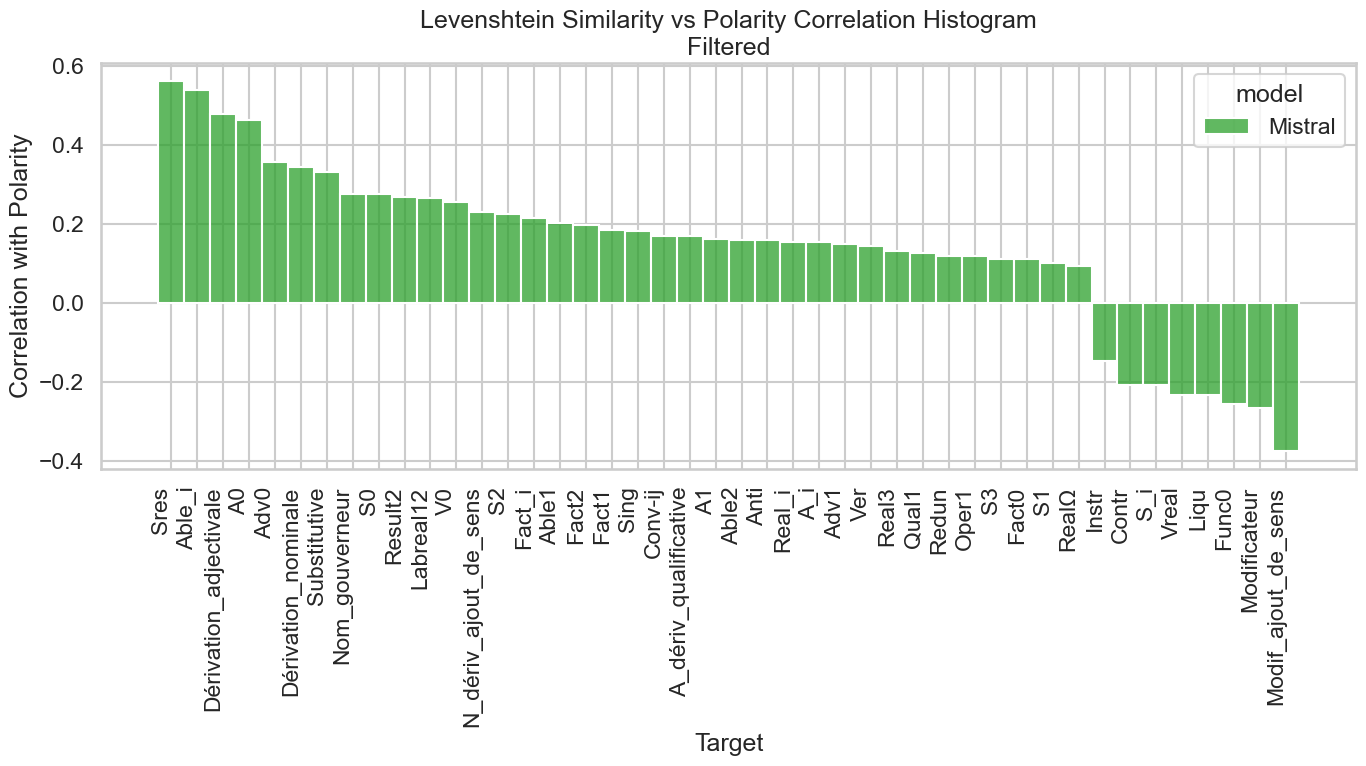

In [139]:
def barchart_lr_plrty(data: pd.DataFrame, lev_col: str = 'quest_levratio', target_col='target', p_filtred: bool = True, model_name: str = None, synt_para: bool = False):
   
    # Filter data for the specified model if model_name is provided
    if model_name:
        data = data[data['model'] == model_name].copy()
    
    # Calculate correlation
    df_cor = corl_levratio_polarity(data, lev_col=lev_col, target_col=target_col, model_name=model_name, perspective='pred')
    
    if p_filtred:
        # Filter by p_value < 0.05
        df_cor = df_cor[df_cor['p_value_pred'] < 0.05]
        
        # Retain only targets common to all three models
        common_targets = set(data['target'].unique())
        for model in data['model'].unique():
            common_targets &= set(data[data['model'] == model]['target'].unique())
        
        # Filter the correlation DataFrame to include only common targets
        df_cor = df_cor[df_cor['target'].isin(common_targets)]
    
    # Sort by correlation
    df_cor = df_cor.sort_values('correlation_pred', ascending=False)
    
    # Plot histogram
    plt.figure(figsize=(14, 8))
    sns.set_context("talk")
    sns.histplot(
        data=df_cor,
        x='target',
        hue='model',
        weights='correlation_pred',
        multiple='dodge',  # Arrange bars side by side
        palette=MODEL_PALETTE,
        binwidth=0.1,  # Set narrower bars
    )
    plt.xticks(rotation=90, ha='right')
    plt.xlabel('Target')
    plt.ylabel('Correlation with Polarity')
    plt.title(f'Levenshtein Similarity vs Polarity Correlation Histogram\n{"Filtered" if p_filtred else "All"}')
    plt.tight_layout()
    plt.show()

# Example call
barchart_lr_plrty(results_best, lev_col='quest_levratio', target_col='target', p_filtred=True, model_name='Qwen')
barchart_lr_plrty(results_best, lev_col='quest_levratio', target_col='target', p_filtred=True, model_name='LLaMA')
barchart_lr_plrty(results_best, lev_col='quest_levratio', target_col='target', p_filtred=True, model_name='Mistral')

In [140]:
results_best.value_counts('scope_id')

scope_id
1    24600
2    21900
3    16500
4     9000
5     2700
Name: count, dtype: int64

/var/folders/04/mz2jyny17hz88wzglmzrlwpr0000gn/T/ipykernel_1499/1283387434.py:21: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(sub_group[lev_col], sub_group['polarity'])


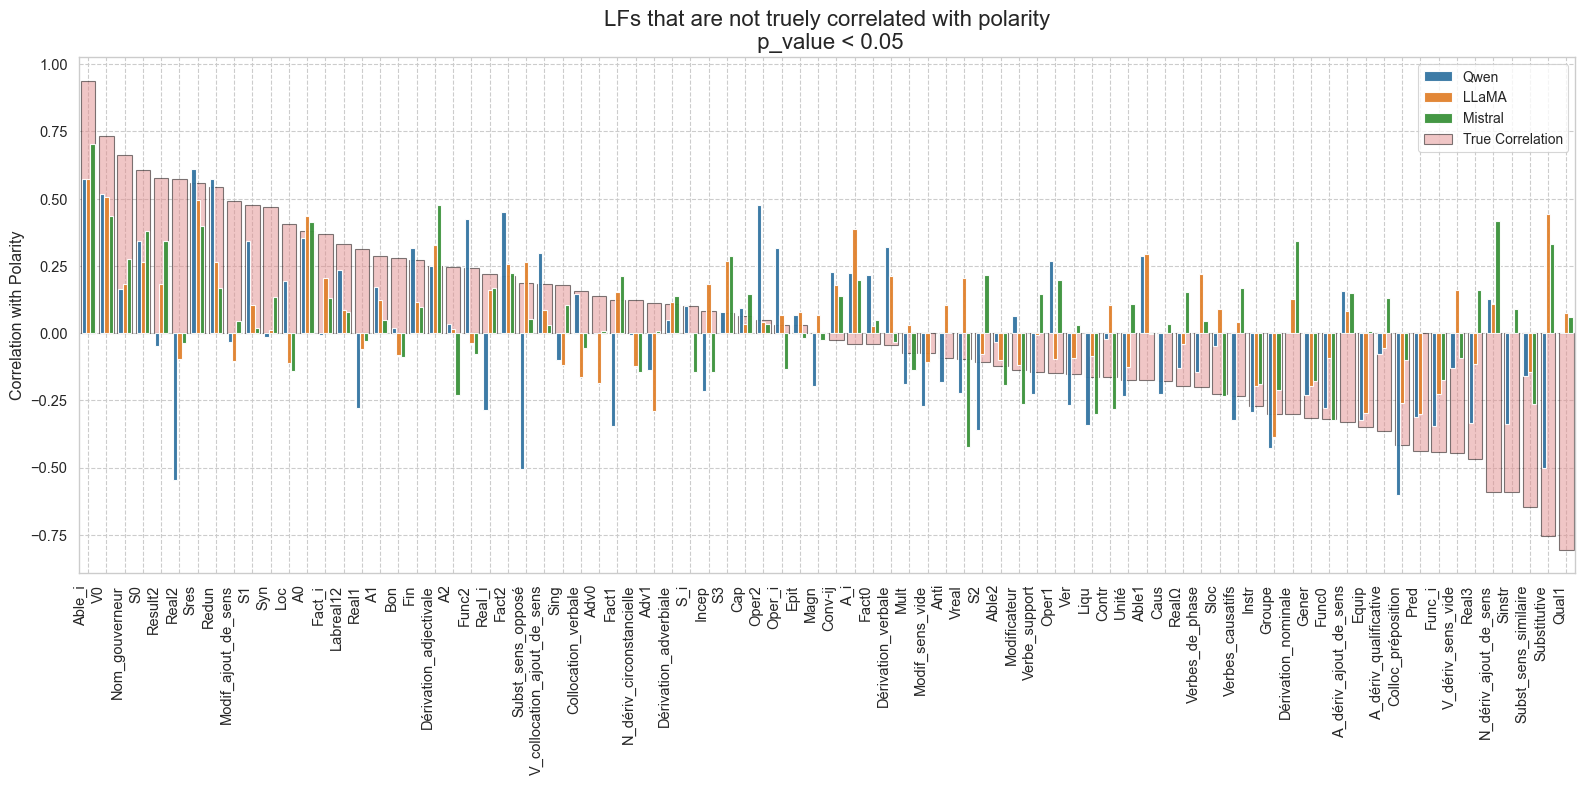

In [141]:
def barchart_lr_plrty_pred_truth_alltrue_beautified(
    data: pd.DataFrame, 
    lev_col: str = 'quest_levratio', 
    target_col='target', 
    p_filtred: bool = True, 
    model_name: str = None,
    Modelpalette: dict = None
):
    """
    展示整体的真实 correlation（主柱子），以及所有模型的 predicted correlation（细柱子叠加），
    用颜色区分不同模型的 pred correlation。
    美化版：清晰颜色、白色背景、黑色边框、透明度优化。
    """
    # 筛选 scope=1 的数据
    data = data[data['scope_id'] == 1].copy()

    # 当前模型的数据用于 pred correlation
    # 获取 correlation 数据
    if model_name:
        data = data[data['model'] == model_name].copy()

    else:
        all_results_pred = []
        all_results_true = []
        for m in data['model'].unique():
            df_cor_pred = corl_levratio_polarity(data, lev_col=lev_col, target_col=target_col, model_name=m, perspective='pred')
            df_cor_true = corl_levratio_polarity(data, lev_col=lev_col, target_col=target_col, model_name=m, perspective='true')
            all_results_pred.append(df_cor_pred)
            all_results_true.append(df_cor_true)
        # 合并所有模型的结果
        df_cor_pred = pd.concat(all_results_pred, ignore_index=True)
        df_cor_true = pd.concat(all_results_true, ignore_index=True)

    if p_filtred:
        df_cor_pred = df_cor_pred[df_cor_pred['p_value_pred'] < 0.05]
        df_cor_true = df_cor_true[df_cor_true['p_value_true'] < 0.05]

    # else:
    #     # # 如果不进行 p 值过滤，则看那些pvale大于等于 0.05 的 targets
    #     df_cor_pred = df_cor_pred[df_cor_pred['p_value_pred'] >= 0.05]
    #     df_cor_true = df_cor_true[df_cor_true['p_value_true'] >= 0.05]


    # 仅保留所有模型都覆盖的 targets
    common_targets = set(df_cor_pred['target'].unique()).intersection(set(df_cor_true['target'].unique()))
    # 仅保留所有模型都覆盖的 targets
    if model_name:
        common_targets = set(data[data['model'] == model_name]['target'].unique()).intersection(common_targets)
    # # 过滤掉不在 common_targets 中的 targets
    # df_cor_true = df_cor_true[df_cor_true['target'].isin(common_targets)]
    # df_cor_pred = df_cor_pred[df_cor_pred['target'].isin(common_targets)]
        
    
    # 如果没有数据，则返回
    if df_cor_pred.empty or df_cor_true.empty:
        print("No data available for the specified filters.")
        return

    # 排序
    df_cor_true = df_cor_true.sort_values('correlation_true', ascending=False)
    unique_targets = df_cor_true['target'].unique()
    df_cor_true['target'] = pd.Categorical(df_cor_true['target'], categories=unique_targets, ordered=True)

    # 合并排序 pred correlation
    merged = pd.merge(
        df_cor_pred, 
        df_cor_true[['target', 'model', 'correlation_true']], 
        on=['target', 'model'],
        how='left'
    )
    df_cor_pred = merged.sort_values('correlation_true', ascending=False)
    df_cor_pred['target'] = pd.Categorical(df_cor_pred['target'], categories=unique_targets, ordered=True)

    # 画图
    plt.figure(figsize=(16, 8))
    sns.set_theme(style="whitegrid")  # 设置白底
    sns.set_context("paper", font_scale=1.2)

    # 主柱子：true correlation
    sns.barplot(
        data=df_cor_true,
        x='target',
        y='correlation_true',
        color='lightcoral',
        label='True Correlation',
        alpha=0.5,
        width=0.8,
        edgecolor='black',
        errorbar=None
    )

    # 加细柱子：pred correlation by model，细柱子之间并列
    sns.barplot(
        data=df_cor_pred,
        x='target',
        y='correlation_pred',
        hue='model',
        palette=Modelpalette,
        alpha=0.95,
        width=0.7,
        dodge=True,  # 并列显示
        # edgecolor='black',
        errorbar=None
    )

    plt.xticks(rotation=90, ha='right')
    plt.xlabel('')
    plt.ylabel('Correlation with Polarity')
    # plt.ylim(-1, 1)  # 设置y轴范围
    plt.title(f'LFs that { "are truely" if p_filtred else "are not truely" } correlated with polarity\n p_value {"<" if {p_filtred} else ">="} 0.05', fontsize=16)
    plt.legend(title='Model Prediction Correlation')
    # legend 字体
    plt.legend(fontsize=10, title_fontsize='13')
    plt.grid(axis='both', linestyle='--', alpha=1)
    plt.tight_layout()
    # 保存图像
    plt.savefig(f'otpt/levenshtein/levenshtein_correlation{"" if p_filtred else "all"}_truely_collereated.pdf', format='pdf', bbox_inches='tight')
    plt.show()
# Example call
barchart_lr_plrty_pred_truth_alltrue_beautified(
    results_best,
    lev_col='quest_levratio',
    target_col='target',
    p_filtred=False,
    model_name=None,  # None to include all models
    Modelpalette=MODEL_PALETTE
)

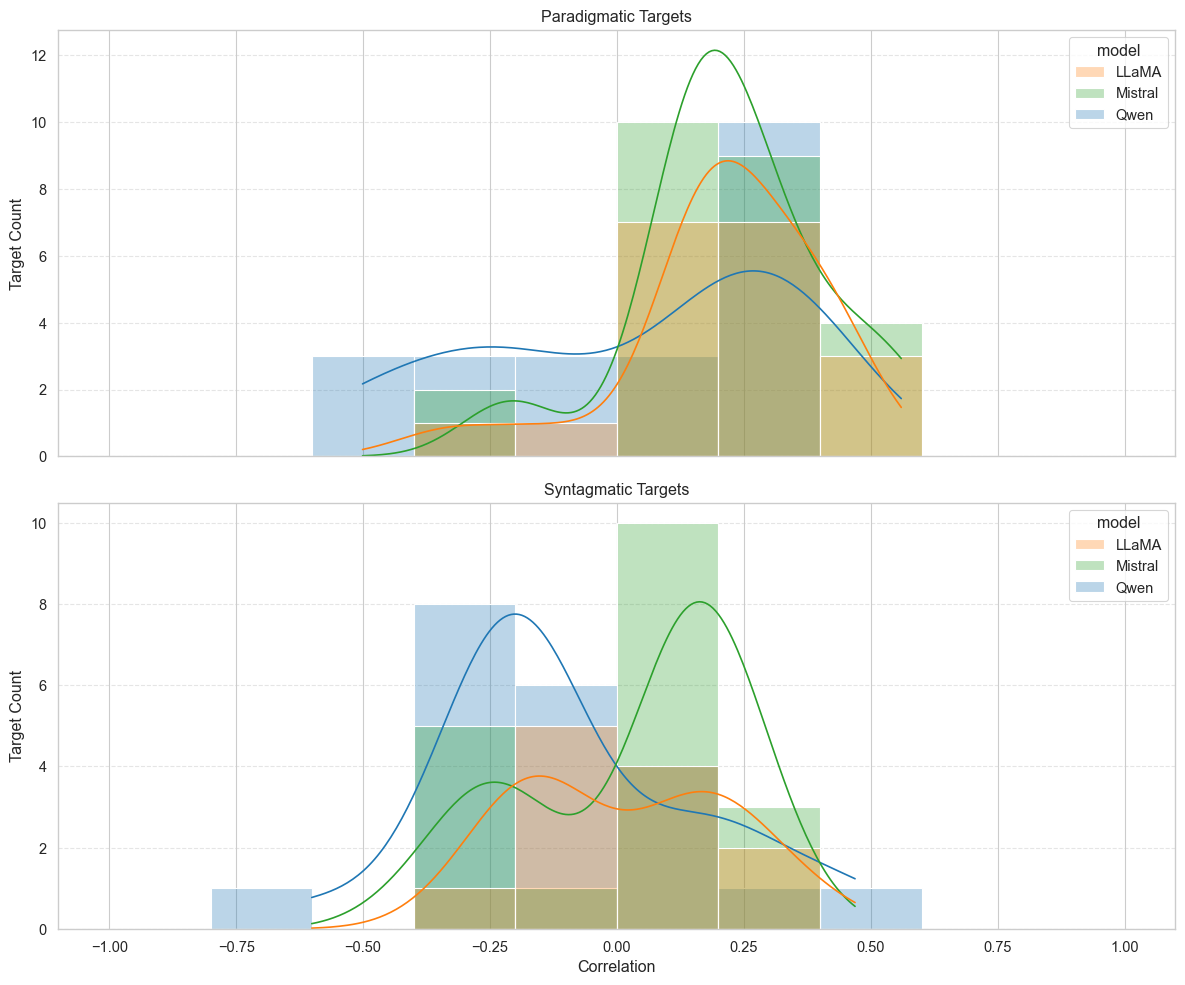

In [142]:
def histogram_lr_plrty(data: pd.DataFrame, lev_col: str = 'quest_levratio', target_col='target', p_filtred: bool = True, para_synt: bool = True):
    """
    如果para_synt=True,先拆paradigmatic和syntagmatic两种类型的target，然后分成上下两个子图；
    否则就画一个图。
    使用sns.histplot绘制相关系数分段下的目标数量直方图，支持所有模型。
    """
    data = data.copy()  # 避免 SettingWithCopyWarning
    data['polarity'] = data['response'].map({'Oui': 1, 'Non': 0})

    if para_synt:
        fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        for i, (label, targets) in enumerate({'Paradigmatic': TGT_PARA, 'Syntagmatic': TGT_SYNT}.items()):
            subset = data[data[target_col].isin(targets)].copy()
            corr_df = corl_levratio_polarity(subset, lev_col=lev_col, target_col=target_col, model_name=None)
            if p_filtred:
                corr_df = corr_df[corr_df['p_value_pred'] < 0.05]
            
            sns.histplot(
                data=corr_df,
                x='correlation_pred',
                hue='model',
                bins=np.arange(-1, 1.1, 0.2),
                kde=True,
                palette=MODEL_PALETTE,
                alpha=0.3,
                ax=axes[i]
            )
            axes[i].set_title(f"{label} Targets")
            axes[i].set_ylabel("Target Count")
            axes[i].grid(axis='y', linestyle='--', alpha=0.5)
        
        axes[-1].set_xlabel("Correlation")
        plt.tight_layout()
        plt.show()

    else:
        # 整体数据合并画一个图
        corr_df = corl_levratio_polarity(data, lev_col=lev_col, target_col=target_col, model_name=None)
        if p_filtred:
            corr_df = corr_df[corr_df['p_value_pred'] < 0.05]

        plt.figure(figsize=(12, 8))
        sns.histplot(
            data=corr_df,
            x='correlation_pred',
            hue='model',
            bins=np.arange(-1, 1.1, 0.2),
            kde=True,
            palette=MODEL_PALETTE,
            alpha=0.3
        )
        plt.title("Target Count by Correlation Bins (All Models)")
        plt.xlabel("Correlation")
        plt.ylabel("Target Count")
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
# Example call
histogram_lr_plrty(results_best, lev_col='quest_levratio', p_filtred=True, target_col='target', para_synt=True)

/var/folders/04/mz2jyny17hz88wzglmzrlwpr0000gn/T/ipykernel_1499/1283387434.py:21: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(sub_group[lev_col], sub_group['polarity'])


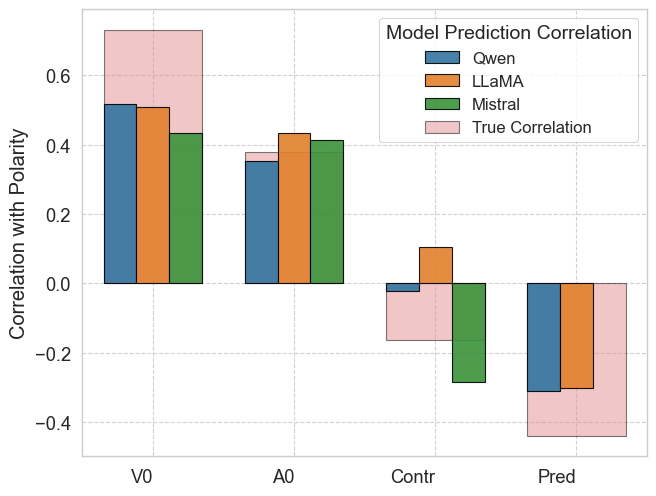

In [143]:
def barchart_lr_plrty_pred_truth_subset(
    data: pd.DataFrame, 
    lev_col: str = 'quest_levratio', 
    target_col: str = 'target', 
    model_name: str = None,
    Modelpalette: dict = None,
    targets_to_plot: list = None  # 👈 新增：人工指定只显示哪些 targets
):
    """
    展示指定 targets 的 true correlation（粉红底柱）和每个模型的 pred correlation（彩色叠柱）。
    不进行 p 值过滤，固定顺序绘制三个模型的 pred 结果。
    """

    data = data[data['scope_id'] == 1].copy()

    # 获取所有模型的 pred 和 true correlation
    all_results_pred = []
    all_results_true = []

    for m in data['model'].unique():
        df_cor_pred = corl_levratio_polarity(data, lev_col=lev_col, target_col=target_col, model_name=m, perspective='pred')
        df_cor_true = corl_levratio_polarity(data, lev_col=lev_col, target_col=target_col, model_name=m, perspective='true')
        df_cor_pred['model'] = m
        df_cor_true['model'] = m
        all_results_pred.append(df_cor_pred)
        all_results_true.append(df_cor_true)

    df_cor_pred = pd.concat(all_results_pred, ignore_index=True)
    df_cor_true = pd.concat(all_results_true, ignore_index=True)

    # 如果指定只画部分 target
    if targets_to_plot:
        df_cor_pred = df_cor_pred[df_cor_pred['target'].isin(targets_to_plot)]
        df_cor_true = df_cor_true[df_cor_true['target'].isin(targets_to_plot)]

    # 合并 & 排序
    df_cor_true = df_cor_true.sort_values('correlation_true', ascending=False)
    unique_targets = df_cor_true['target'].unique()
    df_cor_true['target'] = pd.Categorical(df_cor_true['target'], categories=unique_targets, ordered=True)

    df_cor_pred = pd.merge(
        df_cor_pred,
        df_cor_true[['target', 'model', 'correlation_true']],
        on=['target', 'model'],
        how='inner'
    )
    df_cor_pred['target'] = pd.Categorical(df_cor_pred['target'], categories=unique_targets, ordered=True)

    # 自动设置柱子宽度
    num_targets = len(unique_targets)

    # 开始画图
    plt.figure(figsize=(6.8, 5.2))
    sns.set_theme(style="whitegrid")
    sns.set_context("paper", font_scale=1.5)

    # True correlation 底柱
    sns.barplot(
        data=df_cor_true,
        x='target',
        y='correlation_true',
        color='lightcoral',
        alpha=0.5,
        width=0.7,
        dodge=False,  # 不并列显示
        edgecolor='black',
        label='True Correlation',
        errorbar=None
    )

    # Pred correlation 子柱
    model_order = ['Qwen', 'LLaMA', 'Mistral']  # 👈 固定顺序
    df_cor_pred['model'] = pd.Categorical(df_cor_pred['model'], categories=model_order, ordered=True)
    sns.barplot(
        data=df_cor_pred,
        x='target',
        y='correlation_pred',
        hue='model',
        palette=Modelpalette,
        width=0.7,
        alpha=0.9,
        dodge=True,
        edgecolor='black',
        errorbar=None
    )

    plt.xticks(ha='right')
    plt.xlabel('')
    plt.ylabel('Correlation with Polarity')
    # plt.title('Levenshtein Similarity vs. Polarity Correlation (Selected Targets)', fontsize=16)
    plt.legend(title='Model Prediction Correlation', fontsize=12, title_fontsize=14)
    plt.grid(axis='both', linestyle='--', alpha=0.9)
    plt.tight_layout()
    plt.savefig(f'otpt/levenshtein/levenshtein_correlation_subset.pdf', format='pdf', bbox_inches='tight')
    plt.show()
sample_targets = ['V0',  'A0', 'Contr', 'Pred']
barchart_lr_plrty_pred_truth_subset(
    results_best,
    lev_col='quest_levratio',
    target_col='target',
    model_name=None,  # None to include all models
    Modelpalette=MODEL_PALETTE,
    targets_to_plot=sample_targets  # 👈 指定只显示这些 targets
)

In [144]:
def barchart_lr_plrty_pred_truth(
    data: pd.DataFrame, 
    lev_col: str = 'quest_levratio', 
    target_col: str = 'target', 
    model_name: str = None,
    Modelpalette: dict = None,
    targets_to_plot: list = None,
    p_filtred: bool = True,
    synt_para: bool = True,
    model_order: list = ['Qwen', 'LLaMA', 'Mistral'],
    title: str = None,
    savepath: str = ""
):
    """
    绘制目标 target 的 polarity correlation。
    支持全量和 subset 模式；支持 p 值过滤；支持 syntagmatic vs paradigmatic 分组绘图。
    """
    data = data[data['scope_id'] == 1].copy()

    all_results_pred = []
    all_results_true = []

    for m in data['model'].unique():
        df_cor_pred = corl_levratio_polarity(data, lev_col=lev_col, target_col=target_col, model_name=m, perspective='pred')
        df_cor_true = corl_levratio_polarity(data, lev_col=lev_col, target_col=target_col, model_name=m, perspective='true')
        df_cor_pred['model'] = m
        df_cor_true['model'] = m
        all_results_pred.append(df_cor_pred)
        all_results_true.append(df_cor_true)

    df_cor_pred = pd.concat(all_results_pred, ignore_index=True)
    df_cor_true = pd.concat(all_results_true, ignore_index=True)

    if targets_to_plot:
        df_cor_pred = df_cor_pred[df_cor_pred['target'].isin(targets_to_plot)]
        df_cor_true = df_cor_true[df_cor_true['target'].isin(targets_to_plot)]

    if p_filtred:
        df_cor_true = df_cor_true[df_cor_true['p_value_true'] < 0.05]
        df_cor_pred = df_cor_pred[df_cor_pred['target'].isin(df_cor_true['target'])]

    # ---------------- 分 synt / para 两张图 ---------------- #
    if synt_para:
        # 你需要自己提供这两个列表：
        SYNT_LIST = [...]  # e.g. ['Oper1', 'Real1', 'Magn', ...]
        PARA_LIST = [...]  # e.g. ['Syn', 'Anti', 'Conv', ...]

        groups = {
            'Syntagmatic': SYNT_LIST,
            'Paradigmatic': PARA_LIST
        }

        for group_name, target_list in groups.items():
            df_true_sub = df_cor_true[df_cor_true['target'].isin(target_list)].copy()
            df_pred_sub = df_cor_pred[df_cor_pred['target'].isin(target_list)].copy()

            if df_true_sub.empty or df_pred_sub.empty:
                print(f"Skipping {group_name} group due to empty data.")
                continue

            df_true_sub = df_true_sub.sort_values('correlation_true', ascending=False)
            unique_targets = df_true_sub['target'].unique()
            df_true_sub['target'] = pd.Categorical(df_true_sub['target'], categories=unique_targets, ordered=True)
            df_pred_sub = pd.merge(df_pred_sub, df_true_sub[['target', 'model', 'correlation_true']], on=['target', 'model'], how='inner')
            df_pred_sub['target'] = pd.Categorical(df_pred_sub['target'], categories=unique_targets, ordered=True)

            # 绘图
            num_targets = len(unique_targets)
            fig_width = max(8, 0.5 * num_targets)
            fig_height = min(0.4 * num_targets + 2, 20)

            plt.figure(figsize=(fig_width, fig_height))
            sns.set_theme(style="whitegrid")
            sns.set_context("paper", font_scale=1.3)

            sns.barplot(
                data=df_true_sub,
                x='target',
                y='correlation_true',
                color='lightcoral',
                alpha=0.5,
                width=0.7,
                dodge=False,
                edgecolor='black',
                label='True Correlation',
                errorbar=None
            )

            df_pred_sub['model'] = pd.Categorical(df_pred_sub['model'], categories=model_order, ordered=True)
            sns.barplot(
                data=df_pred_sub,
                x='target',
                y='correlation_pred',
                hue='model',
                palette=Modelpalette,
                width=0.7,
                alpha=0.9,
                dodge=True,
                edgecolor='black',
                errorbar=None
            )

            plt.xticks(rotation=90, ha='right')
            plt.xlabel('')
            plt.ylabel('Correlation with Polarity')
            plt.title(f"{group_name} targets - {title}", fontsize=16)
            plt.legend(title='Model Prediction Correlation', fontsize=11, title_fontsize=12)
            plt.grid(axis='both', linestyle='--', alpha=0.9)
            plt.tight_layout()
            plt.savefig(savepath + f'levenshtein/correl_true_pred_{title}_{group_name}.pdf', format='pdf', bbox_inches='tight')
            plt.show()

    # ---------------- 原版：单张图 ---------------- #
    else:
        df_cor_true = df_cor_true.sort_values('correlation_true', ascending=False)
        unique_targets = df_cor_true['target'].unique()
        df_cor_true['target'] = pd.Categorical(df_cor_true['target'], categories=unique_targets, ordered=True)
        df_cor_pred = pd.merge(df_cor_pred, df_cor_true[['target', 'model', 'correlation_true']], on=['target', 'model'], how='inner')
        df_cor_pred['target'] = pd.Categorical(df_cor_pred['target'], categories=unique_targets, ordered=True)

        num_targets = len(unique_targets)
        fig_width = max(8, 0.5 * num_targets)
        fig_height = min(0.4 * num_targets + 2, 20)

        plt.figure(figsize=(fig_width, fig_height))
        sns.set_theme(style="whitegrid")
        sns.set_context("paper", font_scale=1.3)

        sns.barplot(
            data=df_cor_true,
            x='target',
            y='correlation_true',
            color='lightcoral',
            alpha=0.5,
            width=0.7,
            dodge=False,
            edgecolor='black',
            label='True Correlation',
            errorbar=None
        )

        df_cor_pred['model'] = pd.Categorical(df_cor_pred['model'], categories=model_order, ordered=True)
        sns.barplot(
            data=df_cor_pred,
            x='target',
            y='correlation_pred',
            hue='model',
            palette=Modelpalette,
            width=0.7,
            alpha=0.9,
            dodge=True,
            edgecolor='black',
            errorbar=None
        )

        plt.xticks(rotation=90, ha='right')
        plt.xlabel('')
        plt.ylabel('Correlation with Polarity')
        if title:
            plt.title(title, fontsize=16)
        plt.legend(title='Model Prediction Correlation', fontsize=11, title_fontsize=12)
        plt.grid(axis='both', linestyle='--', alpha=0.9)
        plt.tight_layout()
        plt.savefig(savepath + f'levenshtein/correl_true_pred_{title}.pdf', format='pdf', bbox_inches='tight')
        plt.show()

In [145]:
perform_best_both = pd.read_csv('otpt/perform_best_both.csv')
perform_best_both = perform_best_both[perform_best_both['scope_id'] == 1].copy()
perform_best_both[perform_best_both["target"].isin(sample_targets)][['model', 'target', 'acc_mean']]

FileNotFoundError: [Errno 2] No such file or directory: 'otpt/perform_best_both.csv'

KeyError: 'p_value'

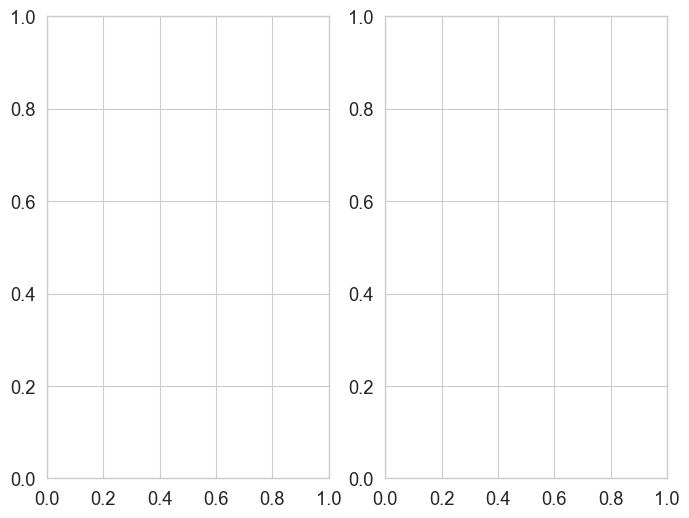

In [146]:
def boxplot_lr_plrty(data: pd.DataFrame, lev_col: str = 'quest_levratio', target_col='target', p_filtred: bool = True, para_synt: bool = True):
    """
    如果para_synt=True, 先拆paradigmatic和syntagmatic两种类型的target，分成上下两个子图；
    否则画一个图。
    使用sns.boxplot绘制不同模型下的correlation分布，按model分颜色。
    """
    data = data.copy()
    data['polarity'] = data['response'].map({'Oui': 1, 'Non': 0})

    if para_synt:
        fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True)
        y_min, y_max = None, None  # 用于记录y轴范围
        for i, (label, targets) in enumerate({'Paradigmatic': TGT_PARA, 'Syntagmatic': TGT_SYNT}.items()):
            subset = data[data[target_col].isin(targets)].copy()
            corr_df = corl_levratio_polarity(subset, lev_col=lev_col, target_col=target_col, model_name=None)
            if p_filtred:
                corr_df = corr_df[corr_df['p_value'] < 0.05]

            sns.boxplot(
                data=corr_df,
                x='model',
                y='correlation',
                hue='model',
                palette=MODEL_PALETTE,
                legend=False,
                ax=axes[i]
            )
            axes[i].set_title(f"{label} Targets")
            axes[i].set_ylabel("Pearson r (similarity vs. polarity)")
            axes[i].grid(axis='y', linestyle='--', alpha=0.5)

            # 更新y轴范围
            current_y_min, current_y_max = axes[i].get_ylim()
            y_min = min(y_min, current_y_min) if y_min is not None else current_y_min
            y_max = max(y_max, current_y_max) if y_max is not None else current_y_max
         # 设置统一的y轴范围
        for ax in axes:
            ax.set_ylim(y_min, y_max)

        plt.supxlabel = "Model"
        plt.tight_layout()
        plt.show()

    else:
        corr_df = corl_levratio_polarity(data, lev_col=lev_col, target_col=target_col, model_name=None)
        if p_filtred:
            corr_df = corr_df[corr_df['p_value'] < 0.05]

        plt.figure(figsize=(6,6))
        sns.boxplot(
            data=corr_df,
            x='model',
            y='correlation',
            hue='model',
            palette=MODEL_PALETTE,
            legend=False
        )
        plt.title("Correlation Distribution by Model (p < 0.05)")
        plt.xlabel("Model")
        plt.ylabel("Pearson r (similarity vs. polarity)")
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
# Example call
boxplot_lr_plrty(results_best, lev_col='quest_levratio', p_filtred=True, target_col='target', para_synt=True)

#### A.1.2.2 Spearman

In [147]:
from scipy.stats import spearmanr
def spearman_levratio_polarity(data: pd.DataFrame, lev_col: str = 'quest_levratio', target_col='target', model_name='Qwen'):
    """以模型分组，以target为单位计算 Levenshtein 相似度与 polarity 的 Spearman 相关性。"""
    if model_name:
        data = data[data['model'] == model_name].copy()
    data['polarity'] = data['response'].copy().map({'Oui': 1, 'Non': -1})
    results = []
    for model, group in data.groupby('model'):
        for target, sub_group in group.groupby(target_col):
            if sub_group.empty:
                continue
            # 计算Spearman相关系数
            corr, p_value = spearmanr(sub_group[lev_col], sub_group['polarity'])
            results.append({
                'model': model,
                'target': target,
                'correlation': round(corr,3),
                'p_value': round(p_value,3)
            })
    return pd.DataFrame(results)
spearman_corr_df = spearman_levratio_polarity(results_best[results_best["target"].isin(TGT_SYNT)], lev_col='quest_levratio', target_col='target')
spearman_corr_df.sort_values('correlation', ascending=False).head(10)

,model,target,correlation,p_value
10,Qwen,Fin,0.538,0.000
8,Qwen,Fact2,0.324,0.000
26,Qwen,Oper2,0.270,0.000
24,Qwen,Nom_gouverneur,0.199,0.047
12,Qwen,Func2,0.189,0.000
9,Qwen,Fact_i,0.171,0.001
33,Qwen,Redun,0.168,0.003
16,Qwen,Labreal12,0.125,0.012
6,Qwen,Fact0,0.117,0.009
20,Qwen,Modif_ajout_de_sens,0.110,0.121


In [148]:
def scatter_levratio_spearman(data: pd.DataFrame, lev_col: str = 'quest_levratio', target_col='target', model_name: str = None, p_filtred: bool = True):
    """
    绘制 Levenshtein 相似度与 spearman 的散点图，支持所有模型。
    如果 p_filtred=True, 只绘制 p_value < 0.05 的数据。
    """
    # Filter data for the specified model if model_name is provided
    if model_name:
        data = data[data['model'] == model_name].copy()
    
    # Calculate Spearman correlation
    df_cor = spearman_levratio_polarity(data, lev_col=lev_col, target_col=target_col, model_name=model_name)
    if p_filtred:
        # Filter by p_value < 0.05
        df_cor = df_cor[df_cor['p_value'] < 0.001]
        
        # Retain only targets common to all three models
        common_targets = set(data['target'].unique())
        for model in data['model'].unique():
            common_targets &= set(data[data['model'] == model]['target'].unique())
        
        # Filter the correlation DataFrame to include only common targets
        df_cor = df_cor[df_cor['target'].isin(common_targets)]
    # Sort by correlation
    df_cor = df_cor.sort_values('correlation', ascending=False)
    # Plot scatter plot
    plt.figure(figsize=(14, 8))
    sns.set_context("talk") 
    sns.scatterplot(
        data=df_cor,
        x='target',
        y='correlation',
        hue='model',
        style='model',
        palette=MODEL_PALETTE,
        s=100,  # 点的大小
        alpha=0.8  # 点的透明度
    )
    plt.xticks(rotation=90, ha='right')
    plt.xlabel('Target')
    plt.ylabel('Spearman Correlation')
    plt.title(f'Levenshtein Similarity vs Polarity Spearman Correlation\n{"Filtered" if p_filtred else "All"}')
    plt.tight_layout()
    plt.show()
# Example call
# scatter_levratio_spearman(results_best, lev_col='quest_levratio', target_col='target', p_filtred=True, model_name='Qwen')
    

### A.1.3 difference entre +/- VS performance

In [149]:
questions_instance_file = '../data/interim/instances_extracted.csv'
questions_instance = pd.read_csv(questions_instance_file)
questions_instance

,target,Q_id,Q_type,scope_id,keyword,value,usage,lev_ratio
0,Substitutive,1,Q_pos,1,pic,outil,question_pos,0.250
1,Substitutive,1,Q_pos,1,apprendre,apprendre,prmpt_pos,1.000
2,Substitutive,1,Q_pos,1,aspirer,aspirer,prmpt_pos,1.000
3,Substitutive,1,Q_pos,1,créancier,débiteur,prmpt_pos,0.471
4,Substitutive,1,Q_pos,1,slip,maillot de corps,prmpt_pos,0.200
...,...,...,...,...,...,...,...,...
108895,Liqu,80,Q_neg,4,bonnet,tricoter,prmpt_neg,0.286
108896,Liqu,80,Q_neg,4,musicien,orchestre,prmpt_neg,0.235
108897,Liqu,80,Q_neg,4,musicienne,accomplie,prmpt_neg,0.222
108898,Liqu,80,Q_neg,4,cheveu,se laisser pousser le front,prmpt_neg,0.182


In [150]:
perform_best_both = calculate_metrics_by_model_kshot_target(
    df=results_best, 
    repeat_col='repeat_num',  
    kshot_col='k-shot',  
    target_col='target',
    scope_col='scope_id',
    context_col='kw_context',
    propform_col='vl_propform'
)
perform_best_both_nscope = perform_best_both.copy().groupby(['model', 'target'], as_index=False).mean()
perform_best_both_nscope

,model,target,k-shot,scope_id,kw_context,vl_propform,acc_mean,prec_mean,rec_mean,f1_mean,var_by_acc,var_by_f1
0,LLaMA,A0,10.0,1.5,0.0,0.0,0.675000,0.698500,0.675000,0.650500,0.007100,0.012370
1,LLaMA,A1,10.0,2.5,0.0,0.0,0.600000,0.636500,0.600000,0.565750,0.005350,0.010110
2,LLaMA,A2,10.0,2.5,0.0,0.0,0.580000,0.600500,0.580000,0.538500,0.003800,0.009392
3,LLaMA,A_dériv_ajout_de_sens,10.0,1.5,0.0,0.0,0.455000,0.438500,0.455000,0.416500,0.005500,0.005215
4,LLaMA,A_dériv_qualificative,10.0,2.0,0.0,0.0,0.650000,0.671333,0.650000,0.619333,0.005600,0.008884
...,...,...,...,...,...,...,...,...,...,...,...,...
241,Qwen,Ver,10.0,2.0,0.0,1.0,0.750000,0.753000,0.750000,0.749333,0.000000,0.000000
242,Qwen,Verbe_support,10.0,1.5,0.0,1.0,0.760000,0.779500,0.760000,0.753000,0.000500,0.000548
243,Qwen,Verbes_causatifs,10.0,2.0,0.0,1.0,0.716667,0.742000,0.716667,0.707333,0.000400,0.000429
244,Qwen,Verbes_de_phase,10.0,2.0,0.0,1.0,0.850000,0.865333,0.850000,0.848000,0.000467,0.000454


In [151]:
results_best_both = results_best.copy()

In [152]:
# 先按照模型target分组，然后计算每个模型在每个target的Qpos和Qneg的levration平均值的差
def calculate_levratio_diff_by(df: pd.DataFrame, lev_col: str = 'quest-levratio', target_col: str = 'target', model_col: str = 'model'):
    """
    计算每个模型在每个target的Qpos和Qneg的levratio平均值的差
    返回一个DataFrame，包含模型、target、Qpos平均值、Qneg平均值和差值
    """
    df_grouped = df.groupby([model_col, target_col, 'Q_type'], as_index=False).agg({lev_col: 'mean'})
    df_pivot = df_grouped.pivot_table(index=[model_col, target_col], columns='Q_type', values=lev_col).reset_index()
    df_pivot['diff'] = df_pivot.get('Q_pos', 0) - df_pivot.get('Q_neg', 0)
    return df_pivot
lev_diff_df = calculate_levratio_diff_by(results_best_both, lev_col='quest_levratio', target_col='target', model_col='model')
print(lev_diff_df.shape)
lev_diff_df = lev_diff_df.merge(perform_best_both_nscope[["model", "target", "acc_mean"]], on=['model', 'target'], how='left')
lev_diff_df

(246, 5)


,model,target,Q_neg,Q_pos,diff,acc_mean
0,LLaMA,A0,0.513155,0.698507,0.185352,0.675000
1,LLaMA,A1,0.680089,0.760442,0.080353,0.600000
2,LLaMA,A2,0.616837,0.736343,0.119506,0.580000
3,LLaMA,A_dériv_ajout_de_sens,0.658386,0.621437,-0.036949,0.455000
4,LLaMA,A_dériv_qualificative,0.736496,0.518859,-0.217636,0.650000
...,...,...,...,...,...,...
241,Qwen,Ver,0.299963,0.293204,-0.006760,0.750000
242,Qwen,Verbe_support,0.293811,0.255177,-0.038633,0.760000
243,Qwen,Verbes_causatifs,0.401509,0.319910,-0.081599,0.716667
244,Qwen,Verbes_de_phase,0.333754,0.283271,-0.050483,0.850000


In [153]:
lev_diff_df[lev_diff_df['target'] == "S1"]

,model,target,Q_neg,Q_pos,diff,acc_mean
61,LLaMA,S1,0.506204,0.661169,0.154965,0.515
143,Mistral,S1,0.506204,0.661169,0.154965,0.560
225,Qwen,S1,0.506204,0.661169,0.154965,0.655


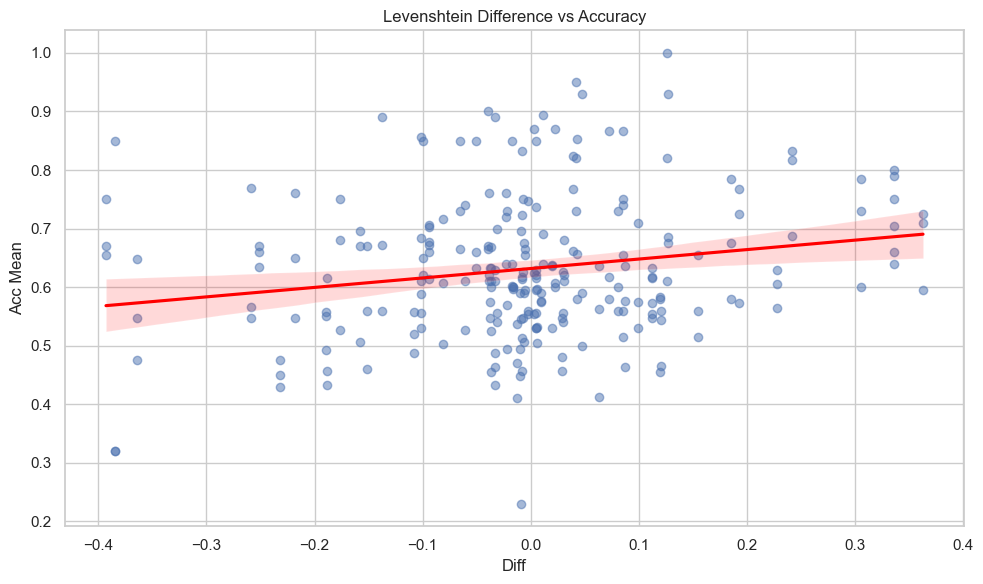

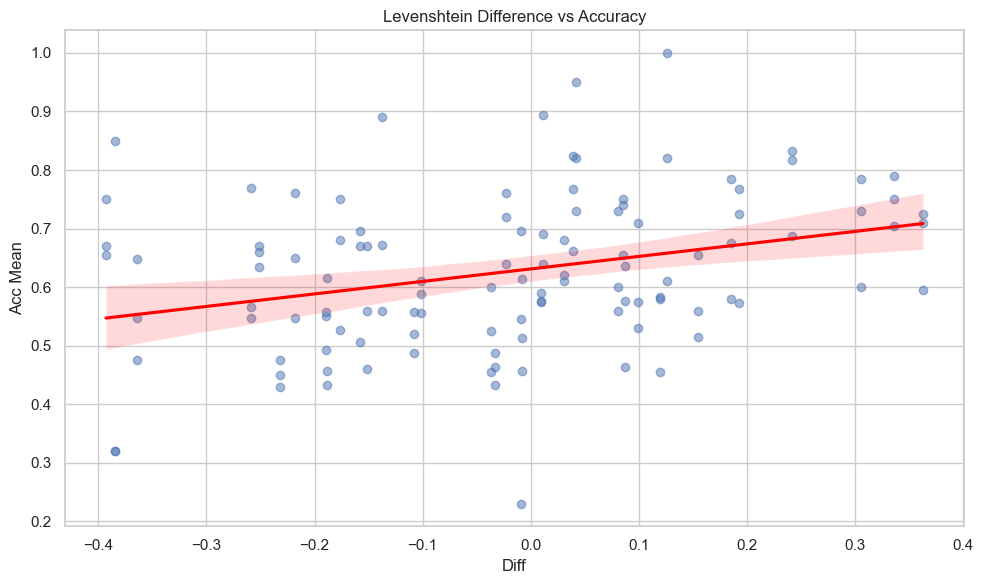

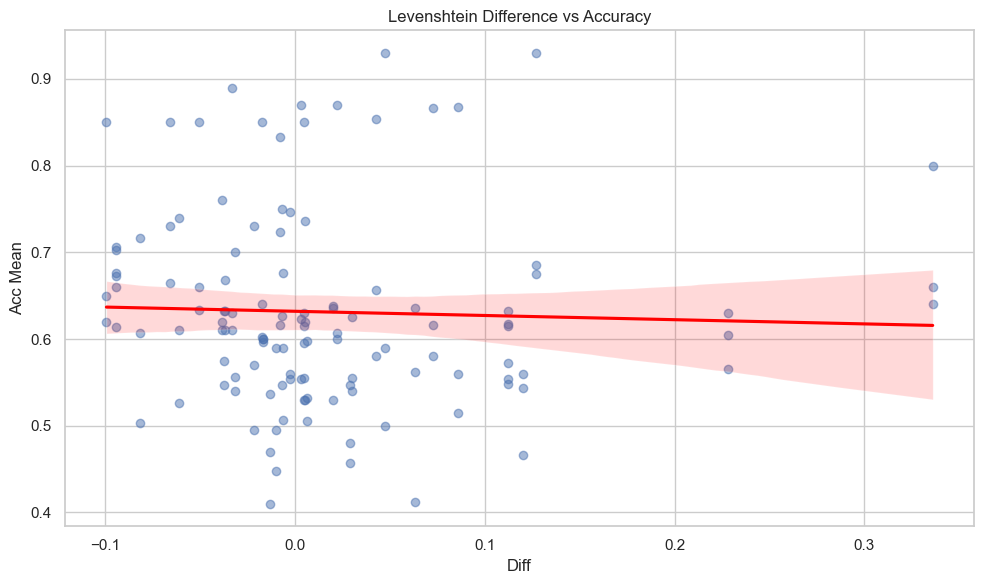

In [154]:
# 查看每个模型的acc_mean和lev_diff的相关性(线性)
def regplot_lev_diff_vs_acc(df: pd.DataFrame, lev_col: str = 'diff', acc_col: str = 'acc_mean', model_name: str = None):
    """
    绘制每个模型的lev_diff和acc_mean的线性回归图
    """
    if model_name:
        df = df[df['model'] == model_name].copy()
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    sns.regplot(data=df, x=lev_col, y=acc_col, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
    
    plt.title(f"Levenshtein Difference vs Accuracy for Model: {model_name}" if model_name else "Levenshtein Difference vs Accuracy")
    plt.xlabel(lev_col.replace('_', ' ').title())
    plt.ylabel(acc_col.replace('_', ' ').title())
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# 忽略qid差异
diff_df_merged_allq = lev_diff_df.copy()

regplot_lev_diff_vs_acc(diff_df_merged_allq, lev_col='diff', acc_col='acc_mean')
para_diff_df_merged_allq = diff_df_merged_allq[diff_df_merged_allq['target'].isin(TGT_PARA)]
synt_diff_df_merged_allq = diff_df_merged_allq[diff_df_merged_allq['target'].isin(TGT_SYNT)]
regplot_lev_diff_vs_acc(para_diff_df_merged_allq, lev_col='diff', acc_col='acc_mean')
regplot_lev_diff_vs_acc(synt_diff_df_merged_allq, lev_col='diff', acc_col='acc_mean')


In [155]:
# 或许可以查看非线性spearman
from scipy.stats import spearmanr
def spearman_lev_diff_vs_acc(df: pd.DataFrame, lev_col: str = 'diff', acc_col: str = 'acc_mean', model_name: str = None):
    """
    计算每个模型的lev_diff和acc_mean的Spearman相关系数
    """
    if model_name:
        df = df[df['model'] == model_name].copy()
    
    corr, p_value = spearmanr(df[lev_col], df[acc_col])
    print(f"Spearman correlation for {model_name if model_name else 'all models'}: {corr:.3f}, p-value: {p_value:.3f}")
# Example calls
spearman_lev_diff_vs_acc(diff_df_merged_allq, lev_col='diff', acc_col='acc_mean')
spearman_lev_diff_vs_acc(para_diff_df_merged_allq, lev_col='diff', acc_col='acc_mean')
spearman_lev_diff_vs_acc(synt_diff_df_merged_allq, lev_col='diff', acc_col='acc_mean')

Spearman correlation for all models: 0.143, p-value: 0.025
Spearman correlation for all models: 0.342, p-value: 0.000
Spearman correlation for all models: -0.169, p-value: 0.062


DKL

In [156]:
import pandas as pd
import numpy as np
from scipy.special import rel_entr

def compute_kl_divergence(p, q, epsilon=1e-10):
    """计算两个分布之间的 KL 散度（避免0）"""
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)

    p /= p.sum()
    q /= q.sum()

    p = np.clip(p, epsilon, 1)
    q = np.clip(q, epsilon, 1)
    return np.sum(rel_entr(p, q))



In [157]:
questions_instance.value_counts('usage')

usage
prmpt_neg       49500
prmpt_pos       49500
question_neg     4950
question_pos     4950
Name: count, dtype: int64

In [158]:

def compute_kl_for_all_targets(df, sim_col='lev_ratio', usage_col='usage', 
                               pos_label='prmpt_pos', neg_label='prmpt_neg',
                               scope_col='scope_id', target_col='target', bins=20):
    """
    对每个 target 在 scope_id == 1 的数据上计算 KL(正例 || 反例)
    返回一个包含 target 和 KL 值的 DataFrame。
    """
    results = []
    df_filtered = df[df[scope_col] == 1]

    for tgt, group in df_filtered.groupby(target_col):
        pos_vals = group[group[usage_col] == pos_label][sim_col].values
        neg_vals = group[group[usage_col] == neg_label][sim_col].values

        # 如果数据不足，则跳过
        if len(pos_vals) < 2 or len(neg_vals) < 2:
            continue

        # 计算分布
        hist_pos, _ = np.histogram(pos_vals, bins=bins, range=(0, 1), density=True)
        hist_neg, _ = np.histogram(neg_vals, bins=bins, range=(0, 1), density=True)

        # 计算 KL 散度
        kl = compute_kl_divergence(hist_pos, hist_neg)
        results.append({'target': tgt, 'kl_divergence': kl})

    return pd.DataFrame(results)

kl_results = compute_kl_for_all_targets(questions_instance, sim_col='lev_ratio', usage_col='usage',
                                        pos_label='prmpt_pos', neg_label='prmpt_neg',
                                        scope_col='scope_id', target_col='target', bins=20)
kl_results[kl_results['target'] == '']  # 查看特定 target 的 KL 散度结果

,target,kl_divergence


In [159]:
# 合并到性能数据
def merge_kl_with_perform(kl_df: pd.DataFrame, perform_df: pd.DataFrame) -> pd.DataFrame:
    """
    Merge kl_results DataFrame with perform_best DataFrame on 'target'.
    """
    merged_df = pd.merge(perform_df, kl_df, on='target', how='left')
    return merged_df
kl_perform_merged = merge_kl_with_perform(kl_results, perform_best_both_nscope)
kl_perform_merged

,model,target,k-shot,scope_id,kw_context,vl_propform,acc_mean,prec_mean,rec_mean,f1_mean,var_by_acc,var_by_f1,kl_divergence
0,LLaMA,A0,10.0,1.5,0.0,0.0,0.675000,0.698500,0.675000,0.650500,0.007100,0.012370,0.252213
1,LLaMA,A1,10.0,2.5,0.0,0.0,0.600000,0.636500,0.600000,0.565750,0.005350,0.010110,1.200921
2,LLaMA,A2,10.0,2.5,0.0,0.0,0.580000,0.600500,0.580000,0.538500,0.003800,0.009392,0.362784
3,LLaMA,A_dériv_ajout_de_sens,10.0,1.5,0.0,0.0,0.455000,0.438500,0.455000,0.416500,0.005500,0.005215,2.423894
4,LLaMA,A_dériv_qualificative,10.0,2.0,0.0,0.0,0.650000,0.671333,0.650000,0.619333,0.005600,0.008884,1.664010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,Qwen,Ver,10.0,2.0,0.0,1.0,0.750000,0.753000,0.750000,0.749333,0.000000,0.000000,0.304782
242,Qwen,Verbe_support,10.0,1.5,0.0,1.0,0.760000,0.779500,0.760000,0.753000,0.000500,0.000548,0.353854
243,Qwen,Verbes_causatifs,10.0,2.0,0.0,1.0,0.716667,0.742000,0.716667,0.707333,0.000400,0.000429,0.167814
244,Qwen,Verbes_de_phase,10.0,2.0,0.0,1.0,0.850000,0.865333,0.850000,0.848000,0.000467,0.000454,0.288701


la distribution de DKL se concentre plutôt entre 0-2.5, et ça n'a pas beaucoup effecté aux performance 

### diif vs coefficient de polarité

In [160]:
questions_instance

,target,Q_id,Q_type,scope_id,keyword,value,usage,lev_ratio
0,Substitutive,1,Q_pos,1,pic,outil,question_pos,0.250
1,Substitutive,1,Q_pos,1,apprendre,apprendre,prmpt_pos,1.000
2,Substitutive,1,Q_pos,1,aspirer,aspirer,prmpt_pos,1.000
3,Substitutive,1,Q_pos,1,créancier,débiteur,prmpt_pos,0.471
4,Substitutive,1,Q_pos,1,slip,maillot de corps,prmpt_pos,0.200
...,...,...,...,...,...,...,...,...
108895,Liqu,80,Q_neg,4,bonnet,tricoter,prmpt_neg,0.286
108896,Liqu,80,Q_neg,4,musicien,orchestre,prmpt_neg,0.235
108897,Liqu,80,Q_neg,4,musicienne,accomplie,prmpt_neg,0.222
108898,Liqu,80,Q_neg,4,cheveu,se laisser pousser le front,prmpt_neg,0.182


In [161]:
# 计算每个targets的每个问题的正负例的差值， 计算模型polarit和levenstein相似度的相关性
# 比较二者的相关性
# 先计算数据里每个问题的正负例的差值
def calculate_positive_negative_difference(df: pd.DataFrame, lev_col: str = 'lev_ratio', usage_col: str = 'usage', qid_col='Q_id', pos_label: str = 'prmpt_pos', neg_label: str = 'prmpt_neg'):
    """
    按照target分组计算每target所有问题的正负例的 Levenshtein 相似度差值的平均。
    只看scope_id == 1 的数据。
    只比较prompt的正负例，不考虑问题类型。
    返回一个 DataFrame，包含问题、正例平均值、负例平均值和差值。

    """
    df_filtered = df[df['scope_id'] == 1]
    results = []

    for target, group in df_filtered.groupby('target'):
        pos_vals = group[group[usage_col] == pos_label][lev_col].values
        neg_vals = group[group[usage_col] == neg_label][lev_col].values

        # 如果数据不足，则跳过
        if len(pos_vals) < 2 or len(neg_vals) < 2:
            continue

        # 计算平均值
        pos_mean = np.mean(pos_vals)
        neg_mean = np.mean(neg_vals)
        diff = pos_mean - neg_mean

        results.append({
            'target': target,
            'pos_mean': pos_mean,
            'neg_mean': neg_mean,
            'difference': diff
        })
    return pd.DataFrame(results)
diff_df = calculate_positive_negative_difference(questions_instance, lev_col='lev_ratio', usage_col='usage', qid_col='Q_id', pos_label='prmpt_pos', neg_label='prmpt_neg')
# 合并到性能数据
diff_df


,target,pos_mean,neg_mean,difference
0,A0,0.714660,0.560555,0.154105
1,A1,0.647170,0.678020,-0.030850
2,A2,0.657200,0.669785,-0.012585
3,A_dériv_ajout_de_sens,0.579400,0.724085,-0.144685
4,A_dériv_qualificative,0.467505,0.665720,-0.198215
...,...,...,...,...
79,Ver,0.223590,0.253660,-0.030070
80,Verbe_support,0.271415,0.309560,-0.038145
81,Verbes_causatifs,0.279820,0.332470,-0.052650
82,Verbes_de_phase,0.294395,0.324590,-0.030195


In [162]:
corl_polarity = corl_levratio_polarity(results_best_both, lev_col='quest_levratio', target_col='target', model_name=None)
diff_df_merged = diff_df.merge(corl_polarity, on='target', how='left')
diff_df_merged

,target,pos_mean,neg_mean,difference,model,correlation_pred,p_value_pred
0,A0,0.714660,0.560555,0.154105,LLaMA,0.394,0.000
1,A0,0.714660,0.560555,0.154105,Mistral,0.462,0.000
2,A0,0.714660,0.560555,0.154105,Qwen,0.340,0.000
3,A1,0.647170,0.678020,-0.030850,LLaMA,0.028,0.575
4,A1,0.647170,0.678020,-0.030850,Mistral,0.161,0.001
...,...,...,...,...,...,...,...
243,Verbes_de_phase,0.294395,0.324590,-0.030195,Mistral,0.016,0.786
244,Verbes_de_phase,0.294395,0.324590,-0.030195,Qwen,-0.071,0.218
245,Vreal,0.362890,0.284780,0.078110,LLaMA,0.086,0.135
246,Vreal,0.362890,0.284780,0.078110,Mistral,-0.232,0.000


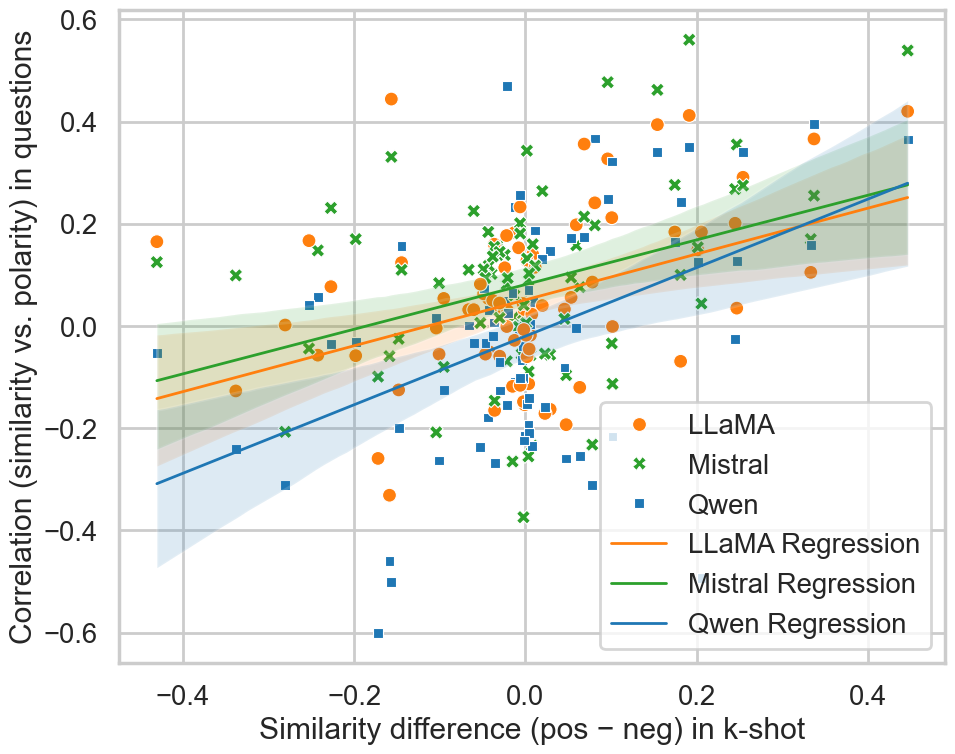

In [194]:
def scatter_diff_vs_polarity(df: pd.DataFrame, diff_col: str = 'difference', polarity_col: str = 'correlation'):
    """
    绘制正负例差值与 polarity 相关性的散点图，并分模型添加回归曲线。
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 8))
    
    # 绘制散点图
    sns.set_context("poster", font_scale=0.9)
    sns.scatterplot(data=df, x=diff_col, y=polarity_col, hue='model', style='model', palette=MODEL_PALETTE, s=100)
    
    # 分模型添加回归曲线
    for model in df['model'].dropna().unique():
        model_data = df[df['model'] == model]
        sns.regplot(data=model_data, x=diff_col, y=polarity_col, scatter=False, label=f"{model} Regression", line_kws={"lw": 2}, color=MODEL_PALETTE[model])
    
    # plt.title("Positive-Negative Difference vs Polarity (By Model)")
    plt.xlabel("Similarity difference (pos − neg) in k-shot")
    plt.ylabel("Correlation (similarity vs. polarity) in questions")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('otpt/levenshtein/diff_vs_polarity.pdf', format='pdf', bbox_inches='tight')
    plt.show()

# Example call
scatter_diff_vs_polarity(diff_df_merged, diff_col='difference', polarity_col='correlation_pred')

## A.2 Scope et granularité

### A.2.1 Scope i+1 de T vs Scope i de Parent(T)

In [164]:

def get_paths_by_terminal_node(structure: dict, current_path: str = "root") -> dict:
    """
    This function recursively traverses the JSON structure and collects paths to each terminal node.
    """
    paths = {}
    if isinstance(structure, dict):
        for k, v in structure.items():
            if v == {}:
                paths[k] = current_path + '.' + k
            else:
                # Create a new path for the recursive call to avoid modifying the current path in place
                new_path = current_path + '.' + k
                # Merge the results of the recursive call into the paths dictionary
                paths.update(get_paths_by_terminal_node(v, current_path=new_path))
    return paths

import json
lfs_structure_simpl = '../data/raw/lfs-structure-v3-simplified.json'
with open(lfs_structure_file, 'r') as f:
    lfs_structure = json.load(f)
paths_mapping = get_paths_by_terminal_node(lfs_structure)
terminal_path ={}
for terminal, path in paths_mapping.items():
    supernodes = list(reversed([supnode for supnode in path.split('.') if supnode not in {'root', 'FL_syntagmatiques', 'FL_paradigmatiques'}]))
    if supernodes:
        terminal_path[terminal] = supernodes

terminal_path

{'Syn': ['Syn', 'Subst_sens_similaire', 'Substitutive'],
 'Gener': ['Gener', 'Subst_sens_similaire', 'Substitutive'],
 'Anti': ['Anti', 'Subst_sens_opposé', 'Substitutive'],
 'Contr': ['Contr', 'Subst_sens_opposé', 'Substitutive'],
 'Conv-ij': ['Conv-ij', 'Subst_sens_opposé', 'Substitutive'],
 'S0': ['S0', 'Dérivation_nominale'],
 'S1': ['S1', 'S_i', 'N_dériv_ajout_de_sens', 'Dérivation_nominale'],
 'S2': ['S2', 'S_i', 'N_dériv_ajout_de_sens', 'Dérivation_nominale'],
 'S3': ['S3', 'S_i', 'N_dériv_ajout_de_sens', 'Dérivation_nominale'],
 'Sinstr': ['Sinstr',
  'N_dériv_circonstancielle',
  'N_dériv_ajout_de_sens',
  'Dérivation_nominale'],
 'Sloc': ['Sloc',
  'N_dériv_circonstancielle',
  'N_dériv_ajout_de_sens',
  'Dérivation_nominale'],
 'Sres': ['Sres',
  'N_dériv_circonstancielle',
  'N_dériv_ajout_de_sens',
  'Dérivation_nominale'],
 'A0': ['A0', 'Dérivation_adjectivale'],
 'A1': ['A1', 'A_i', 'A_dériv_ajout_de_sens', 'Dérivation_adjectivale'],
 'A2': ['A2', 'A_i', 'A_dériv_ajout_d

In [165]:
perform_best_both = calculate_metrics_by_model_kshot_target(
    df=results_best, 
    repeat_col='repeat_num',  
    kshot_col='k-shot',  
    target_col='target',
    scope_col='scope_id',
    context_col='kw_context',
    propform_col='vl_propform'
)

In [166]:
def rscope(df):
    """
    计算每个target的scope_id, 得到每个target的scope_id的个数，就是最大值
    rscope = max_scope - scope_id + 1
    """
    df = df.copy()
    df['scope_id'] = df['scope_id'].astype(int)  # 确保scope_id是整数类型
    df['rscope'] = df.groupby('target')['scope_id'].transform(lambda x: x.max() - x + 1)
    return df
new_perfm = rscope(perform_best_both)
new_perfm

,model,k-shot,target,scope_id,kw_context,vl_propform,acc_mean,prec_mean,rec_mean,f1_mean,var_by_acc,var_by_f1,rscope
1,LLaMA,10,A0,2,0,0,0.73,0.752,0.73,0.714,0.0096,0.014730,1
0,LLaMA,10,A0,1,0,0,0.62,0.645,0.62,0.587,0.0046,0.010011,2
3,LLaMA,10,A1,2,0,0,0.63,0.659,0.63,0.602,0.0096,0.013931,3
5,LLaMA,10,A1,4,0,0,0.63,0.680,0.63,0.600,0.0046,0.010920,1
2,LLaMA,10,A1,1,0,0,0.57,0.617,0.57,0.520,0.0046,0.010633,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,Qwen,10,Verbes_de_phase,2,0,1,0.84,0.864,0.84,0.837,0.0004,0.000391,2
743,Qwen,10,Verbes_de_phase,3,0,1,0.82,0.841,0.82,0.817,0.0006,0.000566,1
746,Qwen,10,Vreal,3,0,1,0.71,0.817,0.71,0.682,0.0014,0.002416,1
744,Qwen,10,Vreal,1,0,1,0.62,0.760,0.62,0.562,0.0006,0.001197,3


In [167]:
new_perfm.value_counts('rscope')

rscope
1    246
2    219
3    165
4     90
5     27
Name: count, dtype: int64

In [168]:
def plot(
    df: pd.DataFrame, 
    branch_mapping: dict,
    target_col: str = 'target', 
    scope: int = 2,
    scope_col: str = 'scope_id', 
    recall_col: str = 'rec_mean',
    prec_mean_col: str = 'prec_mean',
    acc_col: str = 'acc_mean', 
    f1_col: str = 'f1_mean'
):
    """
    为每个 branch_mapping 的 key 画一个四联图：acc, f1, precision, recall
    每个横坐标为从叶到根的节点名，展示两个系列：
    - 本节点 scope=2 的点（实线连接）
    - 下一个节点 scope=1 的点（虚线连接）
    """
    metrics = {
        'Accuracy': acc_col,
        'F1 Score': f1_col,
        'Precision': prec_mean_col,
        'Recall': recall_col,
    }

    for branch_name, node_list in branch_mapping.items():
        fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
        fig.suptitle(f"Performance along branch: {branch_name}", fontsize=14)

        models = df['model'].unique()
        color_map = {model: sns.color_palette()[i] for i, model in enumerate(models)}

        # Flatten axes for easy iteration
        axes_flat = axes.flatten()

        for ax, (metric_name, metric_col) in zip(axes_flat, metrics.items()):
            for model in models:
                vals_scope2 = []
                vals_scope1 = []
                xticks = node_list  # 原始顺序，叶到根

                for i, node in enumerate(node_list):
                    # 当前节点 scope=2
                    v2 = df[
                        (df[target_col] == node) &
                        (df[scope_col] == 2) &
                        (df['model'] == model)
                    ]
                    vals_scope2.append(v2[metric_col].values[0] if not v2.empty else None)

                    # 当前节点的下一个节点 scope=1（注意：是下一个）
                    if i + 1 < len(node_list):
                        next_node = node_list[i + 1]
                        v1 = df[
                            (df[target_col] == next_node) &
                            (df[scope_col] == 1) &
                            (df['model'] == model)
                        ]
                        vals_scope1.append(v1[metric_col].values[0] if not v1.empty else None)
                    else:
                        vals_scope1.append(None)

                # 横坐标编号（用于画线）
                x_ids = list(range(len(node_list)))

                # 画实线：scope=2 自己的值
                valid_x2 = [x for x, y in zip(x_ids, vals_scope2) if y is not None]
                valid_y2 = [y for y in vals_scope2 if y is not None]
                ax.plot(valid_x2, valid_y2, marker='o', linestyle='solid',
                        color=color_map[model], label=model)

                # 画虚线：下一个节点 scope=1 的值
                valid_x1 = [x for x, y in zip(x_ids, vals_scope1) if y is not None]
                valid_y1 = [y for y in vals_scope1 if y is not None]
                ax.plot(valid_x1, valid_y1, marker='o', linestyle='dashed',
                        color=color_map[model])

            ax.set_title(metric_name)
            ax.set_ylabel(metric_name)
            ax.set_xlabel("Node")
            ax.set_xticks(range(len(node_list)))
            ax.set_xticklabels(node_list, rotation=45, ha='right')
            ax.grid(True, linestyle='--', alpha=0.5)

        handles, labels = axes_flat[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', ncol=len(models))
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()

# Example usage
# plot(
#     df=perform_best_both, 
#     branch_mapping=terminal_path,
#     target_col='target',
#     scope=2,
#     scope_col='scope_id',
#     recall_col='rec_mean',
#     prec_mean_col='prec_mean',
#     acc_col='acc_mean',
#     f1_col='f1_mean'
# )

### A.2.2 Effet de scopes par branch dans l'hiérarchie mais à l'envers

In [169]:
def lineplot_rscope_granularity(
    df: pd.DataFrame, 
    branch_mapping: dict,
    target_col: str = 'target', 
    _rscope: int = 1,
    rscope_col: str = 'rscope', 
    recall_col: str = 'rec_mean',
    prec_mean_col: str = 'prec_mean',
    acc_col: str = 'acc_mean', 
    f1_col: str = 'f1_mean'
):
    """
    For each terminal node, plot 4 subplots: recall, precision, accuracy, f1 score.
    X-axis: supernodes path (from root to terminal), Y-axis: metric value.
    Only use rows with rscope == _rscope.
    Each line: a model.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    required_cols = [target_col, rscope_col, recall_col, prec_mean_col, acc_col, f1_col, 'model']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")

    df_filtered = df[df[rscope_col] == _rscope]

    metrics = {
        recall_col: 'Recall',
        prec_mean_col: 'Precision',
        acc_col: 'Accuracy',
        f1_col: 'F1 Score'
    }

    for terminal, supnodes in branch_mapping.items():
        # Only plot if terminal is in the data
        if terminal not in df_filtered[target_col].unique():
            continue
        # Prepare data for this terminal: for each supernode in the path, get the metric value if exists
        # path = list(reversed(supnodes))  # from root to terminal
        path = supnodes  # from terminal to root
        plot_data = []
        for model in df_filtered['model'].unique():
            for i, node in enumerate(path):
                row = df_filtered[(df_filtered[target_col] == node) & (df_filtered['model'] == model)]
                if not row.empty:
                    plot_data.append({
                        'model': model,
                        'node': node,
                        recall_col: row.iloc[0][recall_col],
                        prec_mean_col: row.iloc[0][prec_mean_col],
                        acc_col: row.iloc[0][acc_col],
                        f1_col: row.iloc[0][f1_col],
                        'order': i
                    })
        if not plot_data:
            continue
        plot_df = pd.DataFrame(plot_data)
        # Sort nodes by their order in the path
        plot_df = plot_df.sort_values('order')
        # Plot
        fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
        axes = axes.flatten()
        for i, (metric_col, ylabel) in enumerate(metrics.items()):
            ax = axes[i]
            sns.lineplot(
                data=plot_df,
                x='node',
                y=metric_col,
                hue='model',
                marker='o',
                ax=ax,
                palette=MODEL_PALETTE if 'MODEL_PALETTE' in globals() else None,
            )
            # ax.set_title(f"{ylabel} for {terminal} (rscope={_rscope})")
            ax.set_xlabel('Branch nodes')
            plt.setp(ax.get_xticklabels(), rotation=90)
            ax.set_ylabel(ylabel)
            ax.legend(title='Model', loc='best')
            ax.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.suptitle(f"Performance Metrics by Terminal Node: {terminal} (rscope={_rscope})", fontsize=12, y=1.02)
        plt.show()

# lineplot_rscope_granularity(
#     df=new_perfm, 
#     branch_mapping=terminal_path,
#     target_col='target', 
#     _rscope=1,
#     rscope_col='rscope', 
#     recall_col='rec_mean',
#     prec_mean_col='prec_mean',
#     acc_col='acc_mean', 
#     f1_col='f1_mean'
# )

### A.2.3 generally effet de scope

In [170]:
def lineplot_rscope_granularity_all(
    df: pd.DataFrame, 
    recope_col: str = 'rscope',
    model_col: str = 'model',
    metric_cols: list = ['acc_mean', 'f1_mean', 'prec_mean', 'rec_mean']
):
    """
    绘制所有模型在不同rscope下的性能指标变化趋势。
    每个模型一条线，x轴为rscope（整数），y轴为性能指标。
    """

    # 确保必要的列存在
    required_cols = [recope_col, model_col] + metric_cols
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")

    sns.set_theme(style="whitegrid")

    # 创建 2x2 子图
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)
    axes = axes.flatten()

    for i, metric_col in enumerate(metric_cols):
        ax = axes[i]
        sns.lineplot(
            data=df,
            x=recope_col,
            y=metric_col,
            hue=model_col,
            marker='o',
            palette=MODEL_PALETTE if 'MODEL_PALETTE' in globals() else None,
            ax=ax,
            errorbar=None  # 关闭误差条
        )
        ax.set_title(f"{metric_col.replace('_', ' ').title()} by Rscope")
        ax.set_xlabel("Rscope")
        ax.set_ylabel(metric_col.replace('_', ' ').title())
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(title='Model', loc='best')

        # 将横坐标设置为整数
        ax.set_xticks(sorted(df[recope_col].unique()))
        ax.set_xticklabels(sorted(df[recope_col].unique()))

    # 调整布局
    plt.tight_layout()
    plt.show()
    plt.close()


# Example usage
# lineplot_rscope_granularity_all(
#     df=new_perfm,
#     recope_col='rscope',      
#     model_col='model',
#     metric_cols=['acc_mean', 'f1_mean', 'prec_mean', 'rec_mean']
# )

regrouper par le maximum de scope

In [171]:
# 先给targets分组，然后每组画一个图，展现他们在自己的scope下的性能指标变化趋势。
def group_targets_by_scope(df)-> dict:
    """
    按照scope_id分组：我们全局scopeid最大的是scope_max， 我们按照scope的id分为：
    scope至少为max的，
    scopes至少为max-1的， scopes为max-2的， 。。。。scope至少为2的
    """
    # 确保scope_id是整数类型
    df['scope_id'] = df['scope_id'].astype(int)
    # 获取全局最大scope_id
    scope_max = df['scope_id'].max()
    # 按照scope_id分组
    scope_groups = {}
    for scope in range(2, scope_max + 1):
        # 获取当前scope的targets
        targets = df[df['scope_id'] >= scope]['target'].unique()
        if targets.size > 0:
            scope_groups[f'N_scope >= {scope}'] = targets.tolist()
    return scope_groups
scope_groups = group_targets_by_scope(new_perfm)
scope_groups

{'N_scope >= 2': ['A0',
  'A1',
  'A2',
  'A_dériv_ajout_de_sens',
  'A_dériv_qualificative',
  'A_i',
  'Able1',
  'Able2',
  'Able_i',
  'Adv0',
  'Adv1',
  'Anti',
  'Bon',
  'Cap',
  'Caus',
  'Contr',
  'Conv-ij',
  'Epit',
  'Equip',
  'Fact0',
  'Fact1',
  'Fact2',
  'Fact_i',
  'Fin',
  'Func0',
  'Func2',
  'Func_i',
  'Gener',
  'Groupe',
  'Incep',
  'Instr',
  'Labreal12',
  'Liqu',
  'Loc',
  'Magn',
  'Modif_ajout_de_sens',
  'Modif_sens_vide',
  'Mult',
  'N_dériv_ajout_de_sens',
  'N_dériv_circonstancielle',
  'Oper1',
  'Oper2',
  'Oper_i',
  'Pred',
  'Qual1',
  'Real1',
  'Real2',
  'Real3',
  'Real_i',
  'RealΩ',
  'Redun',
  'Result2',
  'S0',
  'S1',
  'S2',
  'S3',
  'S_i',
  'Sing',
  'Sinstr',
  'Sloc',
  'Sres',
  'Subst_sens_opposé',
  'Subst_sens_similaire',
  'Syn',
  'Unité',
  'V0',
  'V_collocation_ajout_de_sens',
  'V_dériv_sens_vide',
  'Ver',
  'Verbe_support',
  'Verbes_causatifs',
  'Verbes_de_phase',
  'Vreal'],
 'N_scope >= 3': ['A1',
  'A2',
  'A

FileNotFoundError: [Errno 2] No such file or directory: 'otpt/graphs_by_groups_of_different_Rscopes/N_scope_>=_2.pdf'

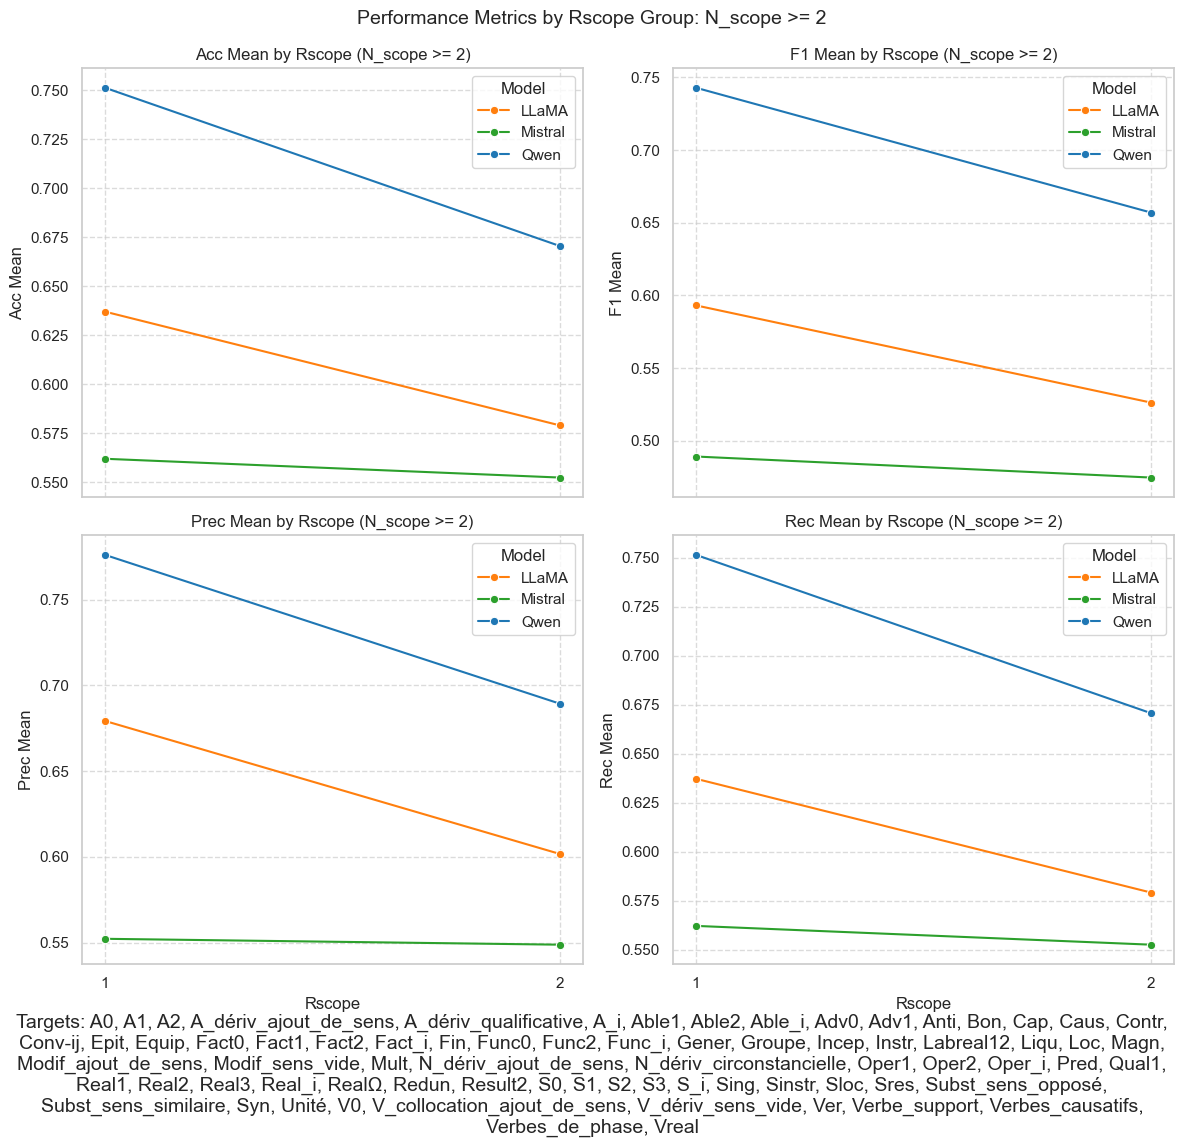

In [172]:
def lineplot_rscope_groups_with_targets(df: pd.DataFrame, 
                                        rscope_col: str = 'scope_id',
                                        model_col: str = 'model',
                                        metric_cols: list = ['acc_mean', 'f1_mean', 'prec_mean', 'rec_mean']):
    """
    为每个 scope 组绘制性能指标变化趋势，并在图的最下面备注该组 targets 的名称。
    """
    # 确保必要的列存在
    required_cols = [rscope_col, model_col] + metric_cols
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")
    
    scope_groups = group_targets_by_scope(df)
    sns.set_theme(style="whitegrid")
    
    for group_name, targets in scope_groups.items():
        # 过滤出当前组的 targets
        group_df = df[df['target'].isin(targets)]
        # 求出每个 target 的最大 scope_id
        max_scopes = group_df.groupby('target')[rscope_col].max().reset_index()
        # 获取该组的最小最大 scope_id
        min_max_scope = max_scopes[rscope_col].min()
        # 过滤出当前组的 scope_id
        group_df = group_df[group_df[rscope_col] <= min_max_scope]
        # 如果组内没有数据，跳过
        if group_df.empty:
            continue
        
        # 创建 2x2 子图
        fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)
        axes = axes.flatten()
        
        for i, metric_col in enumerate(metric_cols):
            ax = axes[i]
            sns.lineplot(
                data=group_df,
                x=rscope_col,
                y=metric_col,
                hue=model_col,
                marker='o',
                palette=MODEL_PALETTE if 'MODEL_PALETTE' in globals() else None,
                ax=ax,
                errorbar=None  # 关闭误差条
            )
            ax.set_title(f"{metric_col.replace('_', ' ').title()} by Rscope ({group_name})")
            ax.set_xlabel("Rscope")
            ax.set_ylabel(metric_col.replace('_', ' ').title())
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.legend(title='Model', loc='best')

            # 将横坐标设置为整数
            ax.set_xticks(sorted(group_df[rscope_col].unique()))
            ax.set_xticklabels(sorted(group_df[rscope_col].unique()))
        
        # 添加 targets 名称备注
        targets_text = ', '.join(targets)
        fig.text(0.5, -0.1, f"Targets: {targets_text}", ha='center', fontsize=14, wrap=True)  # 将备注放在图的最下面
        
        # 调整布局
        plt.tight_layout()
        plt.suptitle(f"Performance Metrics by Rscope Group: {group_name}", fontsize=14, y=1.02)
        plt.savefig(f'otpt/graphs_by_groups_of_different_Rscopes/{group_name.replace(" ", "_")}.pdf', format='pdf', bbox_inches='tight')
        plt.show()
        plt.close()

# Example usage
lineplot_rscope_groups_with_targets(
    df=new_perfm,
    rscope_col='rscope',
    model_col='model',
    metric_cols=['acc_mean', 'f1_mean', 'prec_mean', 'rec_mean']
)

## granularity 

In [174]:
def get_paths(tree, prefix=None, skip_keys={"FL_paradigmatiques", "FL_syntagmatiques"}, path_map=None):
    if prefix is None:
        prefix = []
    if path_map is None:
        path_map = {}

    for key, subtree in tree.items():
        # 构造路径，并跳过顶级标识
        next_prefix = prefix + ([] if key in skip_keys else [key])

        # 只记录一次（首次出现的路径）
        if key not in skip_keys and key not in path_map:
            path_map[key] = next_prefix

        # 继续递归
        if isinstance(subtree, dict):
            get_paths(subtree, next_prefix, skip_keys, path_map)

    return path_map

all_node_paths = get_paths(lfs_structure)
all_node_paths

{'Substitutive': ['Substitutive'],
 'Subst_sens_similaire': ['Substitutive', 'Subst_sens_similaire'],
 'Syn': ['Substitutive', 'Subst_sens_similaire', 'Syn'],
 'Gener': ['Substitutive', 'Subst_sens_similaire', 'Gener'],
 'Subst_sens_opposé': ['Substitutive', 'Subst_sens_opposé'],
 'Anti': ['Substitutive', 'Subst_sens_opposé', 'Anti'],
 'Contr': ['Substitutive', 'Subst_sens_opposé', 'Contr'],
 'Conv-ij': ['Substitutive', 'Subst_sens_opposé', 'Conv-ij'],
 'Dérivation_nominale': ['Dérivation_nominale'],
 'S0': ['Dérivation_nominale', 'S0'],
 'N_dériv_ajout_de_sens': ['Dérivation_nominale', 'N_dériv_ajout_de_sens'],
 'S_i': ['Dérivation_nominale', 'N_dériv_ajout_de_sens', 'S_i'],
 'S1': ['Dérivation_nominale', 'N_dériv_ajout_de_sens', 'S_i', 'S1'],
 'S2': ['Dérivation_nominale', 'N_dériv_ajout_de_sens', 'S_i', 'S2'],
 'S3': ['Dérivation_nominale', 'N_dériv_ajout_de_sens', 'S_i', 'S3'],
 'N_dériv_circonstancielle': ['Dérivation_nominale',
  'N_dériv_ajout_de_sens',
  'N_dériv_circonstanciel

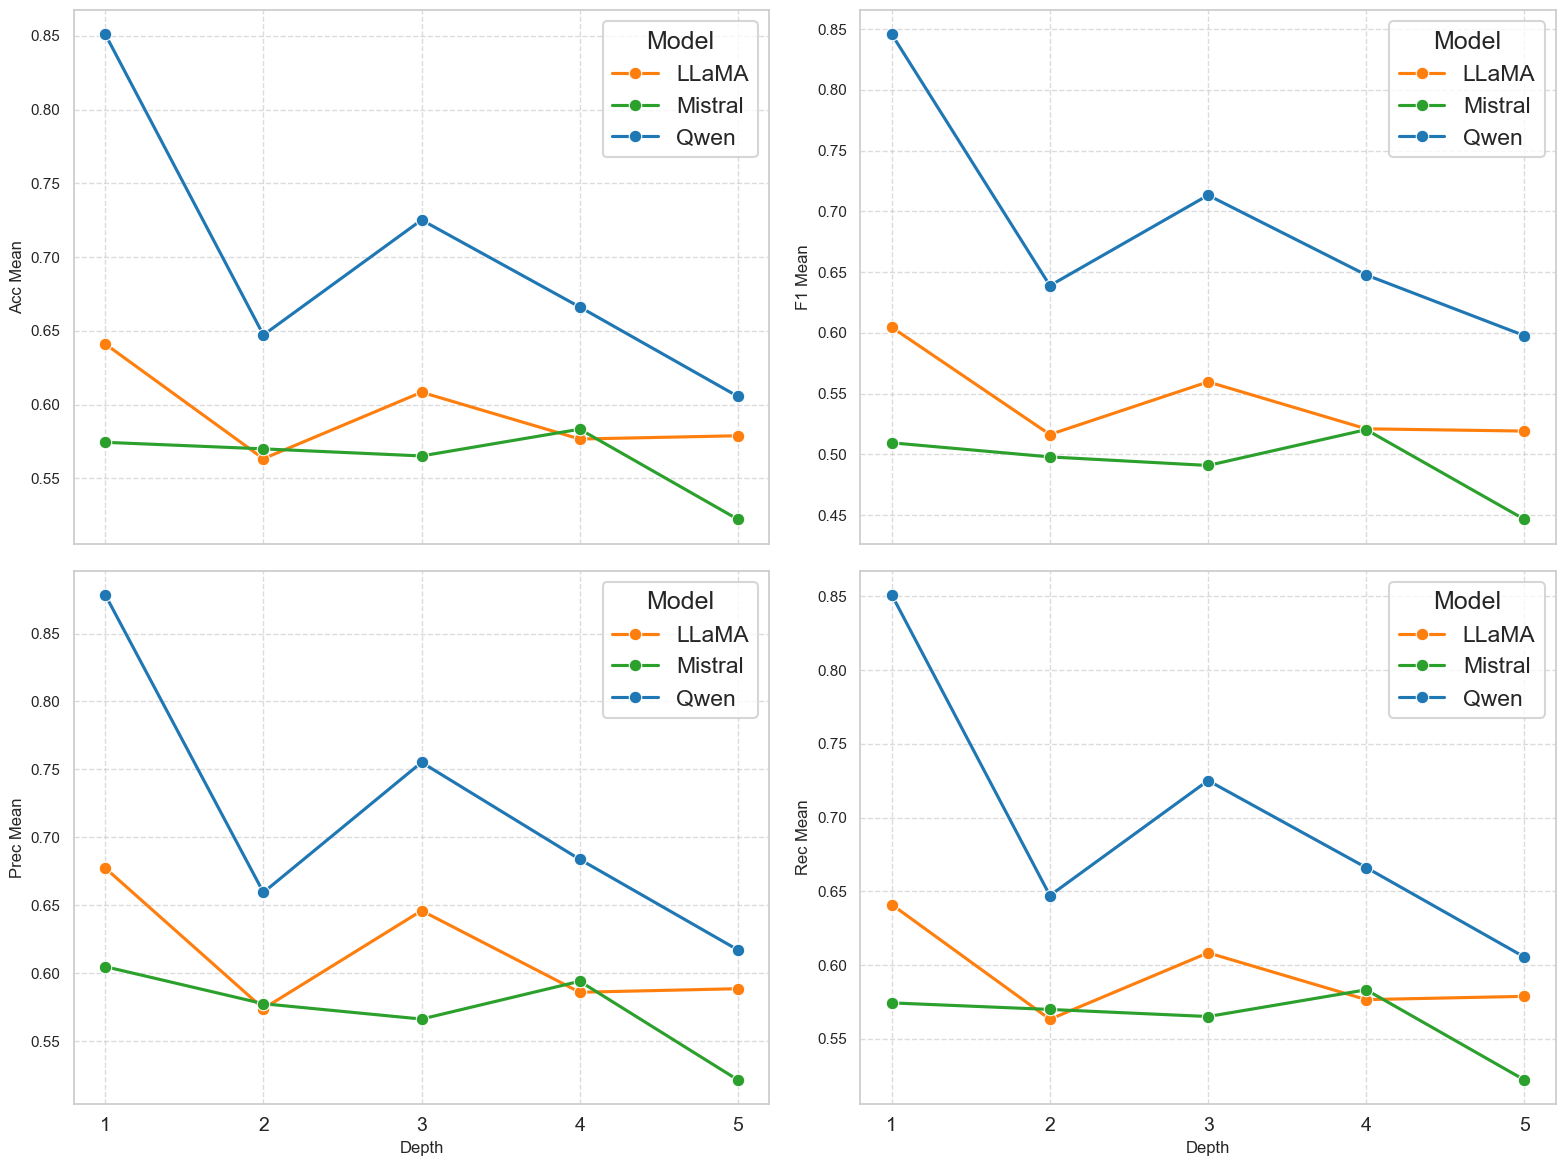

In [175]:
"""先根据每个node的path长度计算深度，然后按照深度分组，最后画出每个深度下targets的性能均值指标变化趋势。"""

def group_targets_by_depth(df: pd.DataFrame, scope_col='scope_id', target_col: str = 'target', lfs_structure: dict = None, scope: int = None):
    """
    找出每个节点对应的path，len(path)即为深度。
    把深度添加到df的每个target上，
    筛选scope_id为1的targets，
    根据深度分组，从浅到深，计算每个深度下的targets的性能均值指标变化趋势。
    一个模型一个颜色，x轴为深度，y轴为性能指标。
    """
    node_paths = get_paths(lfs_structure)
    # 添加深度信息到DataFrame
    df['depth'] = df[target_col].map(lambda x: len(node_paths.get(x, [])) if x in node_paths else 0)
    # 过滤出scope_id为1的targets
    if scope is not None:
        df_filtered = df[df[scope_col] == scope].copy()
        # 默认只筛选scope_id为1的targets
    else:
        df_filtered = df.copy()
    # 直接按照深度画图
    # 每个模型一条线
    # 横坐标为深度，纵坐标为按深度分组后的性能指标平均值
    metrics = ['acc_mean', 'f1_mean', 'prec_mean', 'rec_mean']
    
    # 创建一个大图包含四个子图
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)
    axes = axes.flatten()
    sns.set_context("talk")
    for i, metric in enumerate(metrics):
        ax = axes[i]
        sns.lineplot(
            data=df_filtered,
            x='depth',
            y=metric,
            hue='model',
            marker='o',
            palette=MODEL_PALETTE if 'MODEL_PALETTE' in globals() else None,
            errorbar=None,  # 不显示置信区间
            ax=ax
        )
        # ax.set_title(f"{metric.replace('_', ' ').title()}")
        ax.set_xlabel("Depth")
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.set_xticks(range(df_filtered['depth'].min(), df_filtered['depth'].max() + 1))
        ax.tick_params(axis='x', labelsize=14)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(title='Model', loc='best')
    
    # 调整布局
    plt.tight_layout()
    # plt.suptitle("Performance Metrics by Depth", fontsize=16, y=1.02)
    plt.show()

# Example usage
group_targets_by_depth(
    df=new_perfm,
    scope_col='scope_id',
    target_col='target',
    lfs_structure=lfs_structure,
    scope=1  # 只筛选scope_id为1的targets
)

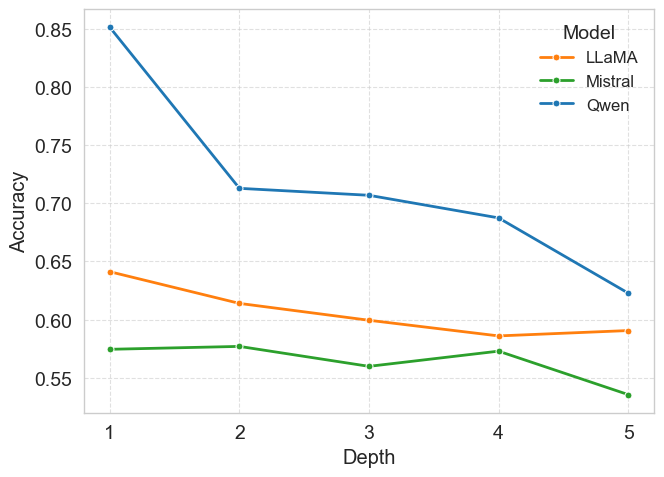

In [178]:
def group_targets_by_depth(df: pd.DataFrame, scope_col='scope_id', target_col: str = 'target', lfs_structure: dict = None):
    """
    分析每个target在层级结构中的深度，绘制不同深度下的模型平均性能，仅绘制Accuracy。
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # 构建路径字典并提取深度
    node_paths = get_paths(lfs_structure)
    df['depth'] = df[target_col].map(lambda x: len(node_paths.get(x, [])) if x in node_paths else 0)
    
    # 仅保留 scope_id == 1 的子集
    df_filtered = df[df[scope_col] <= 2].copy()
    if df_filtered.empty:
        print("No data to plot after filtering for scope_id == 1.")
        return
    
    # 配置
    sns.set_context("paper", font_scale=1.5)  # 小号字号
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=(6.8, 5.2))  # 单栏宽度，6.8 inch 左右

    # 绘图
    for model in df_filtered['model'].unique():
        model_data = df_filtered[df_filtered['model'] == model]
        sns.lineplot(
            data=model_data,
            x='depth',
            y='acc_mean',
            label=model,
            linestyle='solid',
            linewidth=2,
            marker='o',
            markersize=5,
            color=MODEL_PALETTE[model],
            errorbar=None  # 不显示置信区间
        )

    # 图形设置
    plt.xlabel("Depth")
    plt.ylabel("Accuracy")
    plt.xticks(sorted(df_filtered['depth'].unique()))
    plt.tick_params(axis='both', labelsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    # 添加图例
    plt.legend(
        title='Model',
        fontsize=12,
        title_fontsize=14,
        frameon=False,

    )


    # 保存图像
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # 调整图例位置
    plt.savefig('otpt/graphs_by_depth_acc.pdf', format='pdf', bbox_inches='tight')  # 保存为PDF格式
    plt.show()

# Example usage
group_targets_by_depth(
    df=new_perfm,
    scope_col='scope_id',
    target_col='target',
    lfs_structure=lfs_structure
)

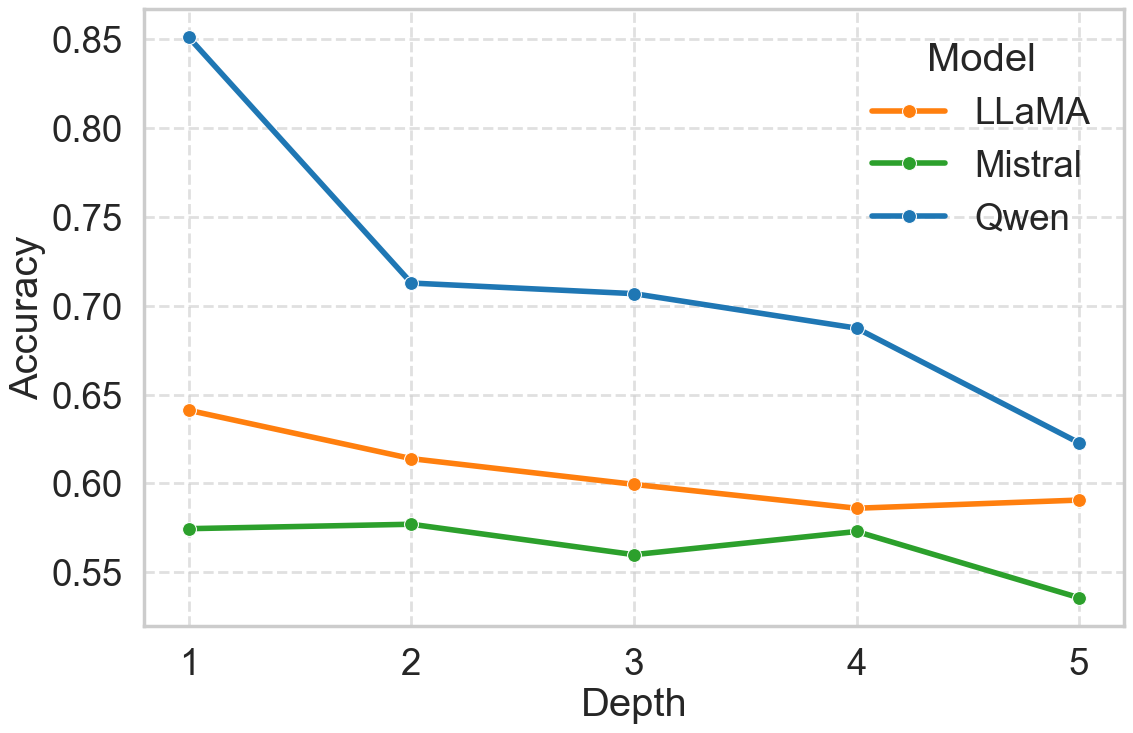

In [184]:
def group_targets_by_depth(df: pd.DataFrame, scope_col='scope_id', target_col: str = 'target', lfs_structure: dict = None):
    """
    分析每个target在层级结构中的深度，绘制不同深度下的模型平均性能，仅绘制Accuracy。
    适配poster尺寸，自动放大字体，无手动字体定义。
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # 构建路径字典并提取深度
    node_paths = get_paths(lfs_structure)
    df['depth'] = df[target_col].map(lambda x: len(node_paths.get(x, [])) if x in node_paths else 0)
    
    # 仅保留 scope_id <= 2 的子集
    df_filtered = df[df[scope_col] <= 2].copy()
    if df_filtered.empty:
        print("No data to plot after filtering for scope_id <= 2.")
        return
    
    # 配置：poster 尺寸 & 自动大号字体
    sns.set_context("poster", font_scale=1.2)  
    plt.figure(figsize=(12, 8))  # 海报尺寸更大一些

    # 绘图
    for model in df_filtered['model'].unique():
        model_data = df_filtered[df_filtered['model'] == model]
        sns.lineplot(
            data=model_data,
            x='depth',
            y='acc_mean',
            label=model,
            linestyle='solid',
            linewidth=4,
            marker='o',
            markersize=10,
            color=MODEL_PALETTE[model],
            errorbar=None
        )

    # 图形设置
    plt.xlabel("Depth")
    plt.ylabel("Accuracy")
    plt.xticks(sorted(df_filtered['depth'].unique()))
    plt.grid(True, linestyle='--', alpha=0.6)

    # 添加图例（不指定字体）
    plt.legend(title='Model', frameon=False)

    # 保存图像
    plt.tight_layout()
    plt.savefig('otpt/graphs_by_depth_acc.pdf', format='pdf', bbox_inches='tight')
    plt.show()
group_targets_by_depth(
    df=new_perfm,
    scope_col='scope_id',
    target_col='target',
    lfs_structure=lfs_structure
)

## 分semantic和syntatic来看granularity

In [94]:
# 定义语义和句法的粒度
SEM_GRAN = {
    'Subst_sem_similar/opposite': (['Subst_sens_similaire', 'Subst_sens_opposé'], ['Syn','Anti', 'Gener', 'Conv-ij', 'Contr', 'Conv-ij*']),
    'Deriv_N_sem_addition': (['N_dériv_ajout_de_sens'], ['Si', 'N_dériv_circonstancielle']),
    'Deriv_N_Circontance': (['N_dériv_circonstancielle'], ['Sres', 'Sloc', 'Sinstr']),
    'Deriv_Adj_sem_addition': (['A_dériv_ajout_de_sens'], ['A_dériv_qualificative']),
    'Deriv_V_sem_empty': (['V_dériv_sens_vide'], ['V0', 'Pred']),
    "Modifiers": (['Modif_ajout_de_sens', 'Modif_sens_vide'], ['Magn', 'Bon', 'Ver', 'Epit', 'Redun']),
    "Colloc_N_'singular'": (['Singulier'], ['Sing', 'Cap']),
    'Colloc_V_sem_addition': (['V_collocation_ajout_de_sens'], ['Vreal', 'Verbes_de_phase', 'Verbes_causatifs']), 
    'Causative_Verbs': (['Verbes_causatifs'], ['Caus', 'Liqu']),
    'Phasique_Verbs': (['Verbes_de_phase'], ['Incep', 'Fin'])
}
STX_GRAN = {
    'Deriv_N_Actants': (['S_i'], ['S1', 'S2', 'S3']),
    'Deriv_Adj_Arg': (['A_i'], ['A1', 'A2']),
    'Deriv_Adj_Qualif': (['Able_i'], ['Able1', 'Able2']),
    'Support_Verbs': (['Verbe_support'], ['Func_i', 'Oper_i']),
    'Vreal': (['Vreal'], ['Fact_i', 'Real_i', 'Labreal12']),
    'Oper_i': (['Oper_i'], ['Oper1', 'Oper2']),
    'Func_i': (['Func_i'], ['Func0', 'Func2']),
    'Fact_i': (['Fact_i'], ['Fact0', 'Fact1', 'Fact2']),
    'Real_i': (['Real_i'], ['RealΩ', 'Real1', 'Real2', 'Real3']),
}

/var/folders/04/mz2jyny17hz88wzglmzrlwpr0000gn/T/ipykernel_76210/961951545.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=20)


FileNotFoundError: [Errno 2] No such file or directory: 'otpt/graphs_by_granularity/Qwen_granularity_performance_STX_GRAN.pdf'

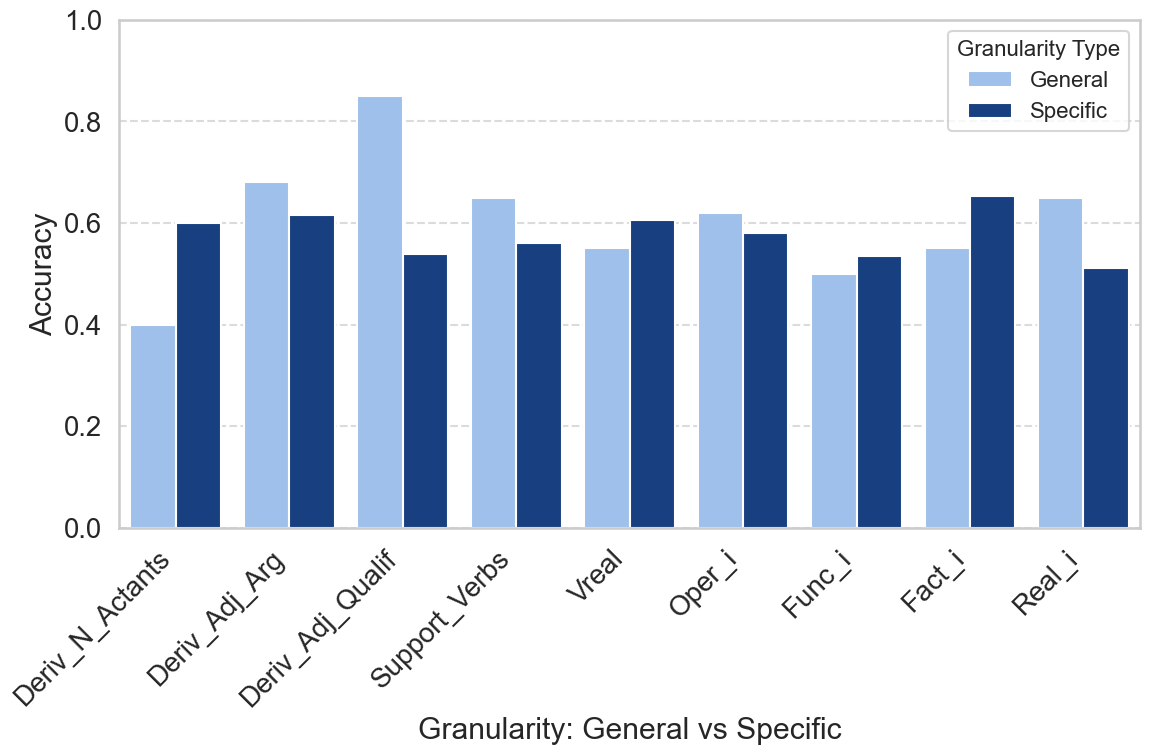

In [95]:
def barplot_granularity_by_sem_stx(df: pd.DataFrame, 
                                   granularity_dict: dict = STX_GRAN,
                                   model_name: str = 'Qwen',
                                   metric_col: str = 'acc_mean',
                                   target_col: str = 'target',
                                   scope_col: str = 'scope_id',
                                   model_col: str = 'model'):
    """
    使用sns.barplot绘制语义和句法粒度的条形图，展示每个粒度下的模型性能指标。
    根据SEM_GRAN和STX_GRAN字典定义的粒度，绘制每个粒度的General和Specific性能对比。
    关于x轴：dict的key对应横坐标轴的bars pair，dict的第一个列表是general节点，对应的xtick使用dict里对应的键，第二个列表是specific节点。对应pair的第二个bar， x轴使用第二个列表的前两个作为xtick，如果多于2个就加etc。
    """
    # 确保必要的列存在
    required_cols = [target_col, model_col, metric_col]
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")
    
    # 过滤出指定模型的数据
    df = df[df[scope_col] == 1].copy()  # 只看scope_id == 1的数据
    df_filtered = df[df[model_col] == model_name].copy()
    if df_filtered.empty:
        print(f"No data found for model: {model_name}")
        return
    
    # 准备绘图数据
    plot_data = []
    for granularity, (general_nodes, specific_nodes) in granularity_dict.items():
        general_mean = df_filtered[df_filtered[target_col].isin(general_nodes)][metric_col].mean()
        specific_mean = df_filtered[df_filtered[target_col].isin(specific_nodes)][metric_col].mean()
        plot_data.append({'Granularity: General vs Specific': granularity, 'Type': 'General', 'Accuracy': general_mean})
        plot_data.append({'Granularity: General vs Specific': granularity, 'Type': 'Specific', 'Accuracy': specific_mean})
    
    plot_df = pd.DataFrame(plot_data)
    
    # 设置绘图风格
    sns.set_theme(style="whitegrid")
    sns.set_context("talk", font_scale=1.2)
    
    # 绘制条形图
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        data=plot_df,
        x='Granularity: General vs Specific',
        y='Accuracy',
        hue='Type',
        palette={'Specific': "#073B90", 'General': "#91BFF7"},  # 蓝橙配色
        errorbar=None  # 不显示误差条
    )
    
    # 图形微调
    # ax.set_xlabel("Granularity", fontsize=14)
    # ax.set_ylabel(metric_col.replace('_', ' ').title(), fontsize=16)
    # ax.set_title(f"{model_name} Model Performance by Granularity", fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=20)
    ax.set_ylim(0, 1)  # 假设性能指标在0到1之间
    ax.legend(title='Granularity Type', fontsize=16, title_fontsize=16)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 保存图像
    plt.tight_layout()
    # Use the variable name for granularity_dict if possible, otherwise use a generic name
    gran_name = 'STX_GRAN' if granularity_dict is STX_GRAN else 'SEM_GRAN' if granularity_dict is SEM_GRAN else 'gran'
    plt.savefig(f'otpt/graphs_by_granularity/{model_name}_granularity_performance_{gran_name}.pdf', format='pdf', bbox_inches='tight')
    plt.show()

# Example usage
barplot_granularity_by_sem_stx(
    df=new_perfm,
    granularity_dict=STX_GRAN,
    model_name='Qwen',
    metric_col='acc_mean',
    target_col='target',
    model_col='model'
)

FileNotFoundError: [Errno 2] No such file or directory: 'otpt/graphs_by_granularity/Qwen_granularity_performance_STX_GRAN.pdf'

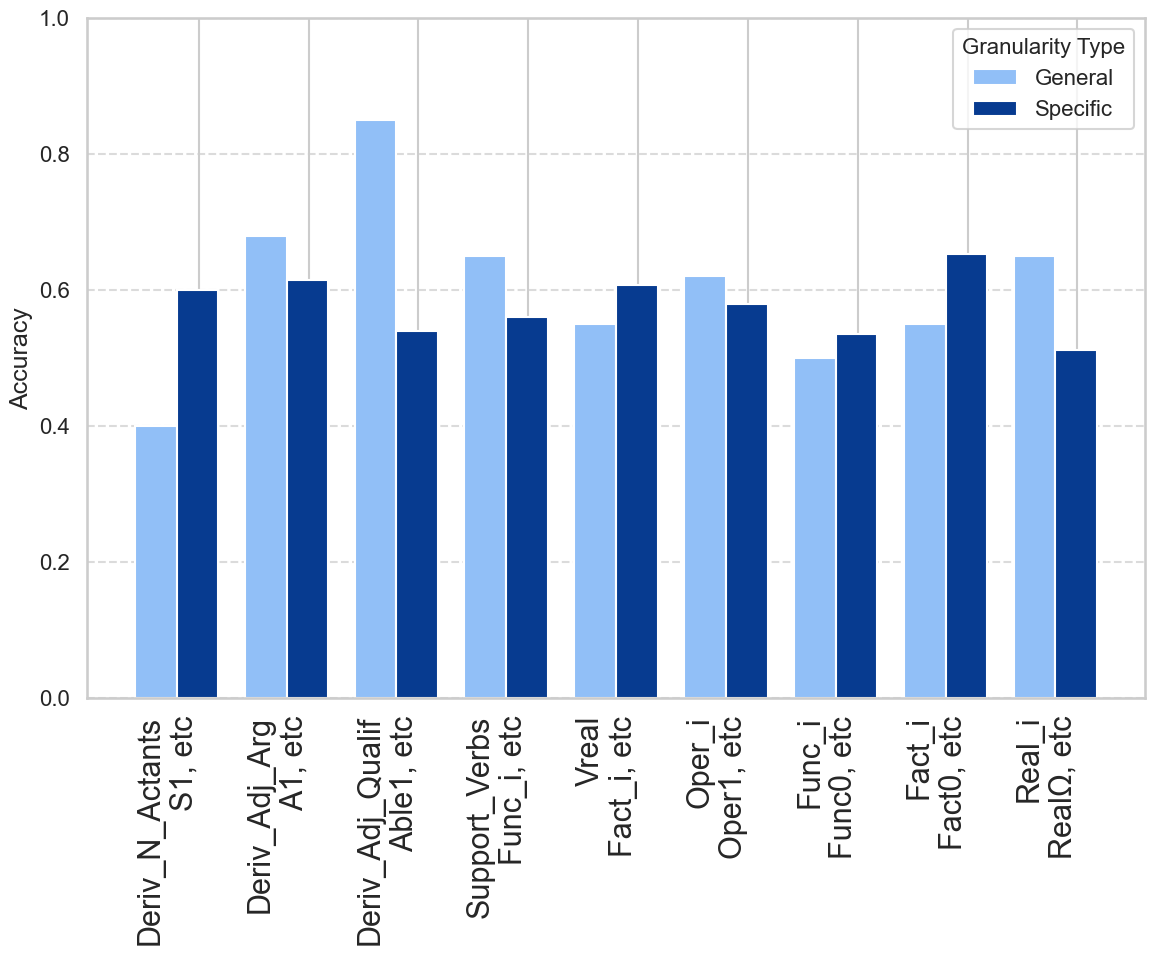

In [96]:
def barplot_granularity_by_sem_stx_aligned(df: pd.DataFrame, 
                                            granularity_dict: dict,
                                            model_name: str = 'Qwen',
                                            metric_col: str = 'acc_mean',
                                            target_col: str = 'target',
                                            scope_col: str = 'scope_id',
                                            model_col: str = 'model'):
    df = df[df[scope_col] == 1].copy()
    df_filtered = df[df[model_col] == model_name].copy()
    if df_filtered.empty:
        print(f"No data found for model: {model_name}")
        return

    # 准备绘图数据
    plot_data = []
    for granularity, (general_nodes, specific_nodes) in granularity_dict.items():
        general_mean = df_filtered[df_filtered[target_col].isin(general_nodes)][metric_col].mean()
        specific_mean = df_filtered[df_filtered[target_col].isin(specific_nodes)][metric_col].mean()
        specific_label = ', '.join(specific_nodes[:1]) + (', etc' if len(specific_nodes) > 1 else '')
        plot_data.append((granularity, 'General', general_mean, granularity, specific_label))
        plot_data.append((granularity, 'Specific', specific_mean, granularity, specific_label))
    plot_df = pd.DataFrame(plot_data, columns=['Granularity', 'Type', 'Accuracy', 'XLabel', 'SLabel'])

    # 设置参数
    bar_width = 0.38
    n = len(granularity_dict)
    group_positions = [i for i in range(n)]
    general_positions = [x - bar_width/2 - 0.2 for x in group_positions]
    specific_positions = [x + bar_width/2 - 0.2 for x in group_positions]

    # 获取数值
    general_vals = plot_df[plot_df['Type'] == 'General']['Accuracy'].tolist()
    specific_vals = plot_df[plot_df['Type'] == 'Specific']['Accuracy'].tolist()
    xtick_labels = [f"{g}\n{s}" for g, s in zip(plot_df['XLabel'][::2], plot_df['SLabel'][::2])]

    # 绘图
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.bar(general_positions, general_vals, width=bar_width, label='General', color="#91BFF7")
    ax.bar(specific_positions, specific_vals, width=bar_width, label='Specific', color="#073B90")

    # 设置坐标轴和标签
    ax.set_xticks(group_positions)
    ax.set_xticklabels(xtick_labels, rotation=90, ha='right', fontsize=22)

    # 调整 y 轴 tick 的字体大小
    ax.tick_params(axis='y', labelsize=16)

    ax.set_ylabel("Accuracy", fontsize=18)
    ax.set_ylim(0, 1)
    ax.legend(title='Granularity Type', fontsize=16, title_fontsize=16)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    # plt.subplots_adjust(bottom=0.25)  # 留出足够空间容纳 fontsize=22 的文字
    gran_name = 'STX_GRAN' if granularity_dict is STX_GRAN else 'SEM_GRAN' if granularity_dict is SEM_GRAN else 'gran'
    plt.savefig(f'otpt/graphs_by_granularity/{model_name}_granularity_performance_{gran_name}.pdf', format='pdf', bbox_inches='tight')
    plt.show()
# Example usage
barplot_granularity_by_sem_stx_aligned(
    df=new_perfm,
    granularity_dict=STX_GRAN,
    model_name='Qwen',
    metric_col='acc_mean',
    target_col='target',
    model_col='model'
)

FileNotFoundError: [Errno 2] No such file or directory: 'otpt/graphs_by_granularity/Qwen_granularity_performance_SEM_GRAN.pdf'

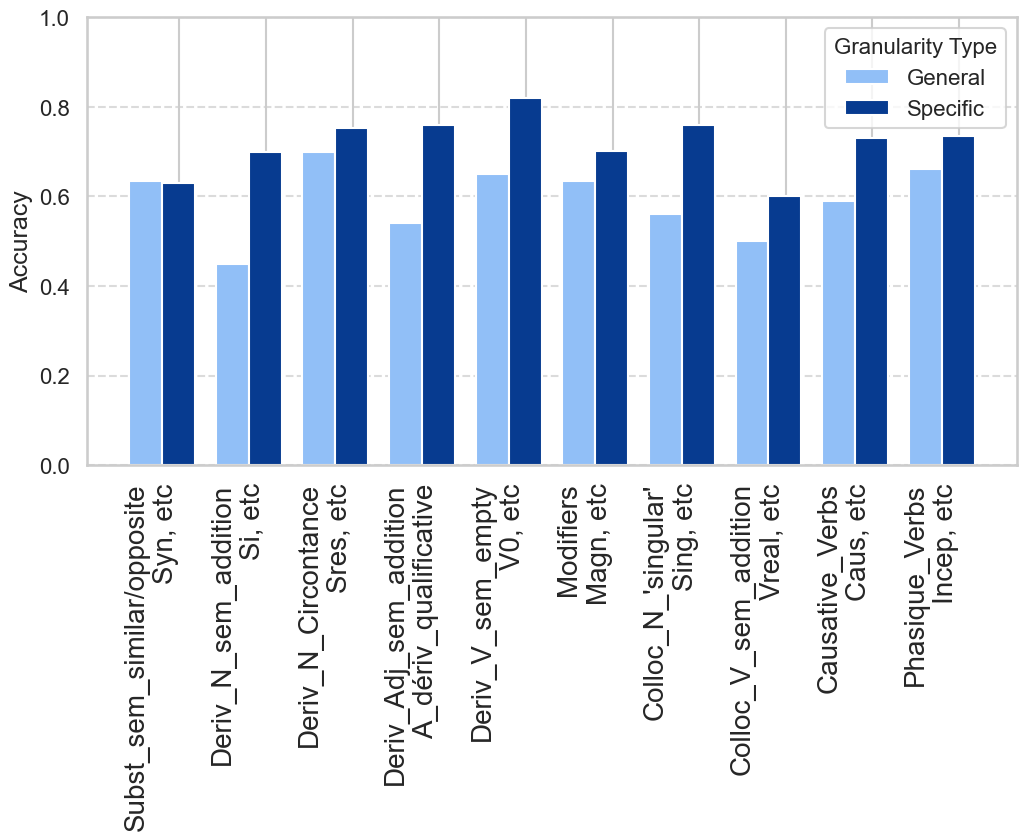

In [97]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def barplot_granularity_by_sem_stx_final(df: pd.DataFrame, 
                                         granularity_dict: dict,
                                         model_name: str = 'Qwen',
                                         metric_col: str = 'acc_mean',
                                         target_col: str = 'target',
                                         scope_col: str = 'scope_id',
                                         model_col: str = 'model'):
    df = df[df[scope_col] == 1].copy()
    df_filtered = df[df[model_col] == model_name].copy()
    if df_filtered.empty:
        print(f"No data found for model: {model_name}")
        return

    plot_data = []
    for granularity, (general_nodes, specific_nodes) in granularity_dict.items():
        general_mean = df_filtered[df_filtered[target_col].isin(general_nodes)][metric_col].mean()
        specific_mean = df_filtered[df_filtered[target_col].isin(specific_nodes)][metric_col].mean()
        specific_label = ', '.join(specific_nodes[:1]) + (', etc' if len(specific_nodes) > 1 else '')
        plot_data.append((granularity, 'General', general_mean, granularity, specific_label))
        plot_data.append((granularity, 'Specific', specific_mean, granularity, specific_label))
    plot_df = pd.DataFrame(plot_data, columns=['Granularity', 'Type', 'Accuracy', 'XLabel', 'SLabel'])

    bar_width = 0.38
    n = len(granularity_dict)
    group_positions = [i for i in range(n)]
    general_positions = [x - bar_width/2 - 0.2 for x in group_positions]
    specific_positions = [x + bar_width/2 - 0.2 for x in group_positions]

    general_vals = plot_df[plot_df['Type'] == 'General']['Accuracy'].tolist()
    specific_vals = plot_df[plot_df['Type'] == 'Specific']['Accuracy'].tolist()
    xtick_labels = [f"{g}\n{s}" for g, s in zip(plot_df['XLabel'][::2], plot_df['SLabel'][::2])]

    fig, ax = plt.subplots(figsize=(max(12, n * 1.2), 8))
    ax.bar(general_positions, general_vals, width=bar_width, label='General', color="#91BFF7")
    ax.bar(specific_positions, specific_vals, width=bar_width, label='Specific', color="#073B90")

    ax.set_xticks(group_positions)
    ax.set_xticklabels(xtick_labels, rotation=90, ha='right', fontsize=20)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_ylabel("Accuracy", fontsize=18)
    ax.set_ylim(0, 1)
    ax.legend(title='Granularity Type', fontsize=16, title_fontsize=16)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    fig.subplots_adjust(bottom=0.32)

    gran_name = 'STX_GRAN' if granularity_dict is STX_GRAN else 'SEM_GRAN' if granularity_dict is SEM_GRAN else 'gran'
    plt.savefig(f'otpt/graphs_by_granularity/{model_name}_granularity_performance_{gran_name}.pdf', format='pdf')
    # os.makedirs(save_dir, exist_ok=True)
    # output_path = os.path.join(save_dir, f'{model_name}_granularity_performance_{gran_name}.pdf')

    # fig.savefig(output_path, format='pdf', dpi=300)
    plt.show()
    # return output_path
# Example usage
barplot_granularity_by_sem_stx_final(
    df=new_perfm,
    granularity_dict=SEM_GRAN,
    model_name='Qwen',
    metric_col='acc_mean',
    target_col='target',
    model_col='model'
)

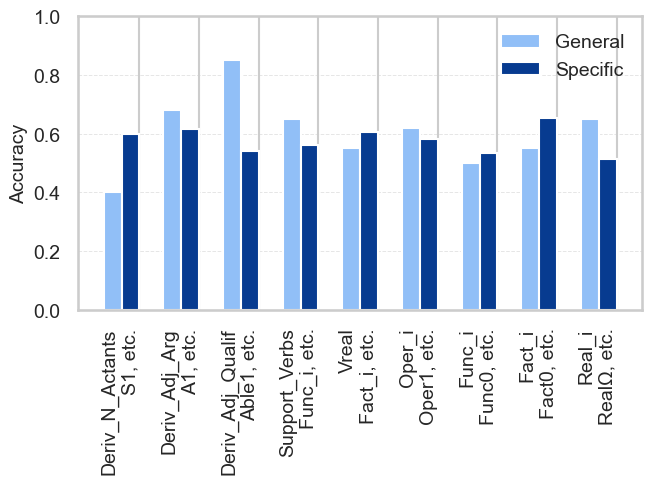

In [98]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def barplot_granularity_acl_single_column(df: pd.DataFrame, 
                                          granularity_dict: dict,
                                          model_name: str = 'Qwen',
                                          metric_col: str = 'acc_mean',
                                          target_col: str = 'target',
                                          scope_col: str = 'scope_id',
                                          model_col: str = 'model'):
    df = df[df[scope_col] == 1].copy()
    df_filtered = df[df[model_col] == model_name].copy()
    if df_filtered.empty:
        print(f"No data found for model: {model_name}")
        return

    plot_data = []
    for granularity, (general_nodes, specific_nodes) in granularity_dict.items():
        general_mean = df_filtered[df_filtered[target_col].isin(general_nodes)][metric_col].mean()
        specific_mean = df_filtered[df_filtered[target_col].isin(specific_nodes)][metric_col].mean()
        specific_label = ', '.join(specific_nodes[:1]) + (', etc.' if len(specific_nodes) > 1 else '')
        plot_data.append((granularity, 'General', general_mean, granularity, specific_label))
        plot_data.append((granularity, 'Specific', specific_mean, granularity, specific_label))
    plot_df = pd.DataFrame(plot_data, columns=['Granularity', 'Type', 'Accuracy', 'XLabel', 'SLabel'])

    bar_width = 0.3
    n = len(granularity_dict)
    group_positions = list(range(n))
    general_positions = [x - bar_width/2 - 0.3 for x in group_positions]
    specific_positions = [x + bar_width/2 - 0.3 for x in group_positions]

    general_vals = plot_df[plot_df['Type'] == 'General']['Accuracy'].tolist()
    specific_vals = plot_df[plot_df['Type'] == 'Specific']['Accuracy'].tolist()
    xtick_labels = [f"{g}\n{s}" for g, s in zip(plot_df['XLabel'][::2], plot_df['SLabel'][::2])]

    # 单栏图尺寸设置（inches）
    fig, ax = plt.subplots(figsize=(6.8, 6))  # ACL single-column: ~3.3 inch width

    ax.bar(general_positions, general_vals, width=bar_width, label='General', color="#91BFF7")
    ax.bar(specific_positions, specific_vals, width=bar_width, label='Specific', color="#073B90")

    ax.set_xticks(group_positions)
    ax.set_xticklabels(xtick_labels, rotation=90, ha='right', fontsize=14)  # 小字体清晰显示
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylabel("Accuracy", fontsize=14)
    ax.set_ylim(0, 1)
    ax.legend(title=None, fontsize=14, frameon=False)
    ax.grid(axis='y', linestyle='--', alpha=0.5, linewidth=0.7)

    fig.subplots_adjust(left=0.15, right=0.98, top=0.6)

    # 输出路径
    gran_name = 'STX_GRAN' if granularity_dict is STX_GRAN else 'SEM_GRAN' if 'SEM_GRAN' in globals() and granularity_dict is SEM_GRAN else 'gran'
    os.makedirs('otpt/graphs_by_granularity', exist_ok=True)
    plt.savefig(f'otpt/graphs_by_granularity/{model_name}_granularity_ACL_{gran_name}.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()
# Example usage
barplot_granularity_acl_single_column(
    df=new_perfm,
    granularity_dict=STX_GRAN,
    model_name='Qwen',
    metric_col='acc_mean',
    target_col='target',
    model_col='model'
)


semantic

In [ ]:
perform_best_both.to_csv('otpt/perform_best_both.csv', index=False)

In [ ]:
perform_best_both

In [ ]:
maping = {
    'S1, S2, S3' : ['S1', 'S2', 'S3'],
    'Sres, Sloc, Sinstr' : ['Sres', 'Sloc', 'Sinstr']
          }

# 计算上面两组的平均值，分模型
def calculate_average_performance(df: pd.DataFrame, mapping: dict, metric_col: str = 'acc_mean', model_col: str = 'model'):
    """
    计算指定映射中每组的平均性能指标。
    """
    averages = []
    for group_name, targets in mapping.items():
        group_data = df[df['target'].isin(targets)]
        if not group_data.empty:
            avg_performance = group_data.groupby(model_col)[metric_col].mean().reset_index()
            avg_performance['group'] = group_name
            averages.append(avg_performance)
    return pd.concat(averages, ignore_index=True)
calculate_average_performance(
    df=perform_best_both, 
    mapping=maping, 
    metric_col='acc_mean', 
    model_col='model'
)

In [ ]:
perfm_best_all = pd.read_csv('otpt/perform_best_both.csv')
perfm_best_all

In [ ]:
# 再谈scope
def filtrate_by_scope(df: pd.DataFrame, scope_col: str = 'scope_id', target_col: str = 'target', model_col: str = 'model'):
    """先按照target分组，找到一个target：最大scope的mapping
    然后再从df里面。对每个target都只选择scope=1或者scope=最大值的
    最后形成一个过滤好的df"""    # 按照模型分组
    grouped = df.groupby(target_col)
    # 找到每个target的最大scope_id
    mapping = {}
    df_selected = []
    for target, group in grouped:
        max_scope = group[scope_col].max()
        mapping[target] = max_scope
    # 过滤DataFrame，只保留scope_id为1或最大scope_id的行
    for target, max_scope in mapping.items():
        filtered_group = df[(df[target_col] == target) & (df[scope_col].isin([1, max_scope]))]
        if not filtered_group.empty:
            df_selected.append(filtered_group)
    return pd.concat(df_selected, ignore_index=True)
scope_df = filtrate_by_scope(perfm_best_all, scope_col='scope_id', target_col='target', model_col='model')
scope_df



In [ ]:
def cplot(
    df: pd.DataFrame, 
    hue_col: str = 'model', 
    metric: str = 'acc_mean',
    palette: dict = None
):
    """
    scope那列除了1其他值定义为’max‘
    绘制柱形图，模型为横坐标，性能指标为纵坐标。scope为1的用浅蓝色，scope为最大值的深蓝色。
    模型之间单开，scope之间紧挨着
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    # 确保必要的列存在
    required_cols = [hue_col] + [metric] + ['scope_id']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")

    # 替换scope_id为字符串: '1' 或 'max'
    df = df.copy()
    df['scope_id'] = df['scope_id'].apply(lambda x: 'small' if str(x) == '1' else 'large')
    # 根据模型和scope_id计算平均值
    df = df.groupby([hue_col, 'scope_id'])[metric].mean().reset_index()
    # 设置调色板
    if palette is None:
        palette = {'small': '#91BFF7', 'large': '#073B90'}  # 浅蓝色和深蓝色
    # 绘制柱形图
    sns.set_theme(style="whitegrid")
    sns.set_context("paper", font_scale=1.2)  # 设置字体大小
    plt.figure(figsize=(6.8, 4.8))
    sns.barplot(
        data=df,
        x=hue_col,
        y=metric,
        hue='scope_id',
        palette=palette,
        ci=None,  # 不显示置信区间
        dodge=True  # 模型之间单开，scope之间紧挨着
    )
    plt.xlabel("", fontsize=14)
    plt.ylabel(metric.replace('_', ' ').title(), fontsize=14)
    # plt.title(f"{metric.replace('_', ' ').title()} by Model and Scope", fontsize=16)
    plt.xticks( ha='right', fontsize=16)
    plt.legend(title='Scope', fontsize=12, title_fontsize=14)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(f'otpt/{metric}_by_model_and_scope.pdf', format='pdf', bbox_inches='tight')
    plt.show()
# Example usage
cplot(
    df=scope_df,
    hue_col='model',
    metric='acc_mean',
    palette={'small': '#91BFF7', 'large': '#073B90'}  # 浅蓝色和深蓝色
)